# Data Exploration

In [41]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('baseline')

In [42]:
def json_to_df(json_file=None):
    """ Reads a single JSON file containing the
    shipment information and converts it to a
    structured dataframe
    """
    import pandas as pd
    from pandas.io.json import json_normalize
    import numpy as np
    logger.debug("Converting to dataframe: {}".format(json_file))
    df = pd.read_json(json_file, dtype={"shipment_number": str})
    normalized_df = json_normalize(df['events'])
    df.drop(["events"], axis=1, inplace=True)
    df = pd.concat([df, normalized_df], axis=1)
    if "Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen." == df.tail(1)["status"].item():
        logger.warning("Final delivery state is strange! Ignoring the file {}".format(json_file))
        return
    # Some files have multiple states. It does not make sense!
    if df[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].shape[0] > 1:
        logger.warning("Multiple final states! Ignoring the file {}".format(json_file))
        return
    if df["status"].isnull().any():
        logger.warning("Status column has missing values! Ignoring the file {}".format(json_file))
        return
    if len(df["url"].unique()) > 1:
        logger.warning("Multiple URLs for a single shipment number! Something is wrong")
    if len(df["shipment_number"].unique()) > 1:
        logger.warning("Multiple shipment numbers in the same file. Something is wrong")
    df['crawltime'] = pd.to_datetime(df['crawltime'], utc=True)
    df['datum'] = pd.to_datetime(df['datum'], utc=True) #! 
    if df["status"].isnull().values.any():
        logger.warning("Column status has missing values! ShipmentNumber: {}".format(df["shipment_number"].values[0]))
    final_event_array = np.zeros(len(df))
    final_event_array[-1] = 1
    df["is_final_event"] = final_event_array
    return df

In [43]:
def files_to_df(path='../data'):
    """ Convert all files to a single dataframe
    """
    import os
    import pandas as pd
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
    dfs = [json_to_df(json_file=file) for file in files]
    df = pd.concat(dfs, sort=False)
    return df

In [44]:
df = files_to_df(path='../data')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  


### Are there any missing values?

In [47]:
import pandas as pd
def count_missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df
missing_value_df = count_missing_values(df)

In [48]:
missing_value_df

column_name  percent_missing
shipment_number  shipment_number         0.000000
crawltime              crawltime         0.000000
url                          url         0.000000
datum                      datum         0.000000
status                    status         0.000000
ort                          ort        59.318656
is_final_event    is_final_event         0.000000

Column "ort" has many missing values. We fill them with "Unbekannt"

In [49]:
def fill_missing_values(df):
    """ Fills missing values of specific columns
    in the data frame with pre-defined values.
    """
    df['ort'].fillna("Unbekannt", inplace=True)
    logger.debug("Filled missing values for ort column")
    return df

In [50]:
df = fill_missing_values(df)

Check again if there are any missing values

In [51]:
count_missing_values(df)

column_name  percent_missing
shipment_number  shipment_number              0.0
crawltime              crawltime              0.0
url                          url              0.0
datum                      datum              0.0
status                    status              0.0
ort                          ort              0.0
is_final_event    is_final_event              0.0

### Data Stats

In [52]:
df.shape

(94343, 7)

Number of unique shipment numbers

In [53]:
len(df.shipment_number.unique())

16760

### Investigate Data Types

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94343 entries, 0 to 6
Data columns (total 7 columns):
shipment_number    94343 non-null object
crawltime          94343 non-null datetime64[ns, UTC]
url                94343 non-null object
datum              94343 non-null datetime64[ns, UTC]
status             94343 non-null object
ort                94343 non-null object
is_final_event     94343 non-null float64
dtypes: datetime64[ns, UTC](2), float64(1), object(4)
memory usage: 5.8+ MB


Everything regarding data types seems to be fine! No need for conversion

### Prepare data for exploration and machine learning

- There are places where at least two may be in the same city
- To simplify the analysis, we delete the unnecessery suffixes from these places.

In [23]:
'''
def merge_similar_orte(df):
    import numpy as np
    import pandas as pd
           
    df['ort'] = df['ort'].str.replace("GVZ", "")
    df['ort'] = df['ort'].str.replace("VZ", "")
    df['ort'] = df['ort'].str.replace("MechZB", "")
    df['ort'] = df['ort'].str.replace("(MechZB)", "")
    df['ort'] = df['ort'].str.rstrip()
    return df
'''    

In [24]:
#df = merge_similar_orte(df)

ModuleNotFoundError: No module named 'fuzzywuzzy'

In [40]:
def ngrams(df, string, n=3):
    import re
    df['ort'] = re.sub(r'[,./]\sGVZ, \sVZ, \sMechZB, \s(MechZB), \sSüd, \sNord, \sOst, \sWest',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]
    
print ('All 3-grams in "Orte":')
for ort in df.iterrows():    
    ngrams(df['ort'])

All 3-grams in "Orte":


TypeError: ngrams() missing 1 required positional argument: 'string'

In [35]:
pd.DataFrame(df["ort"].value_counts()).head(20)

ort
Unbekannt            9826
Hamburg              2930
Ku00F6ln              163
Neumu00FCnster        147
Krefeld               146
Bremen                145
Ku00F6ngen            137
Hagen                 134
Bremen GVZ            132
Gu00FCnzburg          126
Feucht                113
Bielefeld             108
Dorsten               106
Hannover              102
Regensburg             95
Neuwied                95
Obertshausen           92
Eutingen im Gu00E4u    87
Kitzingen              84
Augsburg               83

- further we transform the current datetime-format to a discrete time-format, so that we can summarize our data in more descrete time groups 

In [52]:
def discretize_time(df):
    import numpy as np
    import pandas as pd
    from datetime import datetime
    
    df['datum'] = pd.DatetimeIndex(df['datum']).astype(np.int64)/1000000
    
    return df

In [53]:
df = discretize_time(df)

ValueError: Length of values does not match length of index

In [33]:
pd.DataFrame(df["datum"]).head()

datum
0  1.575041e+12
1  1.575123e+12
2  1.575321e+12
3  1.575362e+12
4  1.575372e+12

- Given the features "datum", "status" and "ort" we want to predict the next "datum" and hopefully also the next "status" and the next "ort"
- We create 3 new columns. "datum_next", "ort_next" and "status_next".

In [335]:
def create_target_columns(df):
    import numpy as np 

    df['status_next'] = df.groupby(['shipment_number'])['status'].shift(-1)
    df['ort_next'] = df.groupby(['shipment_number'])['ort'].shift(-1)
    df['datum_next'] = df.groupby(['shipment_number'])['datum'].shift(-1)
    # we define values for the case the package is already delivered.
    df.loc[df['is_final_event'] == 1, 'status_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'ort_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'datum_next'] = np.datetime64('today')
    
    return df

In [336]:
# Disable warnings
pd.set_option('mode.chained_assignment', None)
df = create_target_columns(df)

In [337]:
df.head()

shipment_number                 crawltime  \
0  00340434188193325701 2019-11-05 21:50:58+00:00   
1  00340434188193325701 2019-11-05 21:50:58+00:00   
2  00340434188193325701 2019-11-05 21:50:58+00:00   
3  00340434188193325701 2019-11-05 21:50:58+00:00   
4  00340434188193325701 2019-11-05 21:50:58+00:00   

                                                 url  \
0  https://www.dhl.de/int-verfolgen/search?langua...   
1  https://www.dhl.de/int-verfolgen/search?langua...   
2  https://www.dhl.de/int-verfolgen/search?langua...   
3  https://www.dhl.de/int-verfolgen/search?langua...   
4  https://www.dhl.de/int-verfolgen/search?langua...   

                      datum  \
0 2019-10-08 14:42:00+00:00   
1 2019-10-08 18:19:00+00:00   
2 2019-10-09 02:44:00+00:00   
3 2019-10-09 07:46:00+00:00   
4 2019-10-09 10:35:00+00:00   

                                              status        ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...  Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...    Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...   Saulheim   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.  Unbekannt   

   is_final_event                                        status_next  \
0             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
2             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
3             0.0          Die Sendung wurde erfolgreich zugestellt.   
4             1.0                                    SuccessDelivery   

          ort_next          datum_next  
0          Hamburg 2019-10-08 18:19:00  
1         Saulheim 2019-10-09 02:44:00  
2        Unbekannt 2019-10-09 07:46:00  
3        Unbekannt 2019-10-09 10:35:00  
4  SuccessDelivery 2019-12-12 00:00:00

In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21859 entries, 0 to 4
Data columns (total 10 columns):
shipment_number    21859 non-null object
crawltime          21859 non-null datetime64[ns, UTC]
url                21859 non-null object
datum              21859 non-null datetime64[ns, UTC]
status             21859 non-null object
ort                21859 non-null object
is_final_event     21859 non-null float64
status_next        21859 non-null object
ort_next           21859 non-null object
datum_next         21859 non-null datetime64[ns]
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(1), object(6)
memory usage: 1.8+ MB


### Data Stats

In [339]:
count_missing_values(df)

column_name  percent_missing
shipment_number  shipment_number              0.0
crawltime              crawltime              0.0
url                          url              0.0
datum                      datum              0.0
status                    status              0.0
ort                          ort              0.0
is_final_event    is_final_event              0.0
status_next          status_next              0.0
ort_next                ort_next              0.0
datum_next            datum_next              0.0

In [340]:
df.shape

(21859, 10)

Number of unique shipment numbers

In [341]:
len(df.shipment_number.unique())

4014

In [342]:
len(df.status.unique())

278

In [343]:
len(df.ort.unique())

184

### How many different final delivery states exist?

In [344]:
final_delivery_states = df.groupby(['shipment_number']).tail(1)[["status"]]["status"].unique()
print(final_delivery_states)

['Die Sendung wurde erfolgreich zugestellt.'
 'Der Empfu00E4nger hat die Sendung aus der PACKSTATION abgeholt.'
 'Der Empfu00E4nger hat die Sendung in der Filiale abgeholt.'
 'Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.'
 'Die Sendung wurde vom Absender in der Filiale eingeliefert.'
 "Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Aalen Friedrichstr. 5' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Aalen Friedrichstr. 5&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich."
 'Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.'
 'Die Sendung konnte nicht zugestellt werden und wird in eine Packstation gebracht.'
 'Die Sendung wurde in das Zustellfahrzeug geladen. Die Zu

### How many different initial delivery states exist?

In [345]:
initial_delivery_states = df.groupby(['shipment_number']).head(1)[["status"]]["status"].unique()
print(initial_delivery_states)

['Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.'
 'Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.'
 'Die Sendung wurde abgeholt.'
 'Die Sendung wird fu00FCr den Weitertransport vorbereitet.']


### Distribution of final delivery states

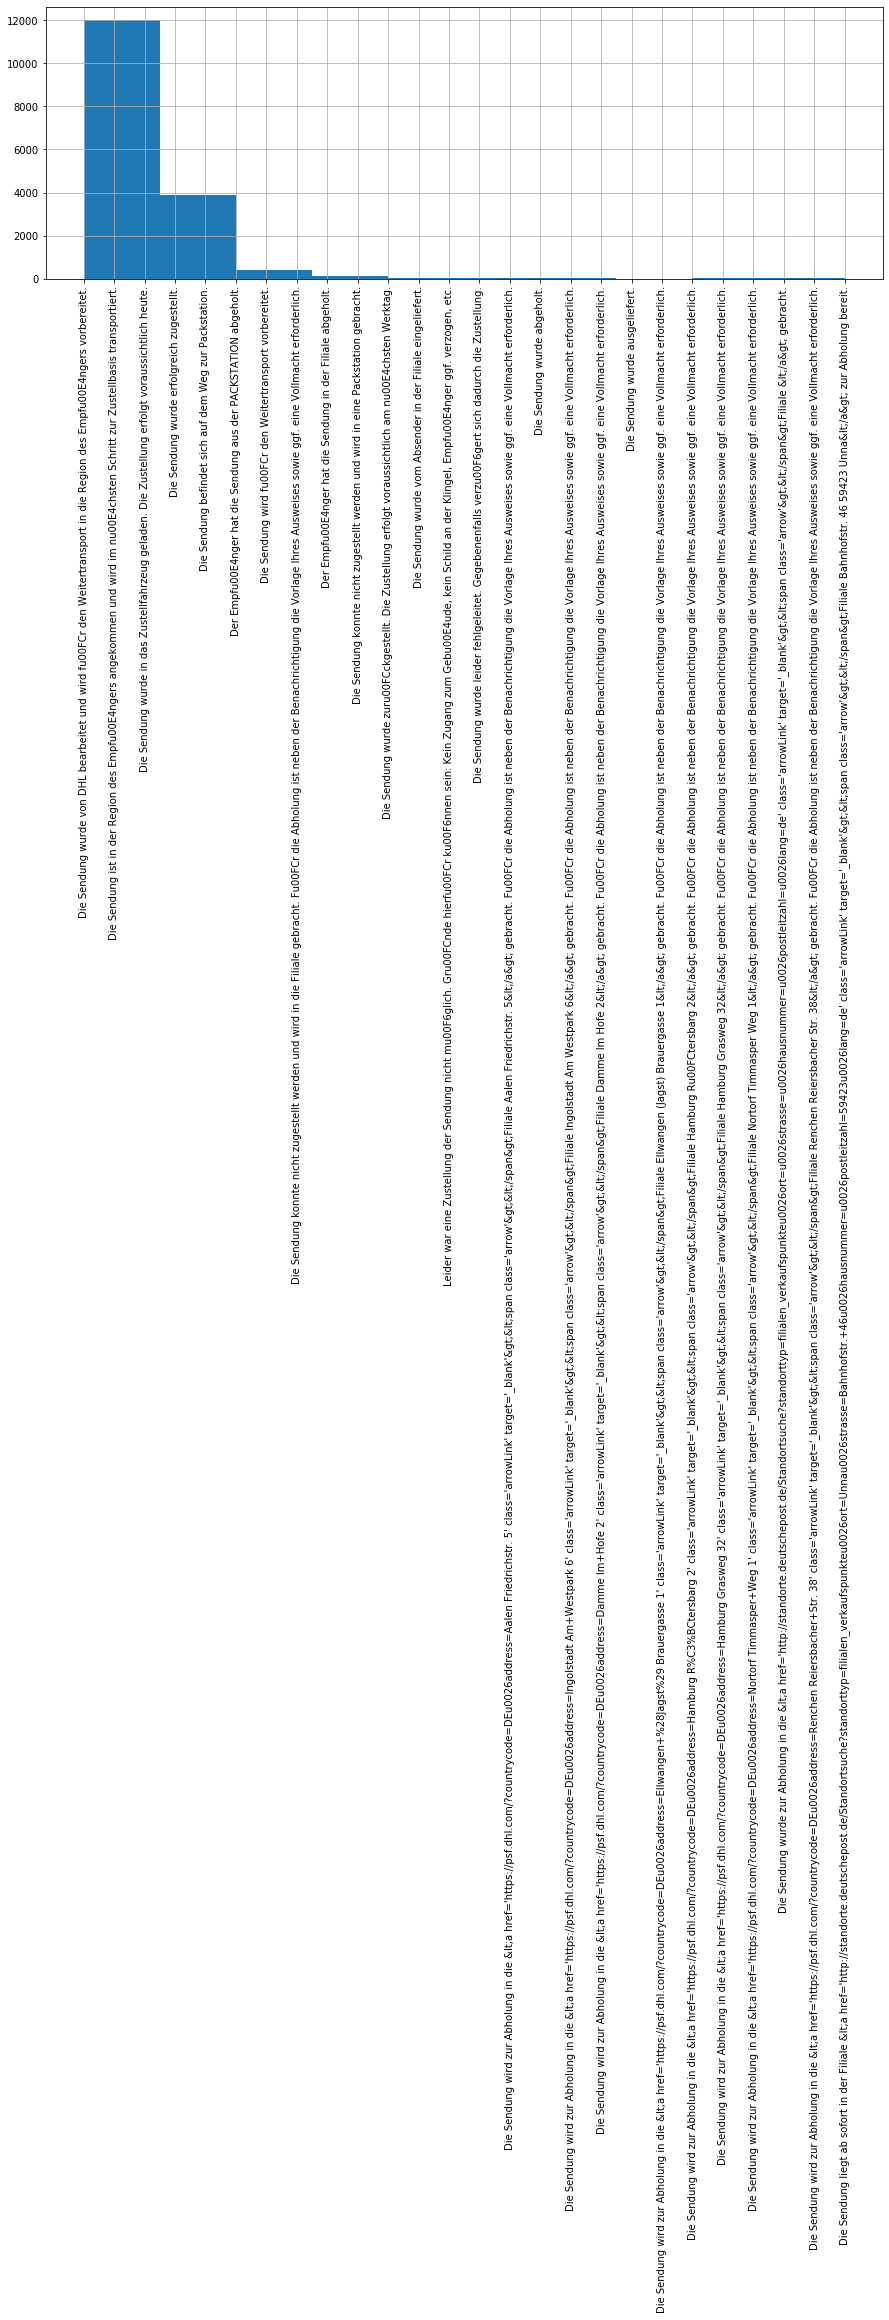

In [346]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')

df[df["status"].isin(final_delivery_states)]["status"].hist(figsize=(15,5))

### Distribution of initial states

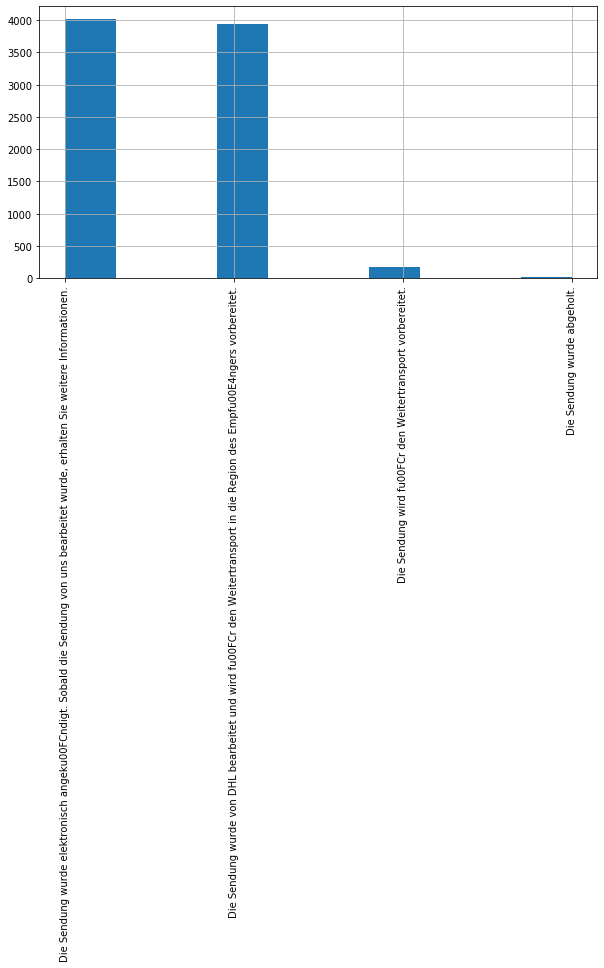

In [347]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')

df[df["status"].isin(initial_delivery_states)]["status"].hist(figsize=(10,5))

### Distribution of all states

These are the most common states

In [348]:
pd.DataFrame(df["status"].value_counts()).head(10)

status
Die Sendung wurde in das Zustellfahrzeug gelade...    4081
Die Sendung ist in der Region des Empfu00E4nger...    4015
Die Sendung wurde elektronisch angeku00FCndigt....    4014
Die Sendung wurde von DHL bearbeitet und wird f...    3937
Die Sendung wurde erfolgreich zugestellt.             3746
Die Sendung wird fu00FCr die Verladung ins Zust...     748
Die Sendung wird fu00FCr den Weitertransport vo...     179
Die Zustellung an einen gewu00FCnschten Ablageo...     175
Der Empfu00E4nger hat die Sendung aus der PACKS...     142
Die Sendung befindet sich auf dem Weg zur Packs...     117

These are the least common states. What we see here is that there are some states that are basically the same and the following pattern:

"Die Sendung liegt in der ........ zur Abholung bereit"

But the address is each time different. This leads to too many states, which also makes machine learning hard. We ignore the address part and convert all these states to a single one.

In [349]:
pd.DataFrame(df["status"].value_counts()).tail(10)

status
Die Sendung wird zur Abholung in die &lt;a href...       1
Die Sendung wird zur Abholung in die &lt;a href...       1
Die Sendung wird zur Abholung in die &lt;a href...       1
Die Sendung wird zur Abholung in die &lt;a href...       1
Die Sendung liegt in der &lt;a href='https://ps...       1
Die Sendung wird zur Abholung in die &lt;a href...       1
Die Sendung liegt in der &lt;a href='https://ps...       1
Die Sendung liegt in der &lt;a href='https://ps...       1
Die Sendung liegt in der &lt;a href='https://ps...       1
Die Sendung liegt in der &lt;a href='https://ps...       1

In [350]:
df.loc[(df['status'].str.startswith("Die Sendung liegt in der")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status'].str.endswith("gebracht.")), "status"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status'].str.endswith("wurde gewu00E4hlt.")), "status"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 

df.loc[(df['status_next'].str.startswith("Die Sendung liegt in der")) & (df['status_next'].str.endswith("zur Abholung bereit.")), "status_next"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status_next'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status_next'].str.endswith("gebracht.")), "status_next"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status_next'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status_next'].str.endswith("wurde gewu00E4hlt.")), "status_next"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 

In [351]:
pd.DataFrame(df["status"].value_counts()).head(10)

status
Die Sendung wurde in das Zustellfahrzeug gelade...    4081
Die Sendung ist in der Region des Empfu00E4nger...    4015
Die Sendung wurde elektronisch angeku00FCndigt....    4014
Die Sendung wurde von DHL bearbeitet und wird f...    3937
Die Sendung wurde erfolgreich zugestellt.             3746
Die Sendung wird fu00FCr die Verladung ins Zust...     748
Die Sendung wird fu00FCr den Weitertransport vo...     179
Die Zustellung an einen gewu00FCnschten Ablageo...     175
Die Sendung liegt in der ... zur Abholung bereit.      144
Der Empfu00E4nger hat die Sendung aus der PACKS...     142

In [352]:
pd.DataFrame(df["status"].value_counts()).tail(10)

status
Die geringfu00FCgig beschu00E4digte Sendung wur...       2
Die Sendung konnte leider nicht in die gewu00FC...       2
Die Sendung wurde leider beschu00E4digt und mus...       1
Der Empfu00E4nger hat die Sendung innerhalb der...       1
Die Sendung befindet sich auf dem Weg zum Empfu...       1
Die Sendung wurde zum Weitertransport aus der P...       1
Der Empfu00E4nger hat die Annahme der Sendung v...       1
Die Sendung wurde ausgeliefert.                          1
Aufgrund einer Beschu00E4digung der Umverpackun...       1
Die Sendung in Paketkasten-Anlage eingestellt            1

In [353]:
len(df["status"].unique())

47

In [354]:
len(df["status_next"].unique())

64

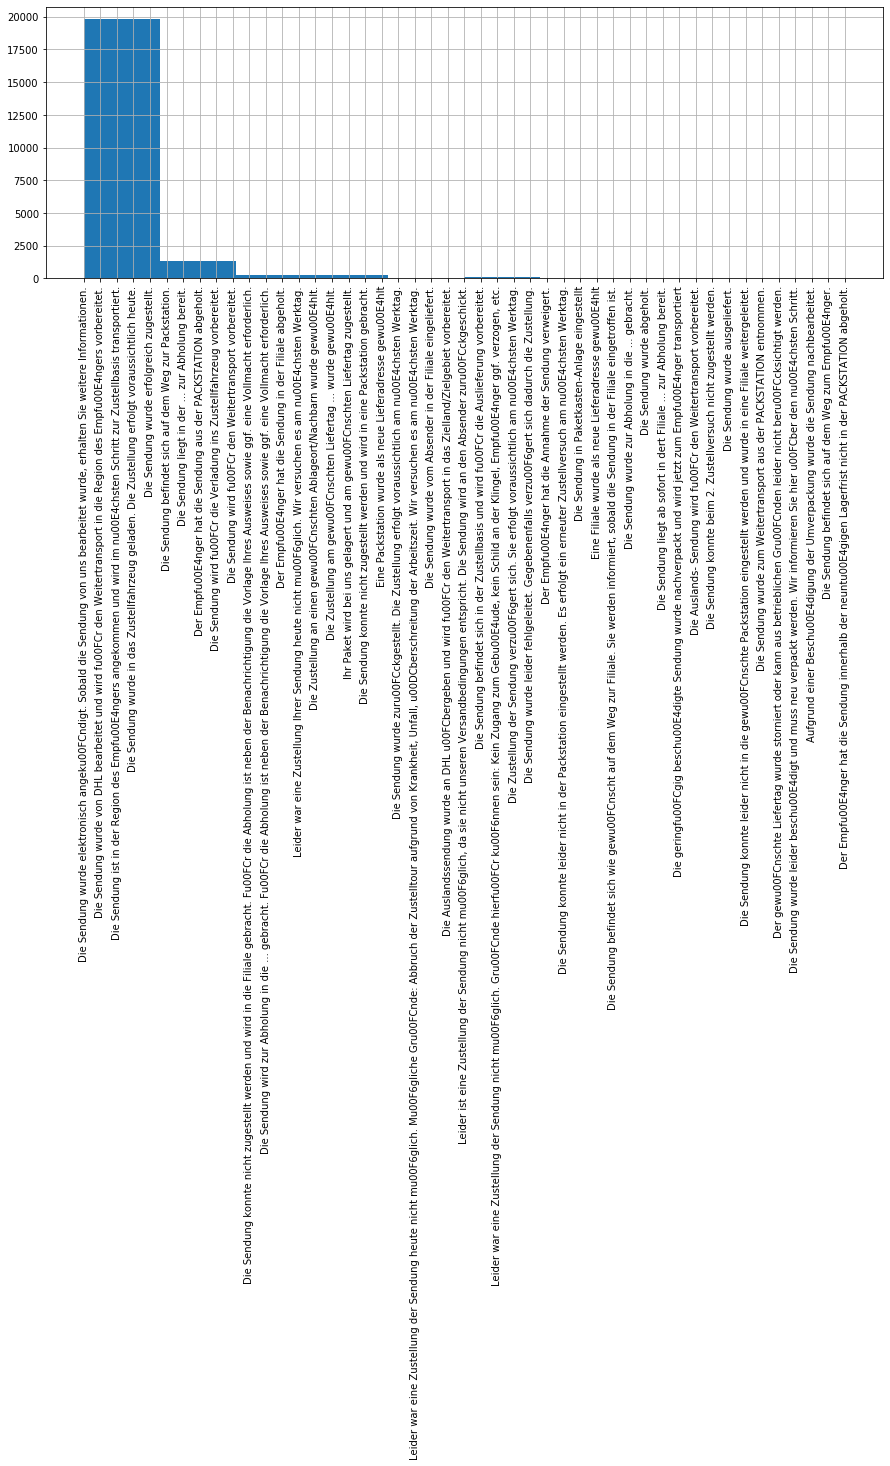

In [355]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')
df["status"].hist(figsize=(15,5))

We introduces two new states to status_next: SuccessDelivery, FailedDelivery

### Distribution of the locations

In [356]:
len(df["ort"].unique())

184

In [357]:
pd.DataFrame(df["ort"].value_counts()).head(20)

ort
Unbekannt       12813
Hamburg          4021
Bremen            331
Krefeld           201
Ku00F6ln          197
Hannover          185
Ku00F6ngen        176
Gu00FCnzburg      170
Dorsten           170
Hagen             160
Neumu00FCnster    153
Obertshausen      149
Neuwied           136
Feucht            135
Bielefeld         134
Saulheim          129
Aschheim          129
Augsburg          120
Regensburg        119
Greven            116

In [358]:
pd.DataFrame(df["ort"].value_counts()).tail(20)

ort
Lu00FCneburg              1
Oranienburg               1
Bad Soden am Taunus       1
Velbert                   1
Lauchheim                 1
Voerde (Niederrhein)      1
Wildau                    1
Bad Kreuznach             1
Ibbenbu00FCren            1
Trier                     1
Uetersen                  1
Marburg                   1
Wirges                    1
Varel                     1
Mu00FCnster               1
Friedrichshafen           1
Rostock                   1
Lemfu00F6rde              1
Greifswald, Hansestadt    1
Pirmasens                 1

Notice: One idea here could be to merge some locations. 

### Remove unused columns

In [359]:
df.drop(columns=["crawltime", "url"], inplace=True)

In [360]:
df.head()

shipment_number                     datum  \
0  00340434188193325701 2019-10-08 14:42:00+00:00   
1  00340434188193325701 2019-10-08 18:19:00+00:00   
2  00340434188193325701 2019-10-09 02:44:00+00:00   
3  00340434188193325701 2019-10-09 07:46:00+00:00   
4  00340434188193325701 2019-10-09 10:35:00+00:00   

                                              status        ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...  Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...    Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...   Saulheim   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.  Unbekannt   

   is_final_event                                        status_next  \
0             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
2             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
3             0.0          Die Sendung wurde erfolgreich zugestellt.   
4             1.0                                    SuccessDelivery   

          ort_next          datum_next  
0          Hamburg 2019-10-08 18:19:00  
1         Saulheim 2019-10-09 02:44:00  
2        Unbekannt 2019-10-09 07:46:00  
3        Unbekannt 2019-10-09 10:35:00  
4  SuccessDelivery 2019-12-12 00:00:00

### Distribution of event times

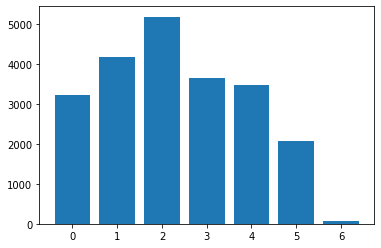

In [361]:
counts = df['datum'].dt.dayofweek.value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

We see in the above plot which days of the week have the highest amount of events. Sunday has for example the least amount of events, as expected.

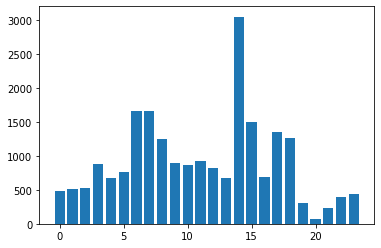

In [362]:
counts = df['datum'].dt.hour.value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

In the above plot we see the distribution of the events over 24 hours of a day

### Time diff between events

In [363]:
df['datum'] = pd.to_datetime(df['datum'], utc=True)
df['datum_next'] = pd.to_datetime(df['datum_next'], utc=True)
df["datum_diff"] = df["datum_next"] - df["datum"]

Notice that for is_final_event=1, the datum_diff does not make any sense. Do not use it in the analysis

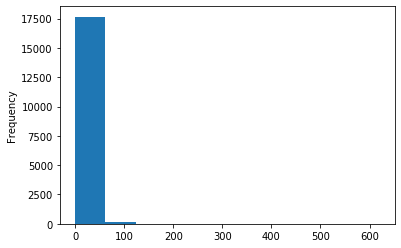

In [364]:
df[df["is_final_event"] == 0]['datum_diff'].astype('timedelta64[h]').plot.hist()

We observe two interesting things here. There are events with zero time diff and there are events with very big time diffs.

### Events with very small time diffs

In [365]:
df[(df["is_final_event"] == 0.0) & (df['datum_diff'].astype('timedelta64[s]') == 0)] 

shipment_number                     datum  \
3   00340434188193323790 2019-10-10 05:22:00+00:00   
3   00340434188193313326 2019-09-07 06:09:00+00:00   
1   00340434188193341114 2019-12-02 19:06:00+00:00   
4   00340434188193328467 2019-10-24 06:11:00+00:00   
4   00340434188193289362 2019-07-13 05:50:00+00:00   
..                   ...                       ...   
5   00340434188193311162 2019-09-06 06:54:00+00:00   
4   00340434188193307219 2019-09-05 09:49:00+00:00   
5   00340434188193334345 2019-11-26 08:02:00+00:00   
4   00340434188193305727 2019-09-04 07:14:00+00:00   
3   00340434188193315009 2019-09-10 05:23:00+00:00   

                                               status        ort  \
3   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
1   Die Sendung wurde von DHL bearbeitet und wird ...    Hamburg   
4   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
..                                                ...        ...   
5   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
5   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
3   Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   

    is_final_event                                        status_next  \
3              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   
3              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   
1              0.0  Die Zustellung am gewu00FCnschten Liefertag .....   
4              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   
4              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   
..             ...                                                ...   
5              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   
4              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   
5              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   
4              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   
3              0.0  Die Sendung befindet sich auf dem Weg zur Pack...   

     ort_next                datum_next datum_diff  
3   Unbekannt 2019-10-10 05:22:00+00:00     0 days  
3   Unbekannt 2019-09-07 06:09:00+00:00     0 days  
1   Unbekannt 2019-12-02 19:06:00+00:00     0 days  
4   Unbekannt 2019-10-24 06:11:00+00:00     0 days  
4   Unbekannt 2019-07-13 05:50:00+00:00     0 days  
..        ...                       ...        ...  
5   Unbekannt 2019-09-06 06:54:00+00:00     0 days  
4   Unbekannt 2019-09-05 09:49:00+00:00     0 days  
5   Unbekannt 2019-11-26 08:02:00+00:00     0 days  
4   Unbekannt 2019-09-04 07:14:00+00:00     0 days  
3   Unbekannt 2019-09-10 05:23:00+00:00     0 days  

[141 rows x 9 columns]

### Events with huge time diffs

In [366]:
df[(df["is_final_event"] == 0.0) & (df['datum_diff'].astype('timedelta64[h]') > 150)] 

shipment_number                     datum  \
7  00340434188193289362 2019-07-19 13:34:00+00:00   
4  00340434188193318291 2019-09-11 11:58:00+00:00   
6  00340434188193304836 2019-09-04 09:27:00+00:00   
6  00340434188193320522 2019-10-04 09:03:00+00:00   
5  00340434188193337681 2019-11-27 12:07:00+00:00   
7  00340434188193337254 2019-11-28 00:05:00+00:00   
5  00340434188193301330 2019-08-16 07:28:00+00:00   
3  00340434188193312459 2019-09-07 06:43:00+00:00   
6  00340434188193335045 2019-11-28 07:53:00+00:00   
5  00340434188193337384 2019-11-27 16:32:00+00:00   
6  00340434188193336608 2019-11-26 16:24:00+00:00   
4  00340434188193311605 2019-09-06 10:02:00+00:00   
6  00340434188193337667 2019-11-29 07:29:00+00:00   
2  00340434188193308742 2019-09-04 23:12:00+00:00   
1  00340434188193311742 2019-09-05 17:03:00+00:00   
4  00340434188193295318 2019-07-24 13:29:00+00:00   
6  00340434188193310400 2019-09-06 08:01:00+00:00   
7  00340434188193334666 2019-12-02 10:19:00+00:00   

                                              status                ort  \
7  Der Empfu00E4nger hat die Sendung aus der PACK...          Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.          Unbekannt   
6  Die Sendung liegt in der ... zur Abholung bereit.       Braunschweig   
6  Die Sendung befindet sich auf dem Weg zur Pack...          Unbekannt   
5          Die Sendung wurde erfolgreich zugestellt.          Unbekannt   
7  Die Sendung wird fu00FCr die Verladung ins Zus...        Hattersheim   
5          Die Sendung wurde erfolgreich zugestellt.          Unbekannt   
3  Die Sendung wurde in das Zustellfahrzeug gelad...          Unbekannt   
6  Die Sendung liegt ab sofort in dert Filiale .....          Unbekannt   
5  Die Sendung liegt ab sofort in dert Filiale .....          Unbekannt   
6  Die Sendung liegt ab sofort in dert Filiale .....          Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.          Unbekannt   
6  Die Sendung liegt ab sofort in dert Filiale .....          Unbekannt   
2  Die Sendung wurde von DHL bearbeitet und wird ...            Hamburg   
1  Die Sendung wurde von DHL bearbeitet und wird ...            Hamburg   
4  Die Sendung liegt in der ... zur Abholung bereit.  Offenbach am Main   
6          Die Sendung wurde erfolgreich zugestellt.          Unbekannt   
7  Die Sendung wird zur Abholung in die ... gebra...          Unbekannt   

   is_final_event                                        status_next  \
7             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
4             0.0  Die Sendung wurde vom Absender in der Filiale ...   
6             0.0  Der Empfu00E4nger hat die Sendung aus der PACK...   
6             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
5             0.0  Die Sendung wurde vom Absender in der Filiale ...   
7             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
5             0.0  Die Sendung wird fu00FCr den Weitertransport v...   
3             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
6             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
5             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
6             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
4             0.0                        Die Sendung wurde abgeholt.   
6             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   
2             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
4             0.0  Der Empfu00E4nger hat die Sendung innerhalb de...   
6             0.0  Die Sendung wurde vom Absender in der Filiale ...   
7             0.0  Der Empfu00E4nger hat die Sendung in der Filia...   

            ort_next                datum_next       datum_diff  
7          Unbekannt 2019-08-14 09:57:00+00:00 25 days 20:23:00  
4          Unbekannt 2019-09-21 08:29:00+00:00  9 days 20:31:00  
6      

### Distribution of time diff for various states

In [367]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [368]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

datum_diff_h                                             status
0           3.0  Die Sendung wurde elektronisch angeku00FCndigt...
1           8.0  Die Sendung wurde von DHL bearbeitet und wird ...
2           5.0  Die Sendung ist in der Region des Empfu00E4nge...
3           2.0  Die Sendung wurde in das Zustellfahrzeug gelad...
4          22.0  Die Sendung wurde elektronisch angeku00FCndigt...

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


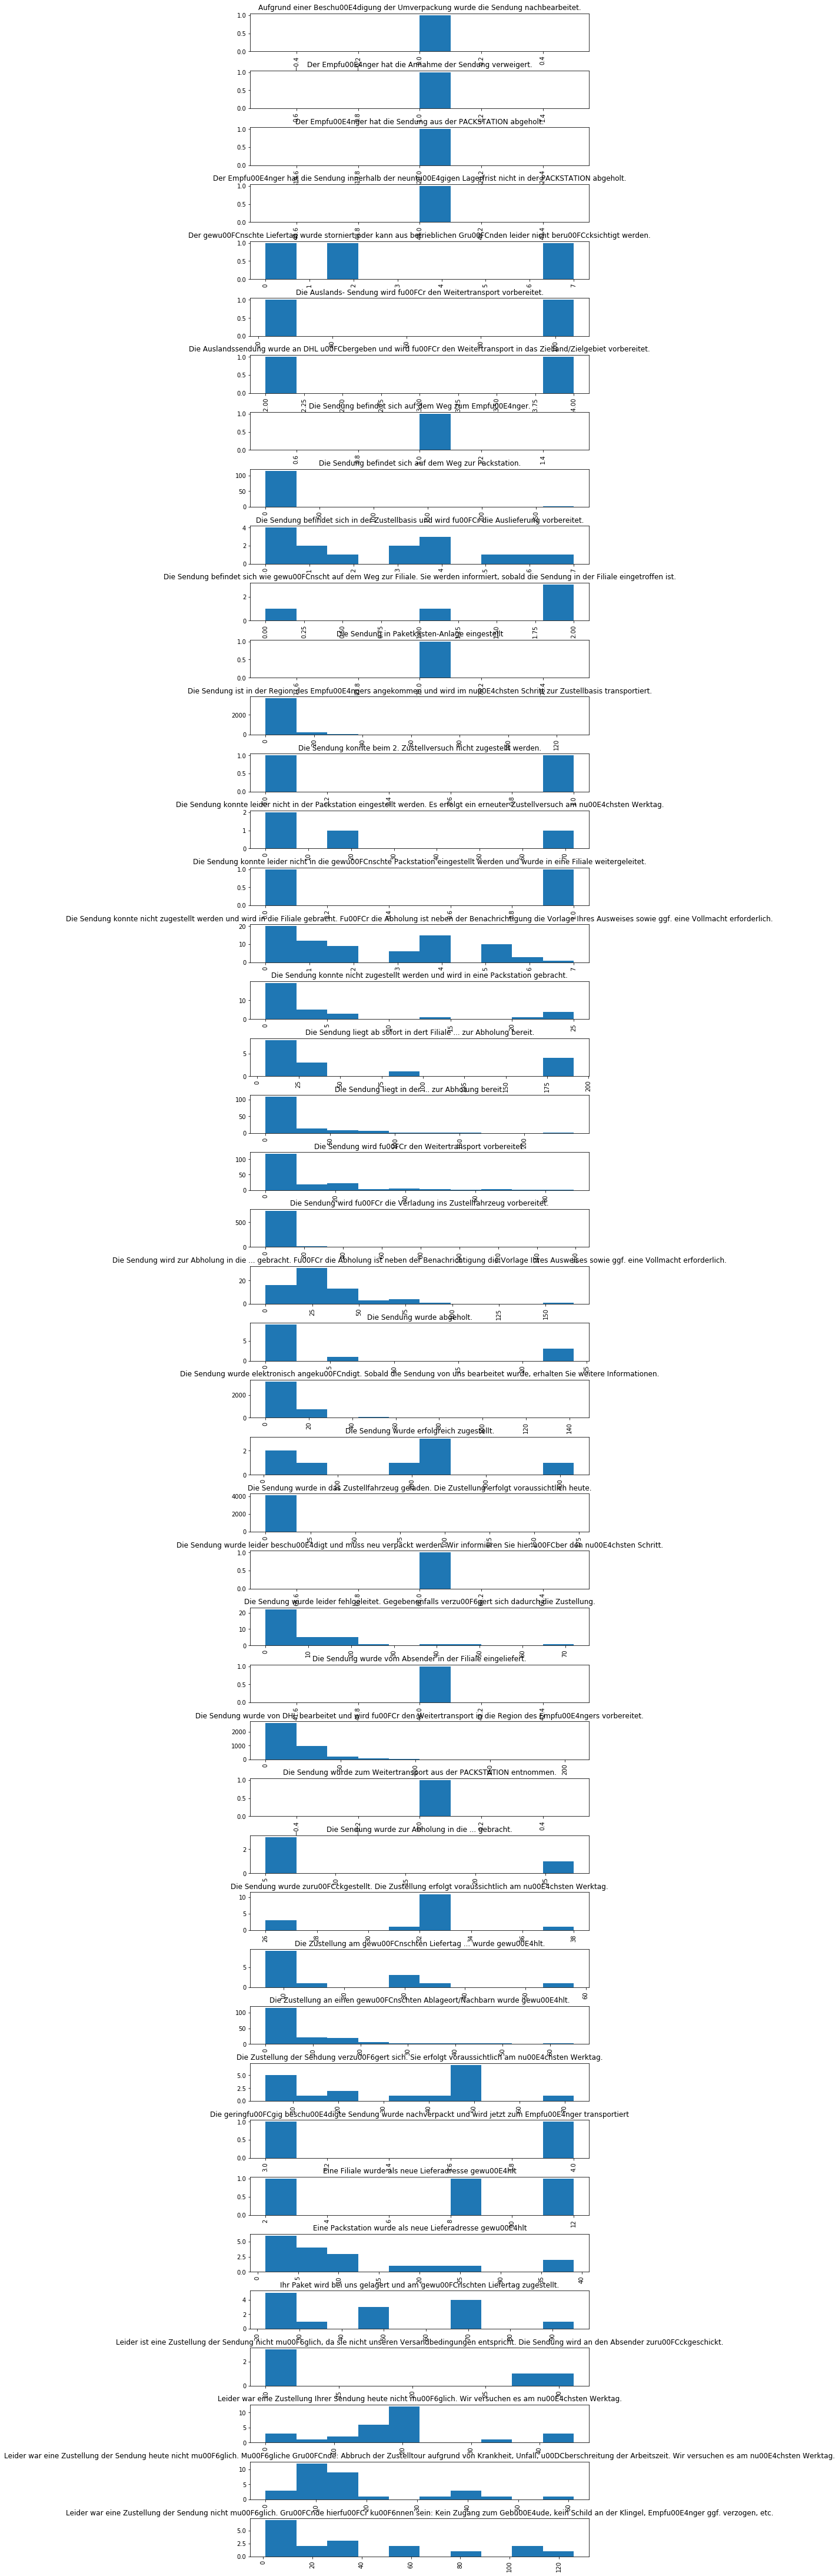

In [369]:
%matplotlib inline
df_temp["datum_diff_h"].hist(by=df_temp['status'], layout=(len(df_temp["status"].unique()), 1), figsize=(10,80))
plt.tight_layout()
df.drop(columns=["datum_diff_h"], inplace=True)

In [370]:
df.head()

shipment_number                     datum  \
0  00340434188193325701 2019-10-08 14:42:00+00:00   
1  00340434188193325701 2019-10-08 18:19:00+00:00   
2  00340434188193325701 2019-10-09 02:44:00+00:00   
3  00340434188193325701 2019-10-09 07:46:00+00:00   
4  00340434188193325701 2019-10-09 10:35:00+00:00   

                                              status        ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...  Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...    Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...   Saulheim   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.  Unbekannt   

   is_final_event                                        status_next  \
0             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
2             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
3             0.0          Die Sendung wurde erfolgreich zugestellt.   
4             1.0                                    SuccessDelivery   

          ort_next                datum_next       datum_diff  
0          Hamburg 2019-10-08 18:19:00+00:00  0 days 03:37:00  
1         Saulheim 2019-10-09 02:44:00+00:00  0 days 08:25:00  
2        Unbekannt 2019-10-09 07:46:00+00:00  0 days 05:02:00  
3        Unbekannt 2019-10-09 10:35:00+00:00  0 days 02:49:00  
4  SuccessDelivery 2019-12-12 00:00:00+00:00 63 days 13:25:00

### Distribution of time diff for various locations

In [371]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [372]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status", "ort"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

datum_diff_h                                             status        ort
0           3.0  Die Sendung wurde elektronisch angeku00FCndigt...  Unbekannt
1           8.0  Die Sendung wurde von DHL bearbeitet und wird ...    Hamburg
2           5.0  Die Sendung ist in der Region des Empfu00E4nge...   Saulheim
3           2.0  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt
4          22.0  Die Sendung wurde elektronisch angeku00FCndigt...  Unbekannt

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  This is separate from the ipykernel package so we can avoid doing imports until


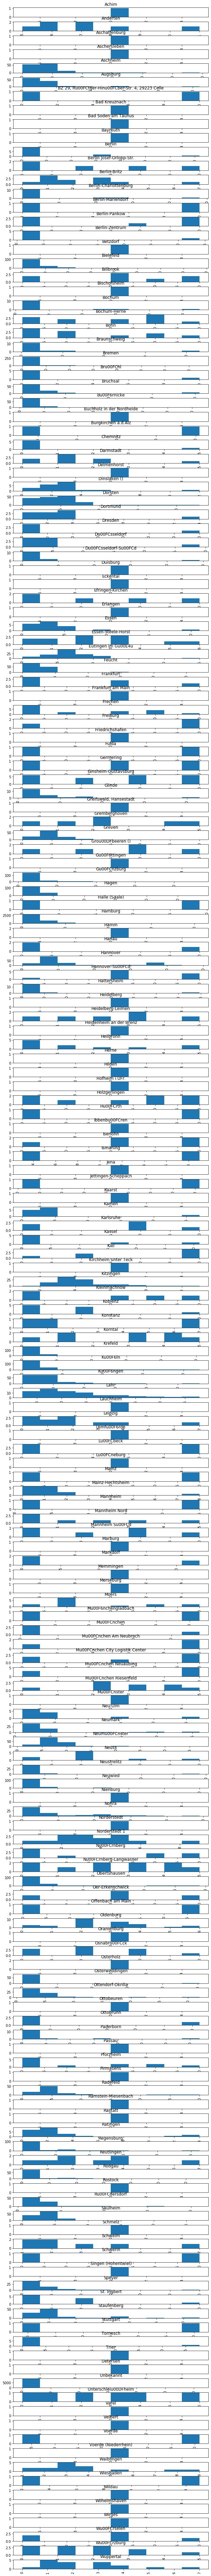

In [373]:
%matplotlib inline
df_temp["datum_diff_h"].hist(by=df_temp['ort'], layout=(len(df_temp["ort"].unique()), 1), figsize=(10,140))
plt.tight_layout()
df.drop(columns=["datum_diff_h"], inplace=True)

### Distribution of time diff for various locations and states

In [374]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [375]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status", "ort"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

datum_diff_h                                             status        ort
0           3.0  Die Sendung wurde elektronisch angeku00FCndigt...  Unbekannt
1           8.0  Die Sendung wurde von DHL bearbeitet und wird ...    Hamburg
2           5.0  Die Sendung ist in der Region des Empfu00E4nge...   Saulheim
3           2.0  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt
4          22.0  Die Sendung wurde elektronisch angeku00FCndigt...  Unbekannt

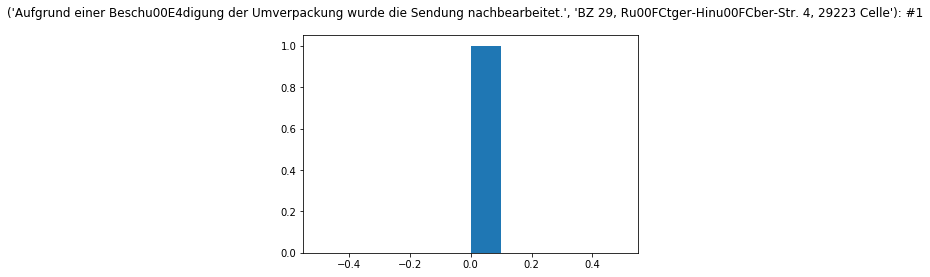

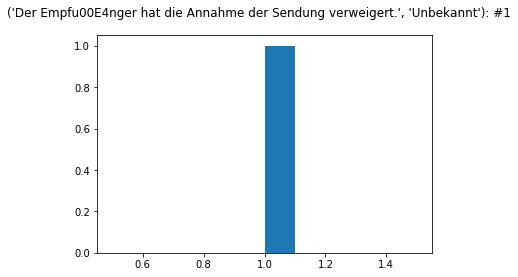

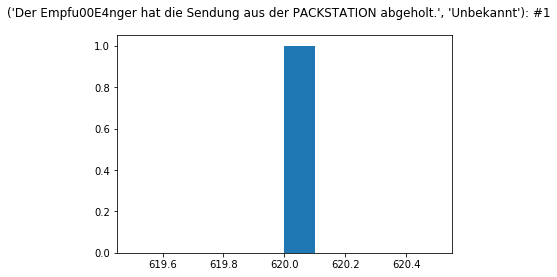

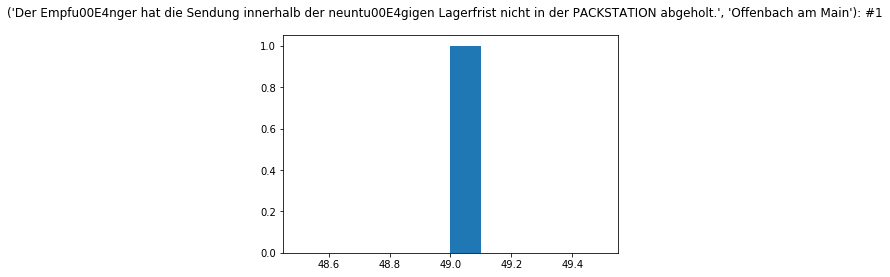

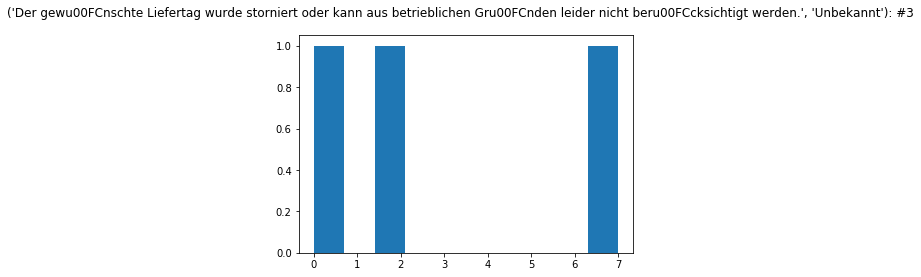

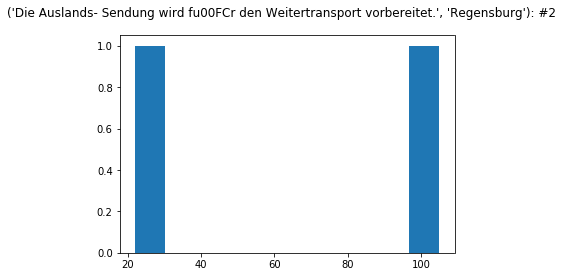

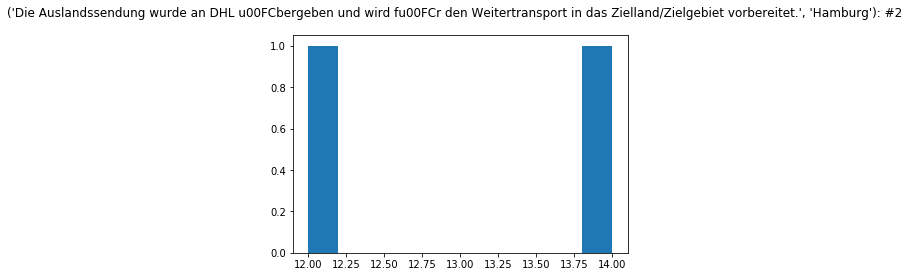

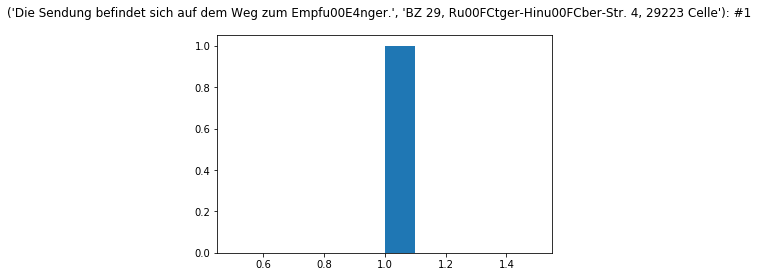

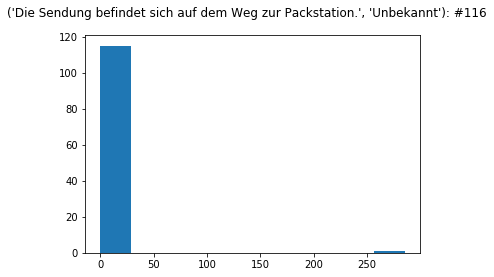

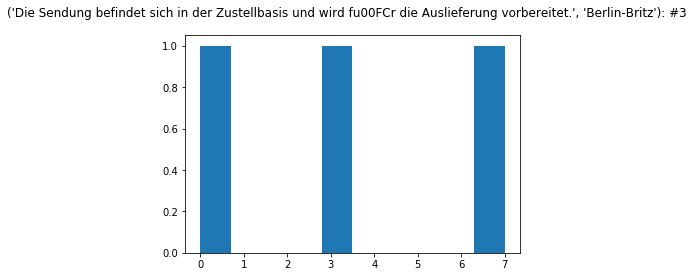

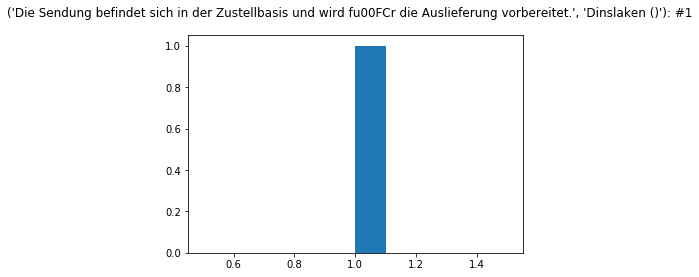

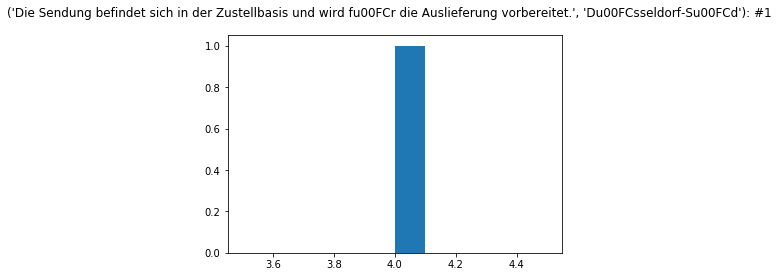

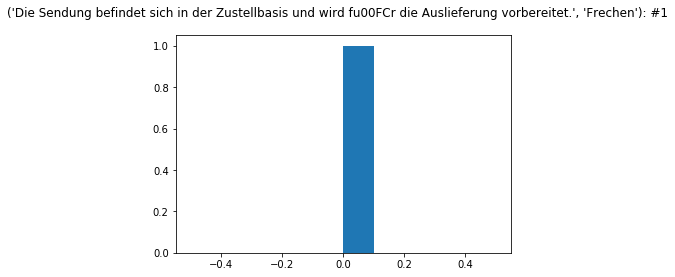

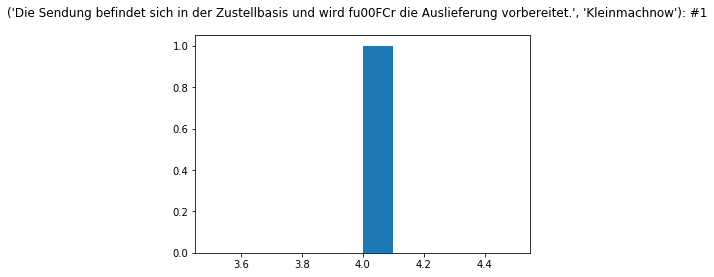

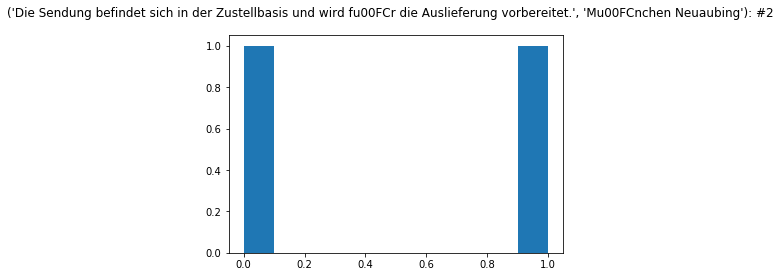

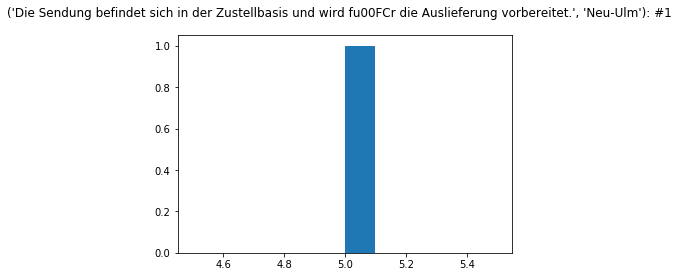

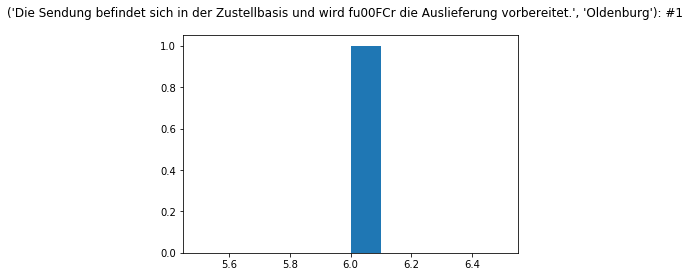

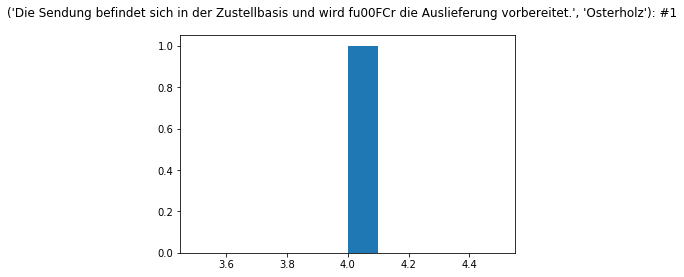

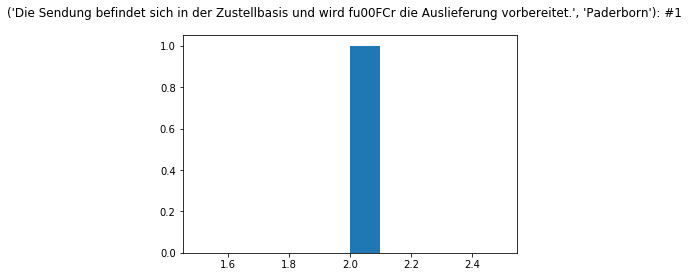

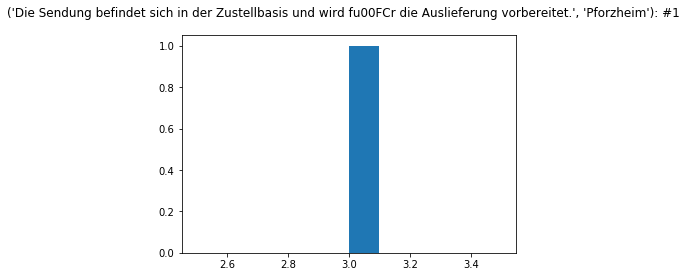

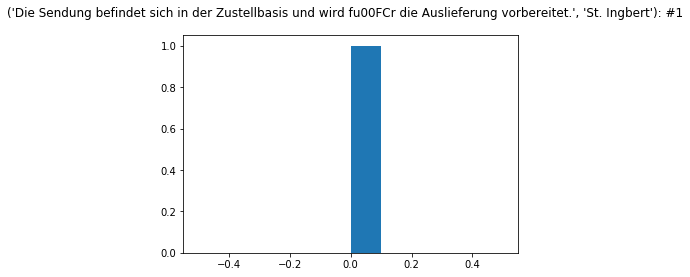

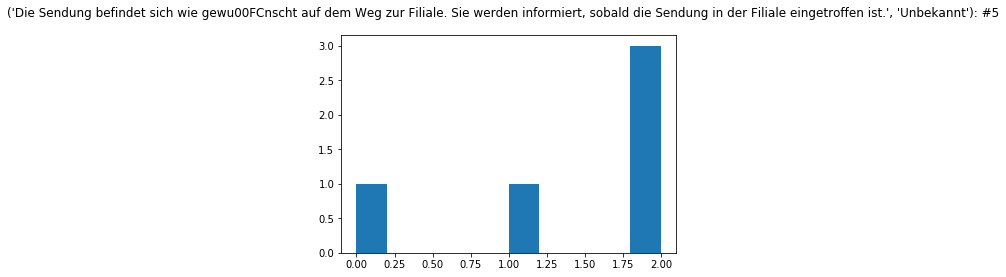

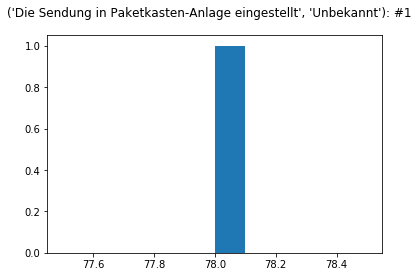

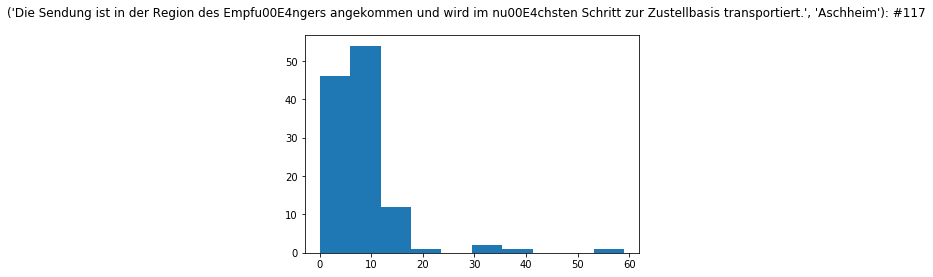

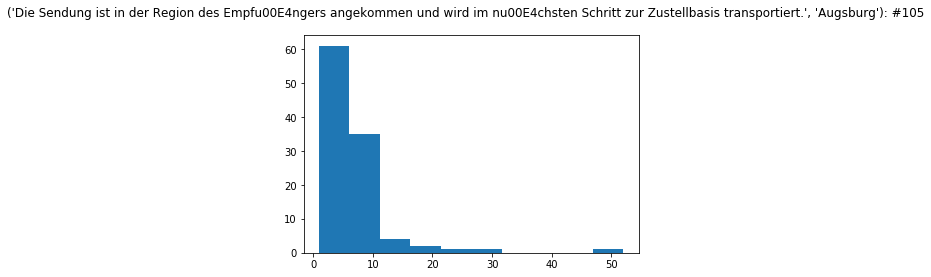

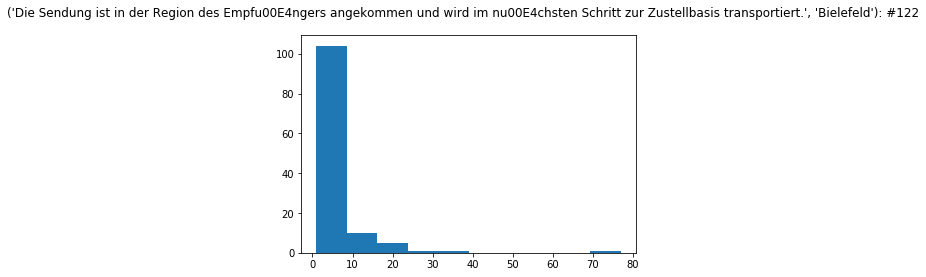

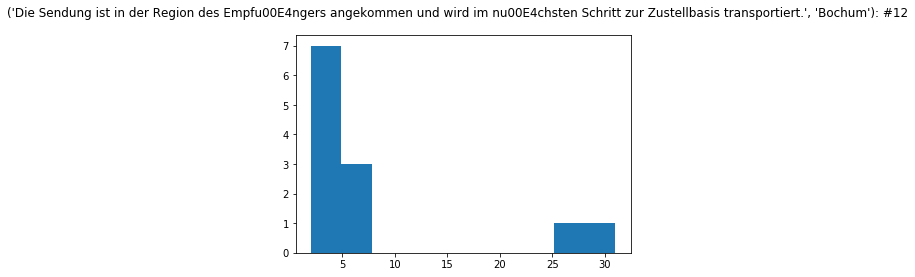

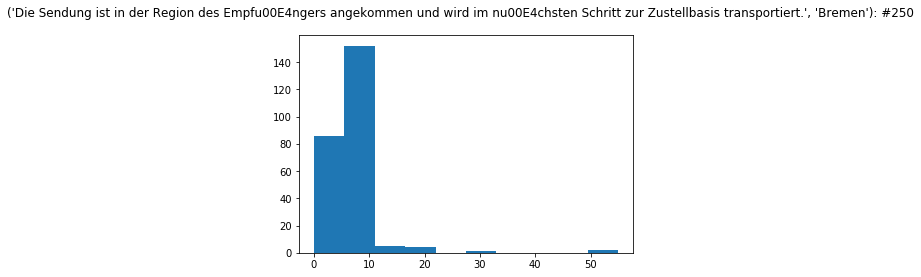

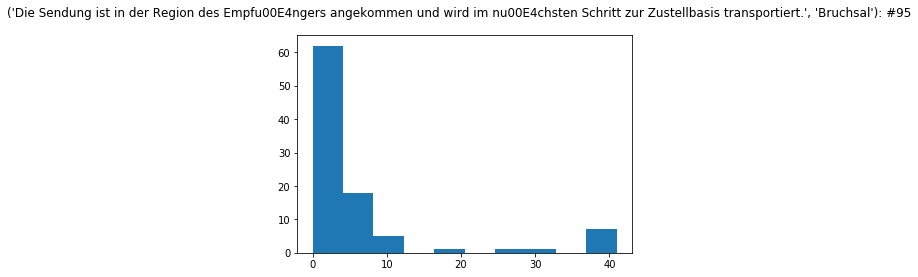

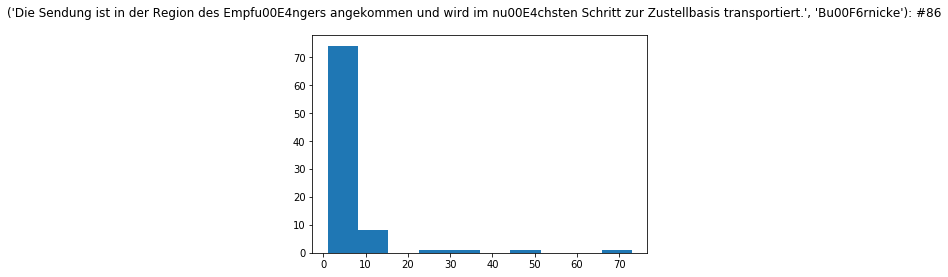

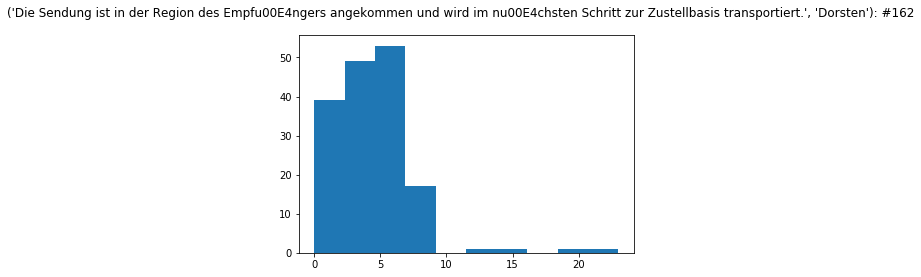

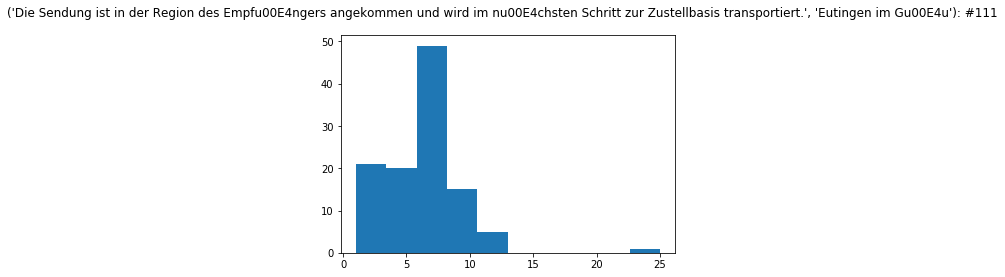

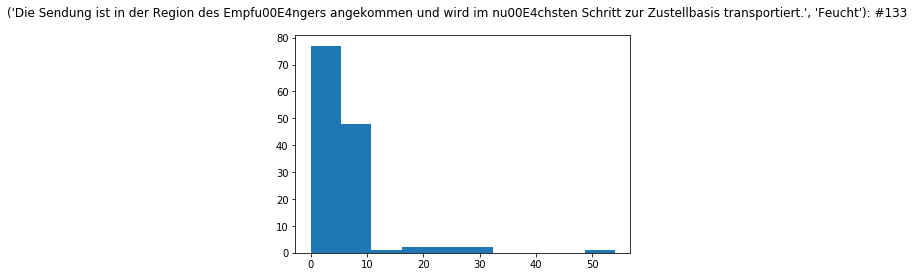

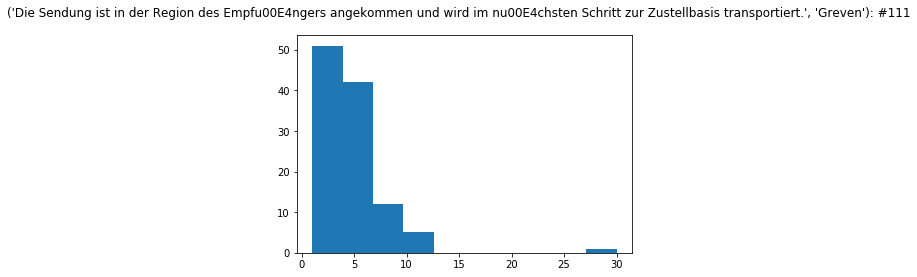

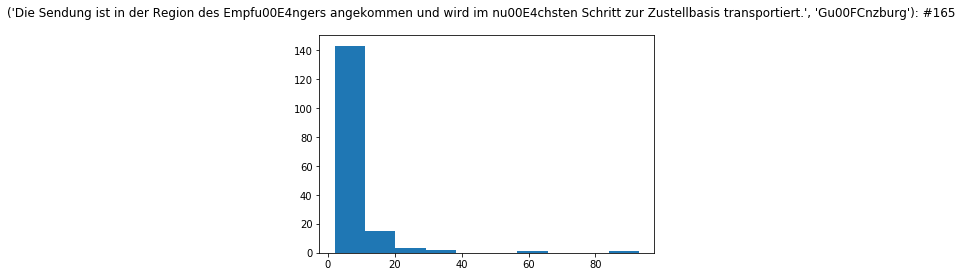

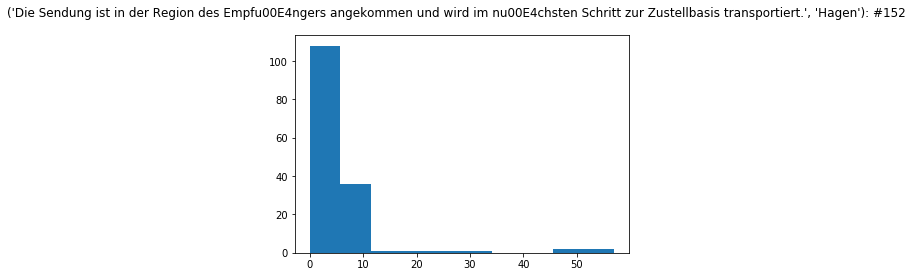

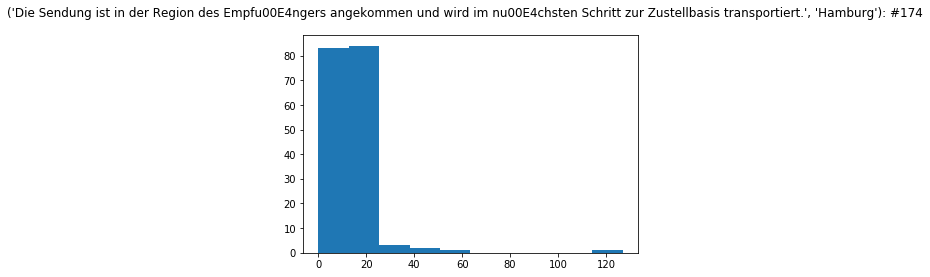

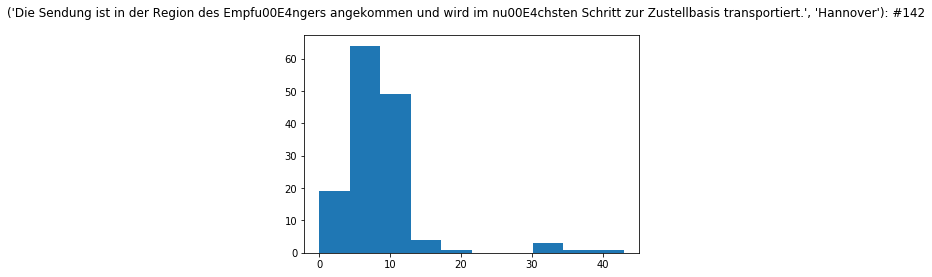

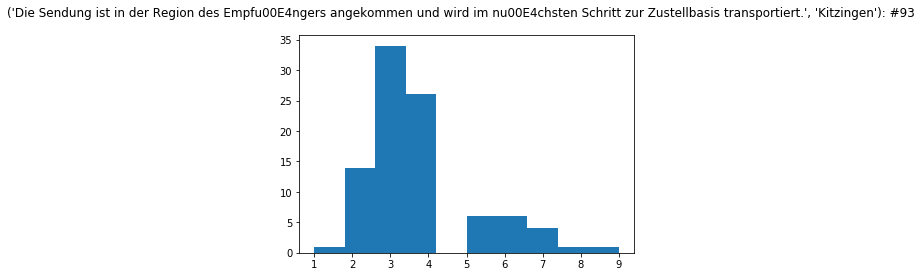

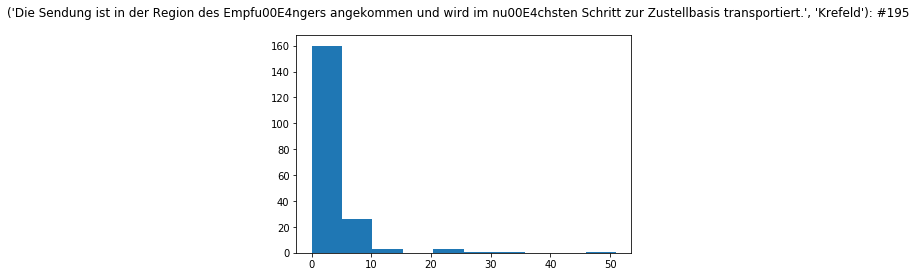

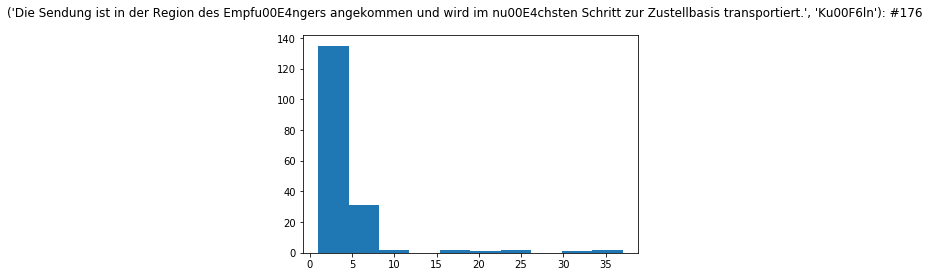

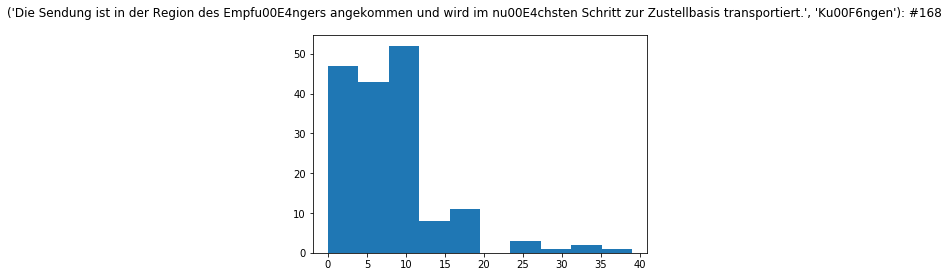

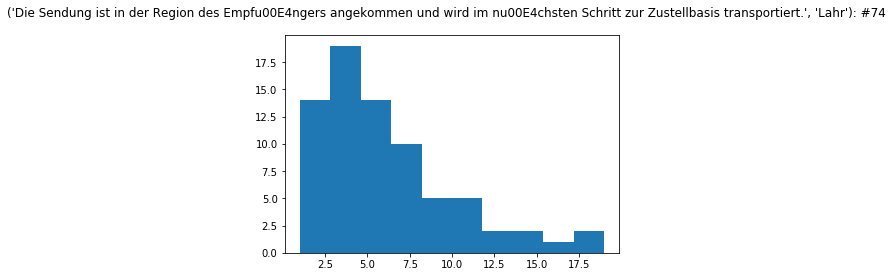

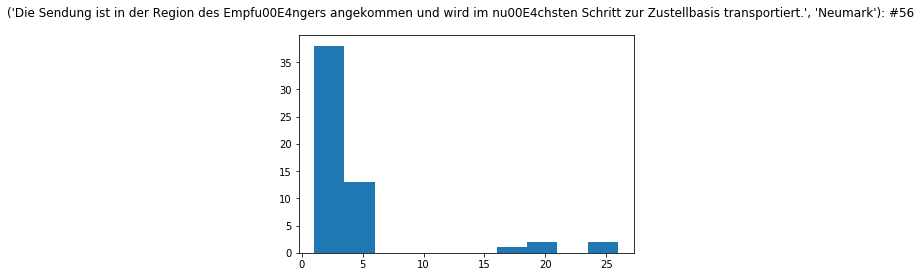

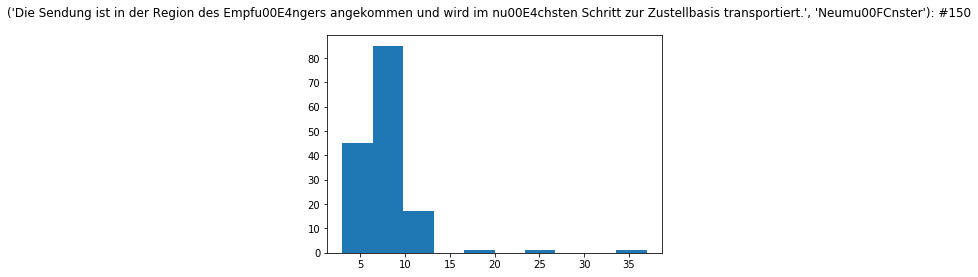

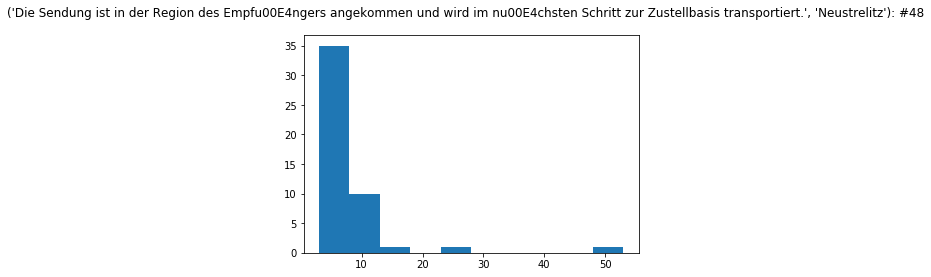

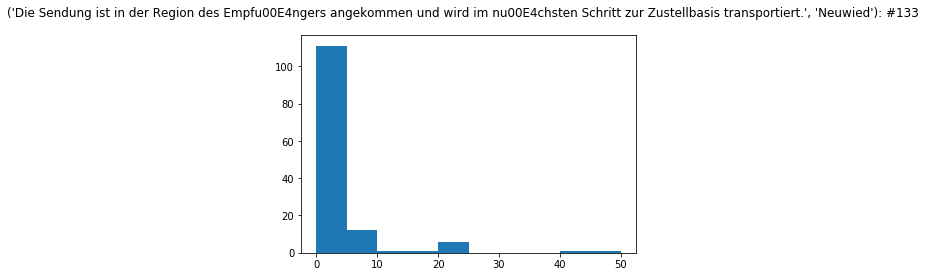

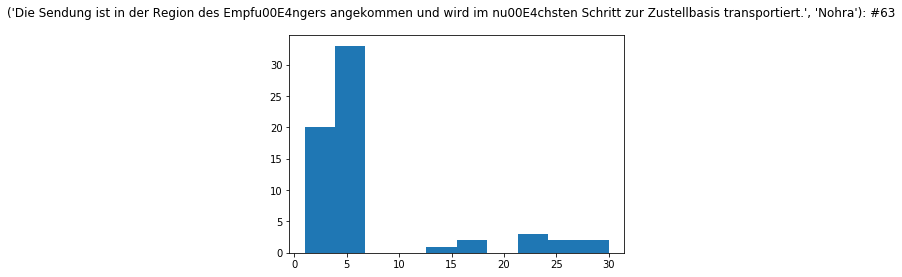

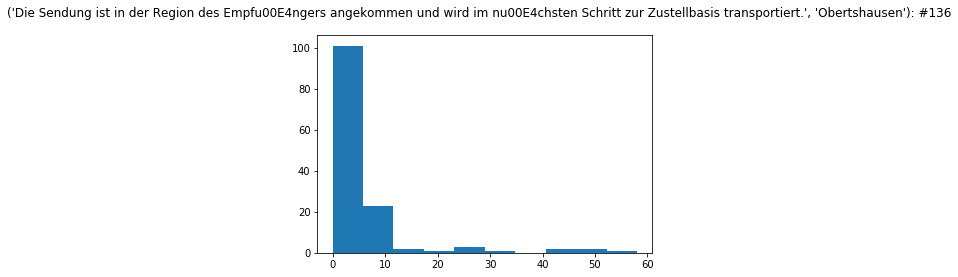

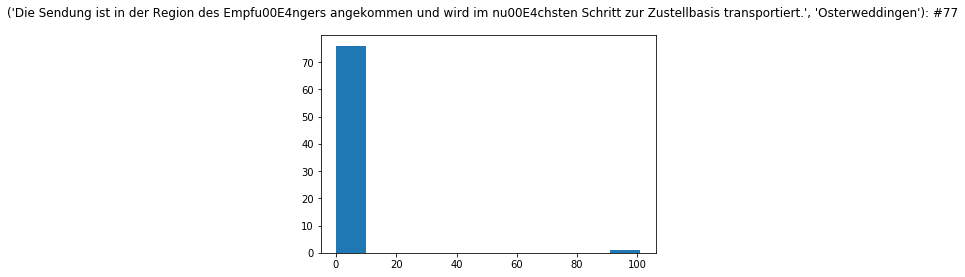

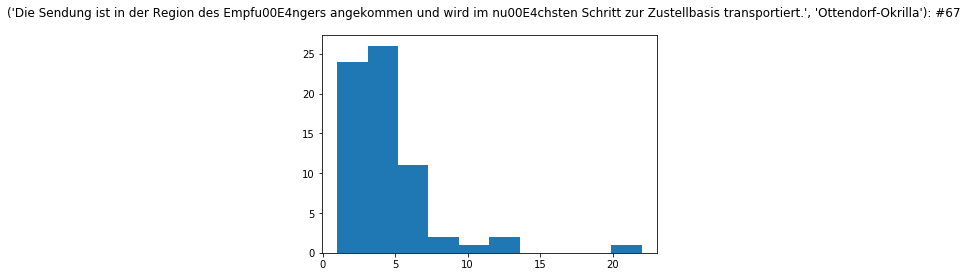

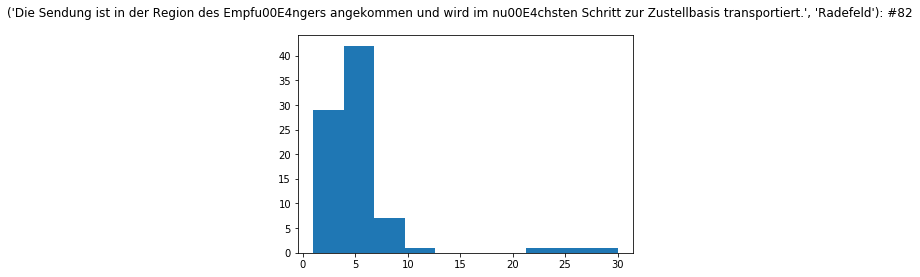

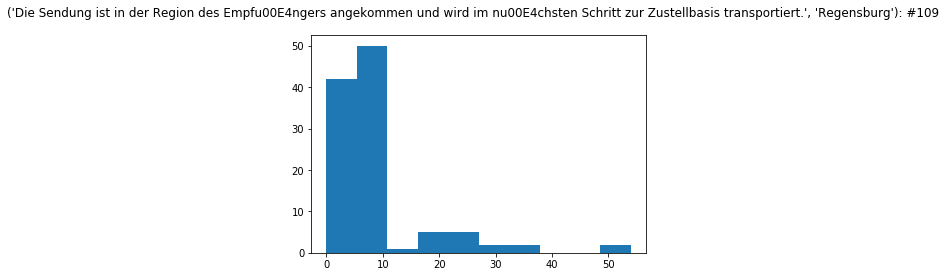

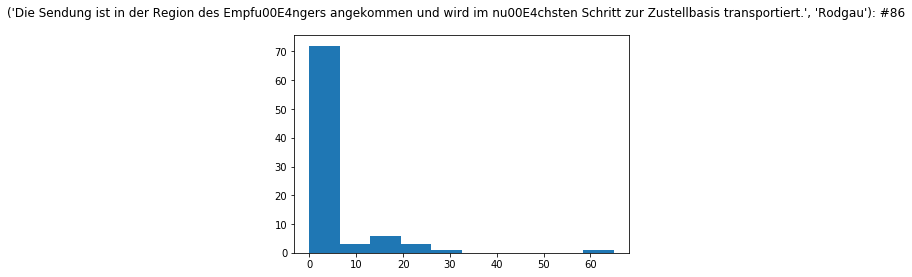

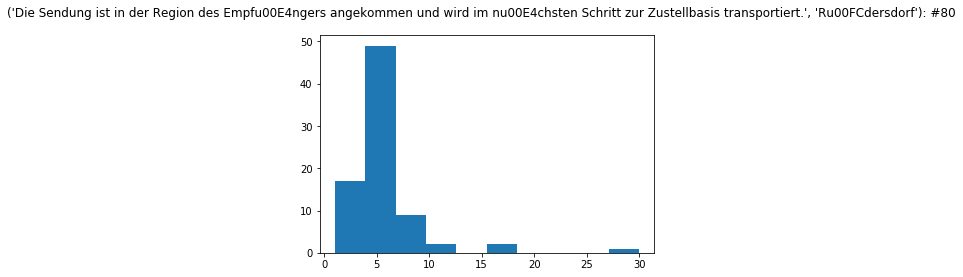

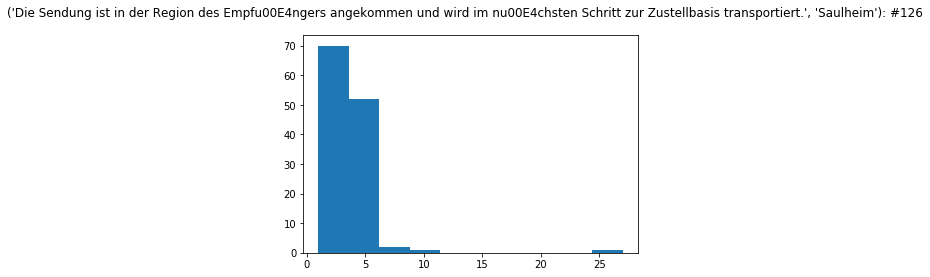

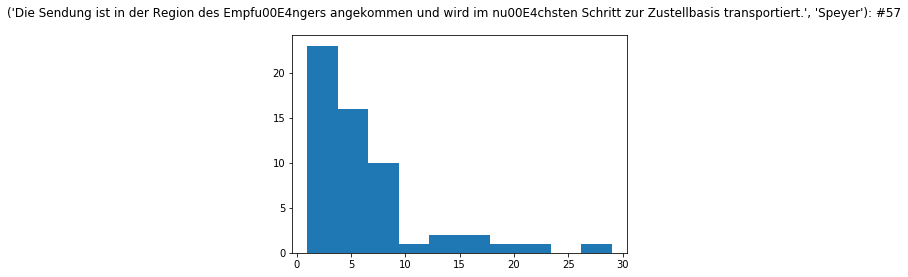

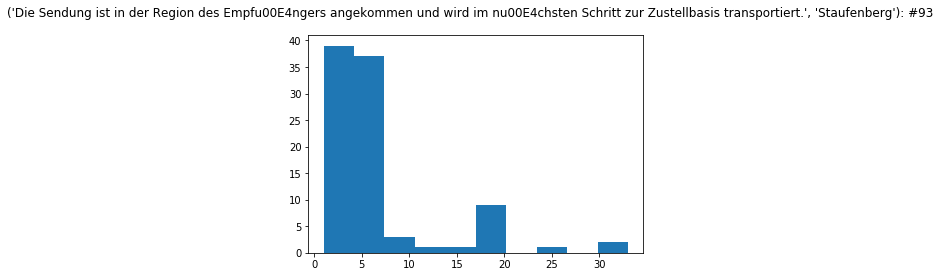

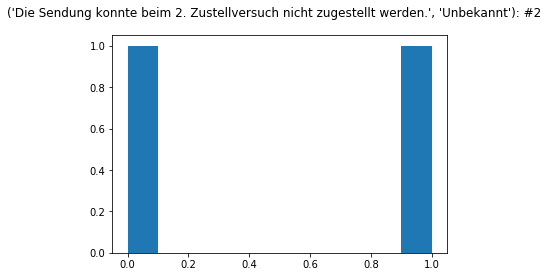

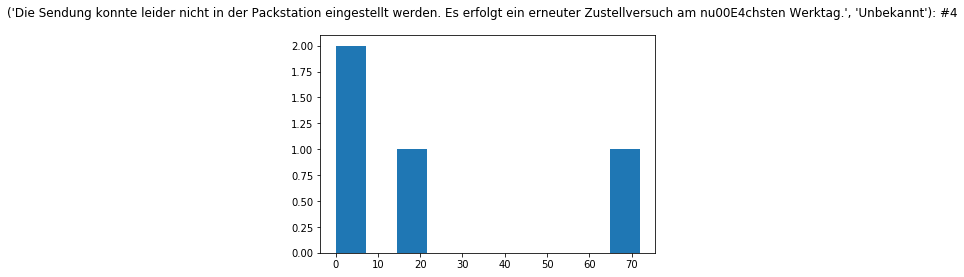

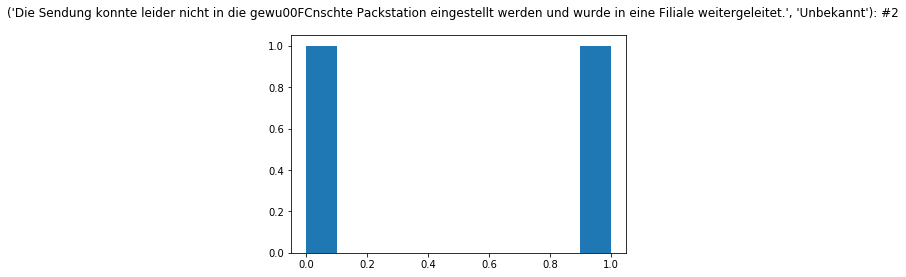

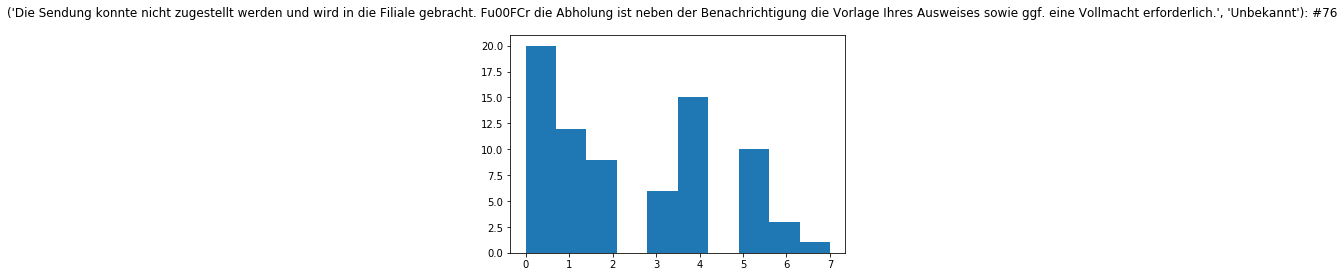

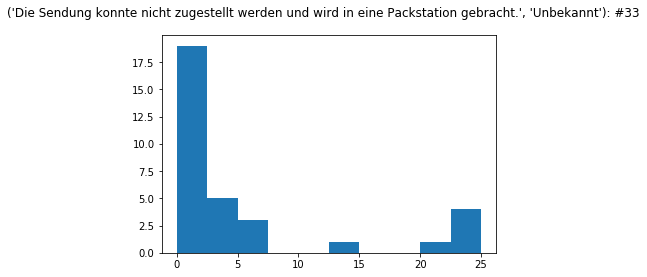

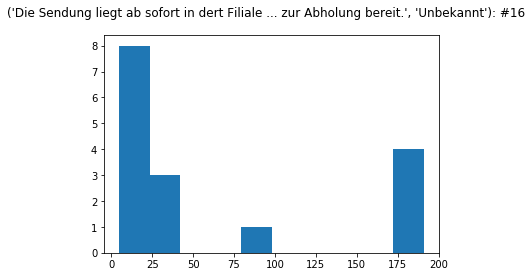

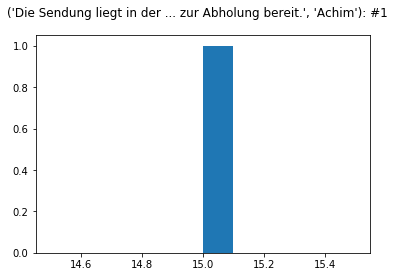

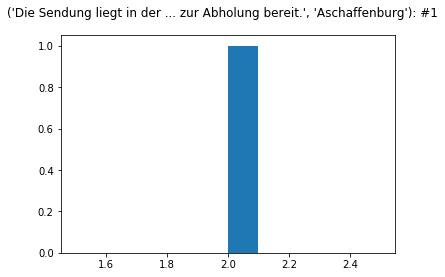

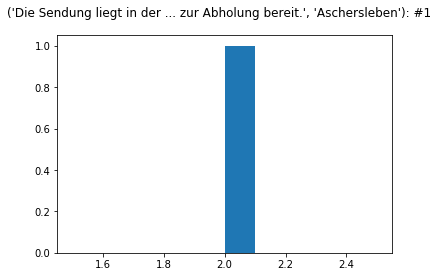

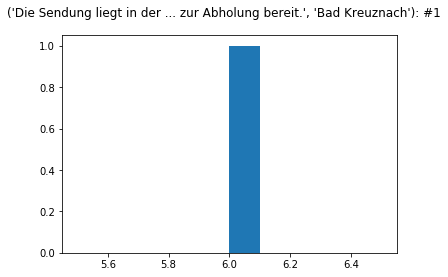

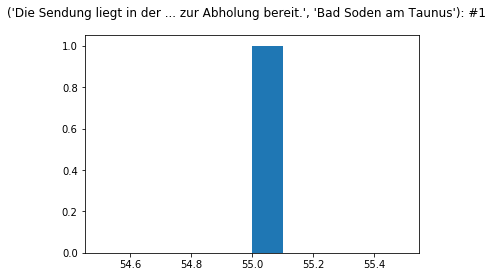

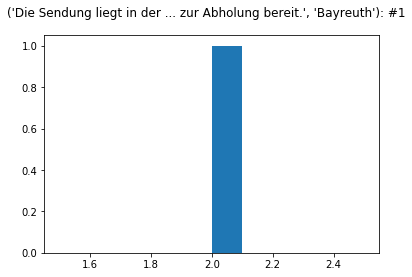

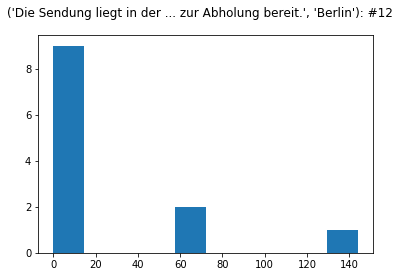

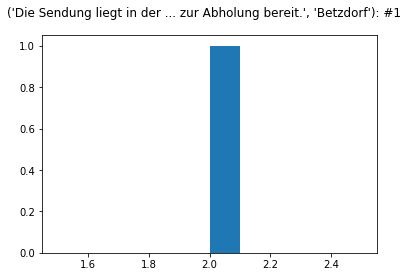

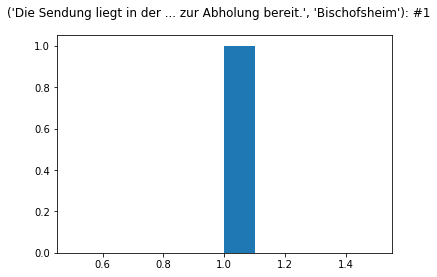

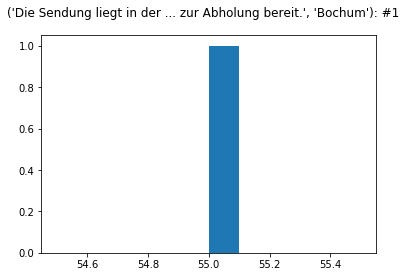

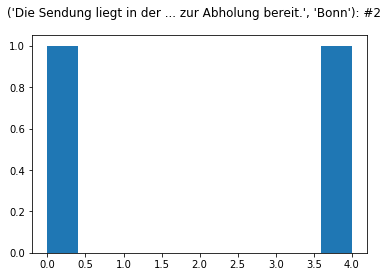

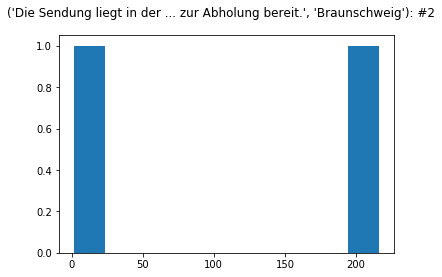

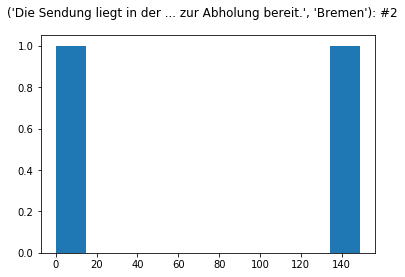

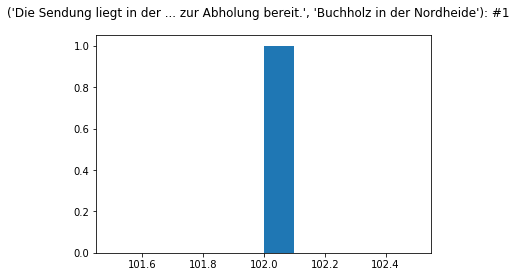

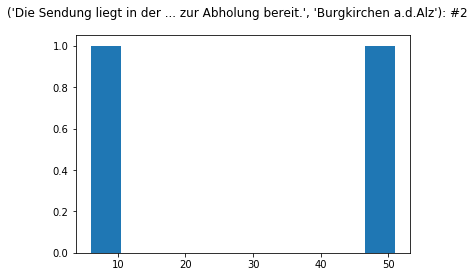

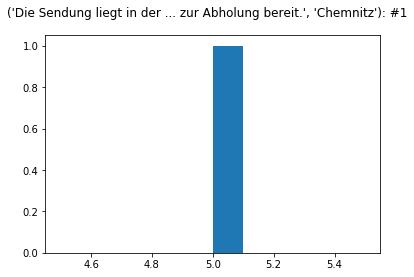

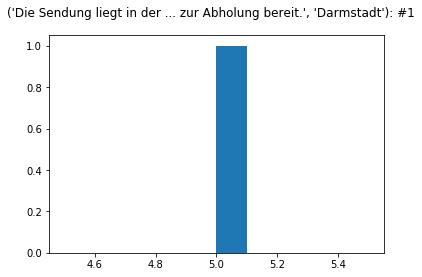

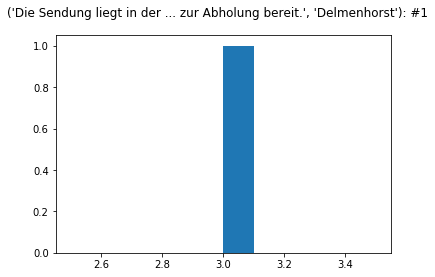

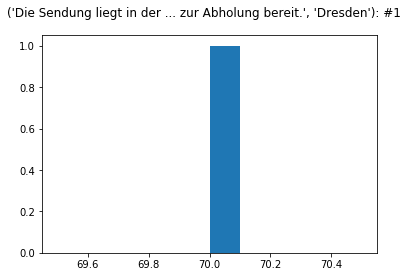

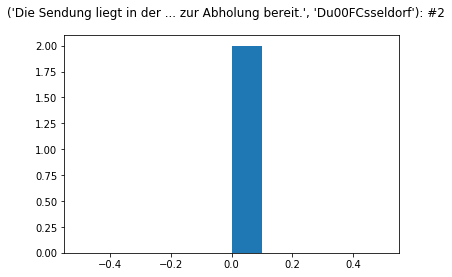

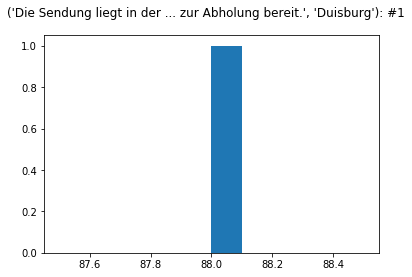

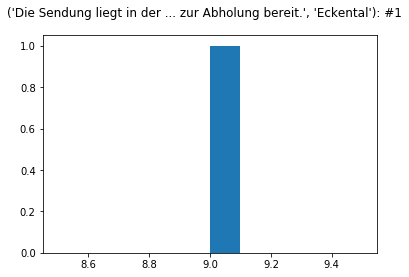

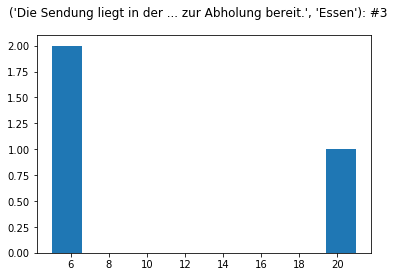

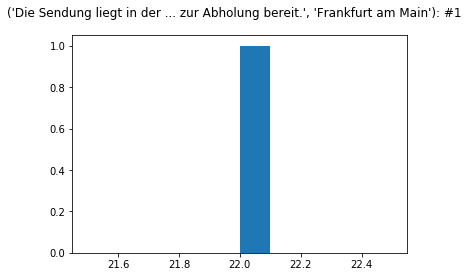

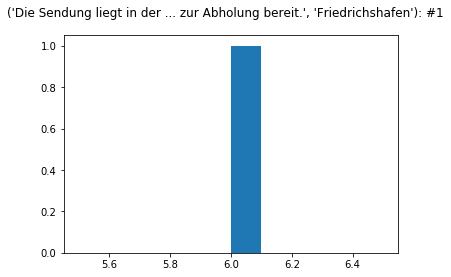

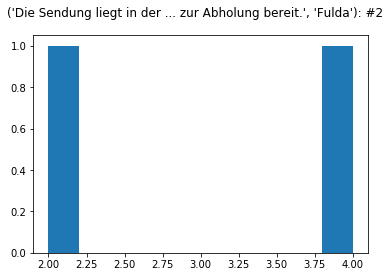

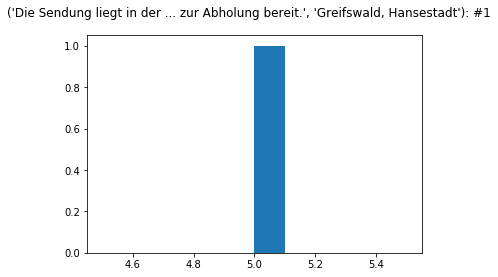

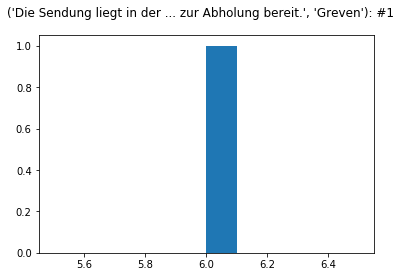

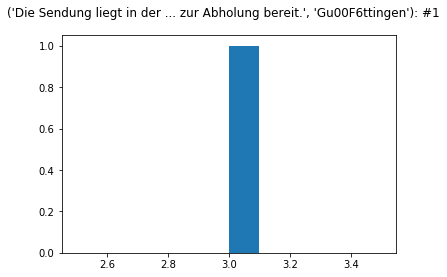

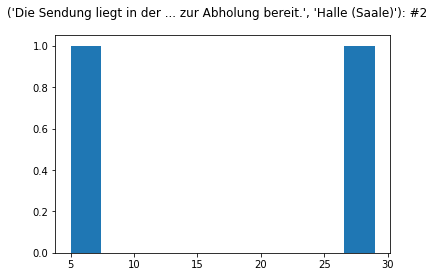

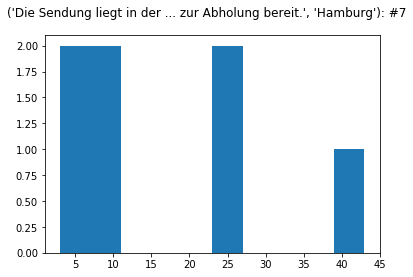

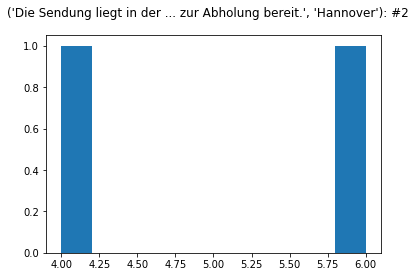

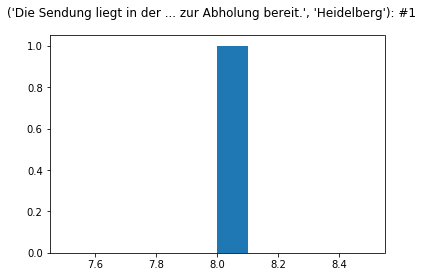

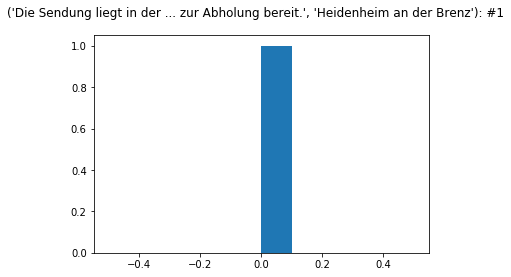

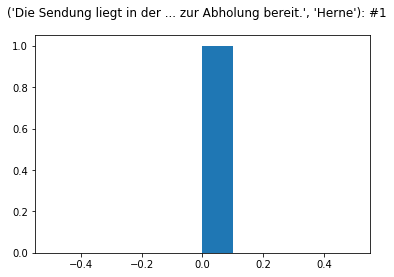

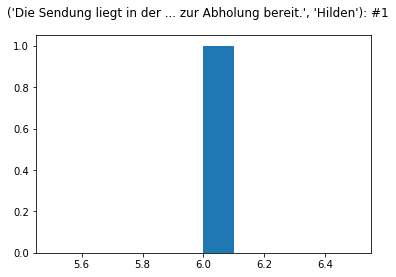

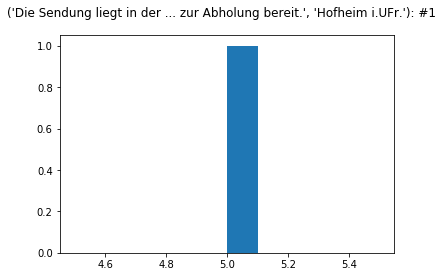

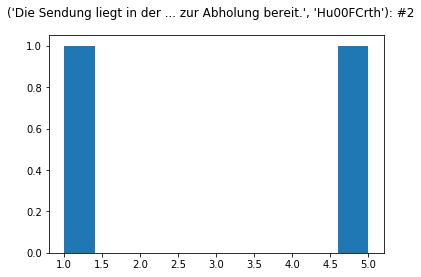

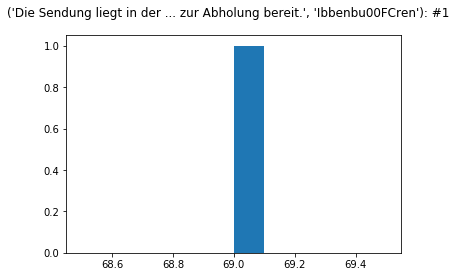

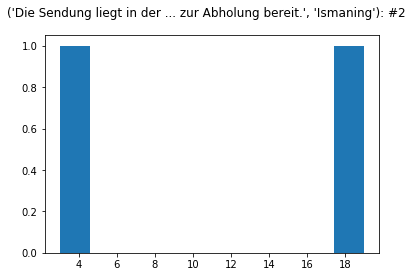

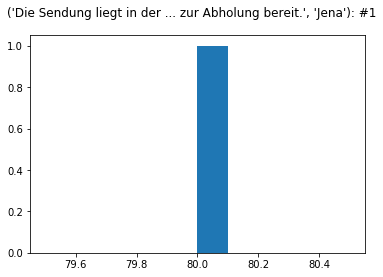

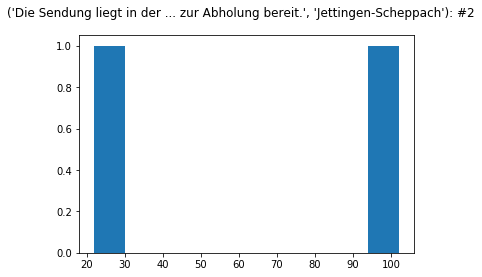

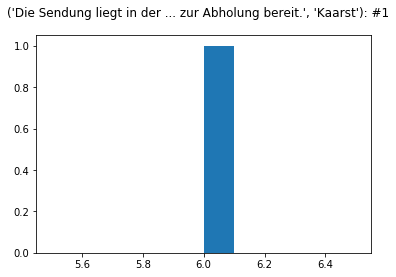

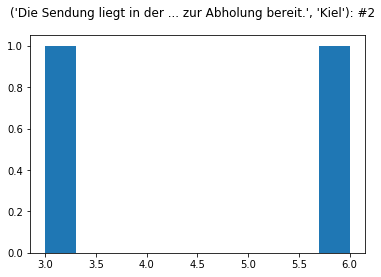

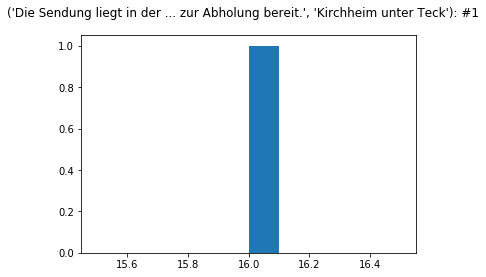

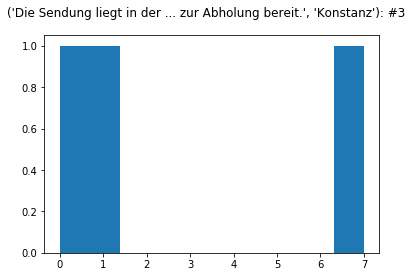

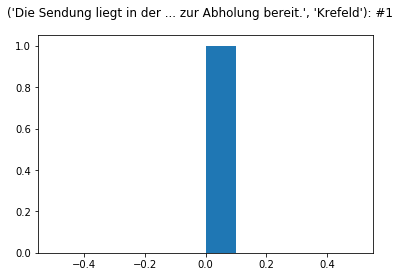

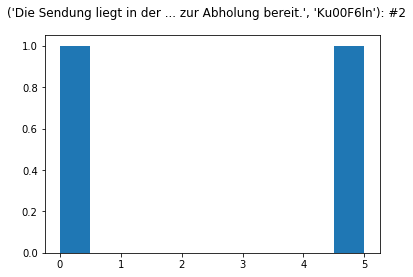

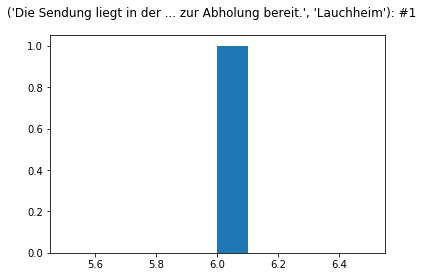

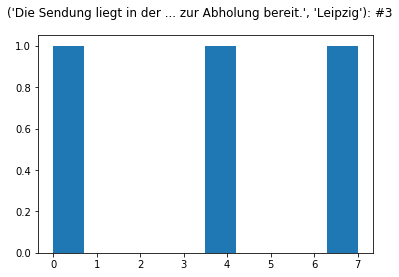

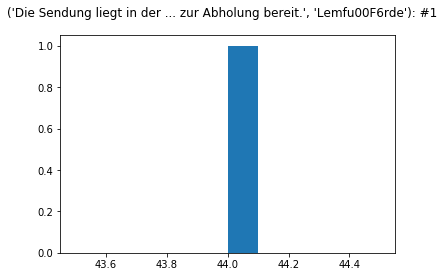

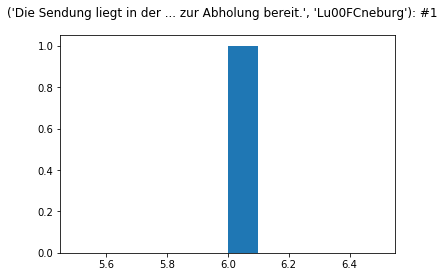

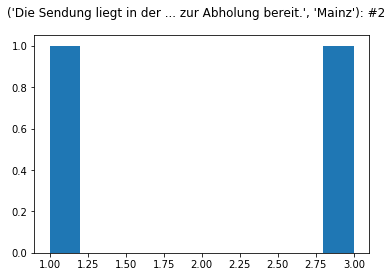

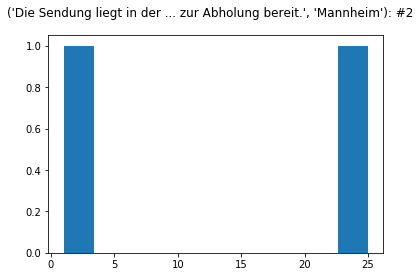

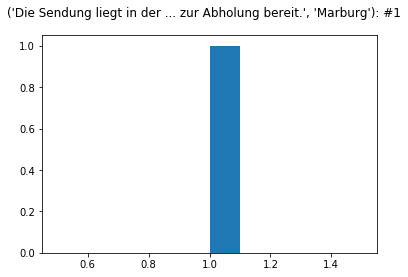

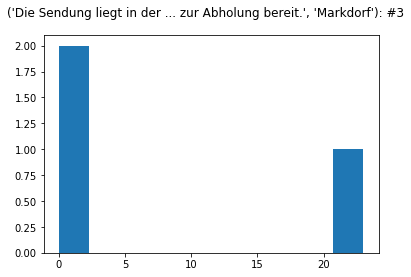

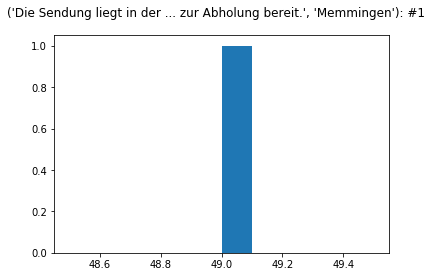

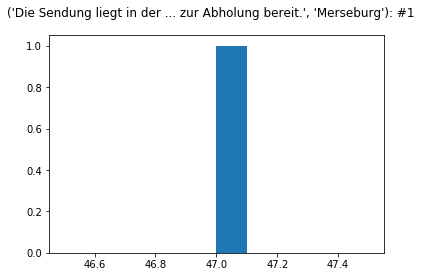

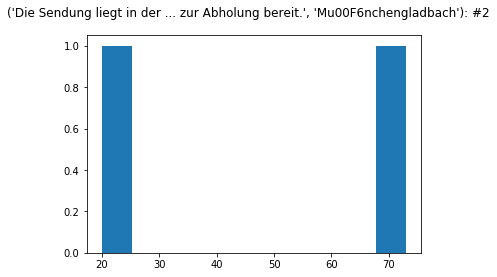

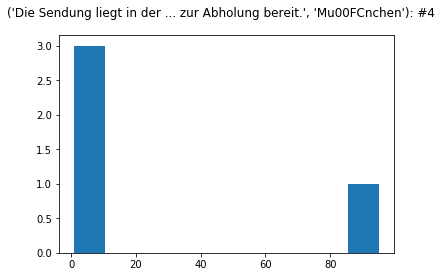

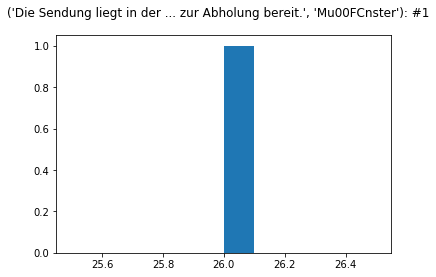

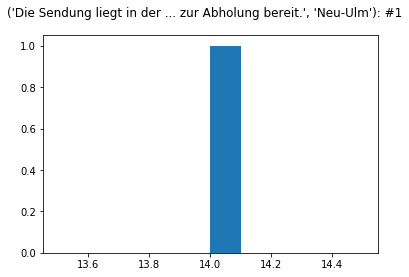

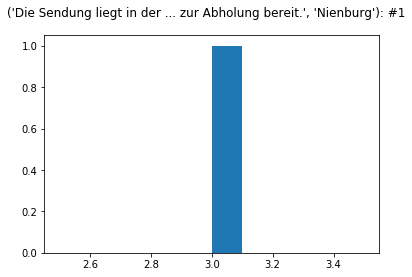

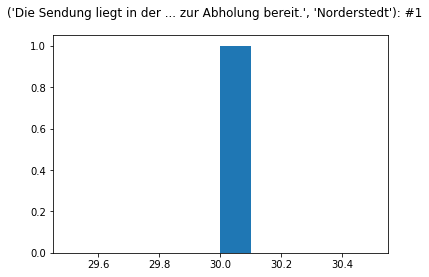

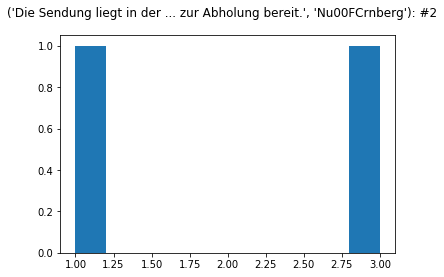

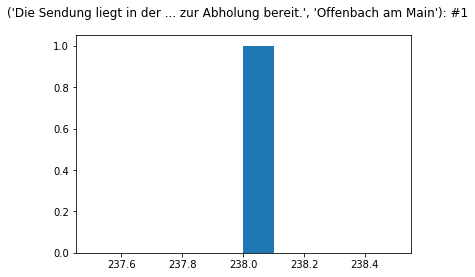

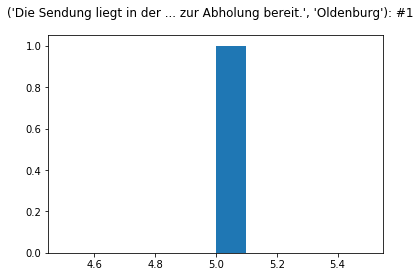

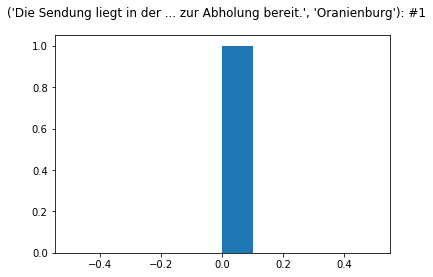

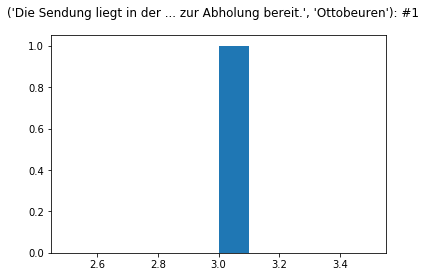

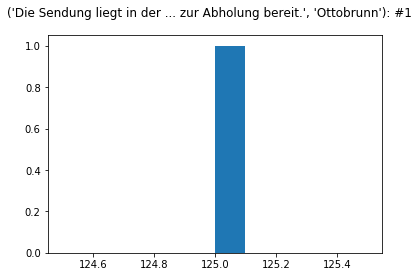

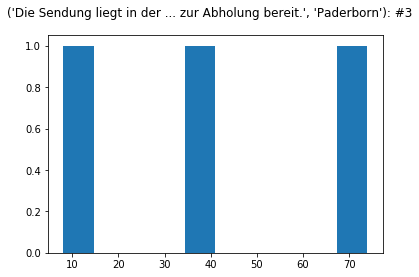

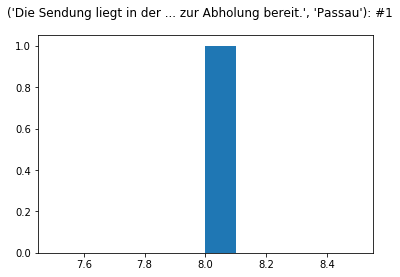

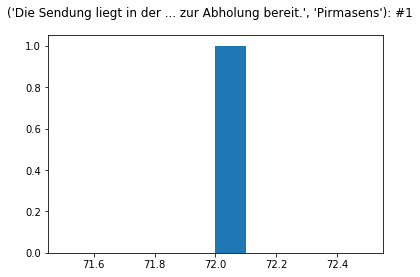

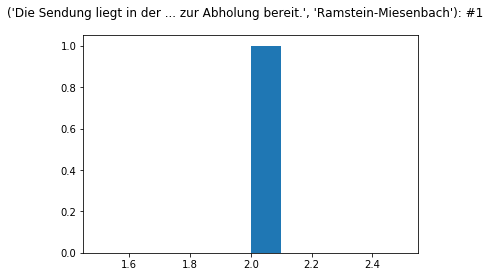

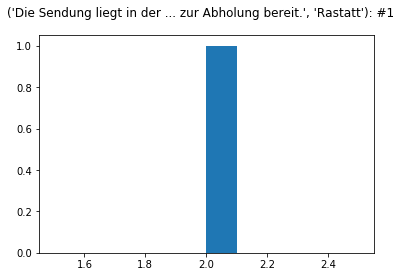

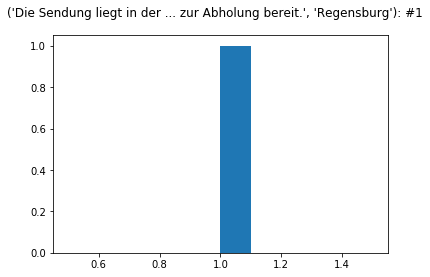

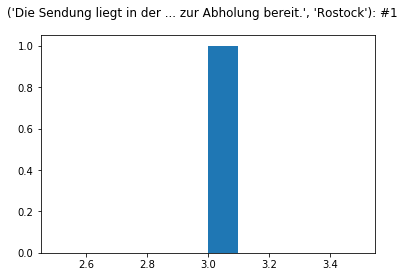

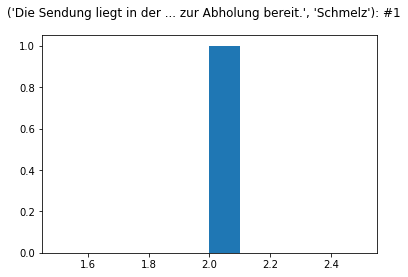

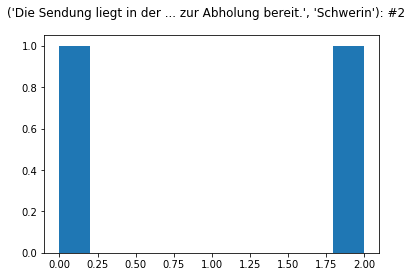

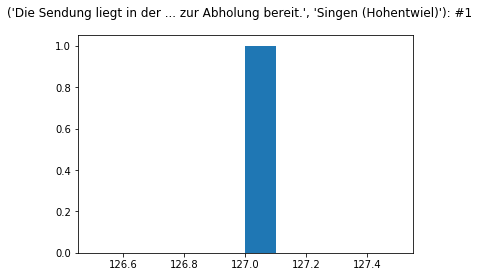

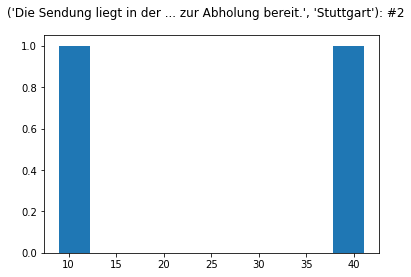

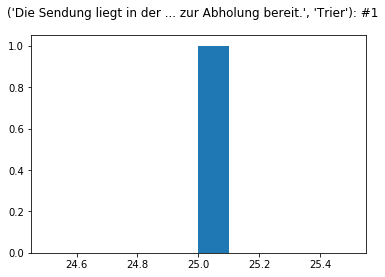

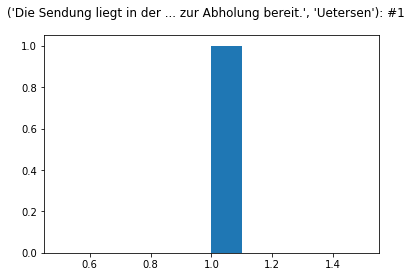

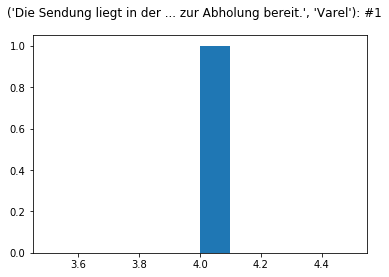

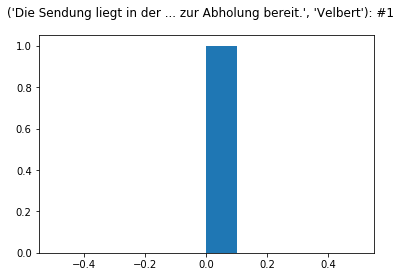

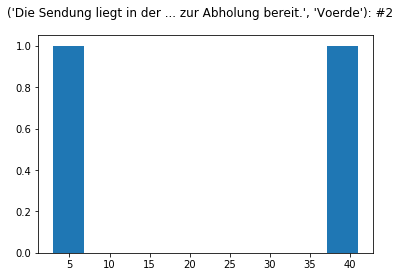

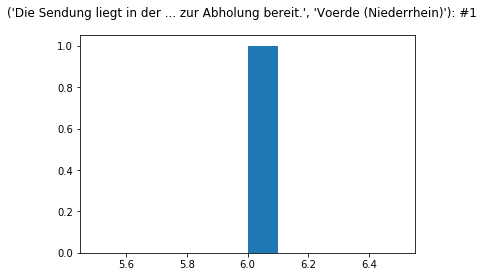

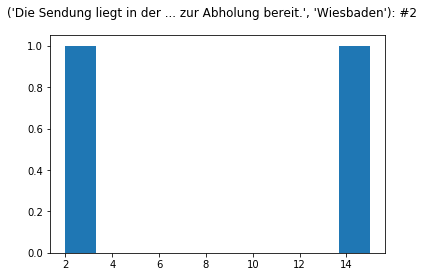

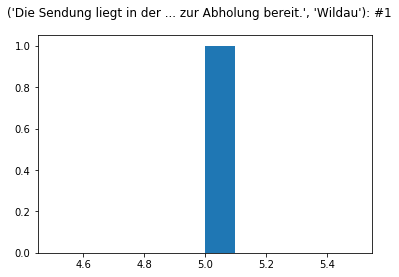

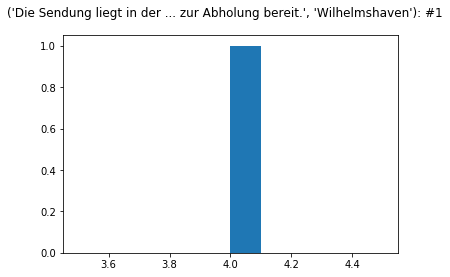

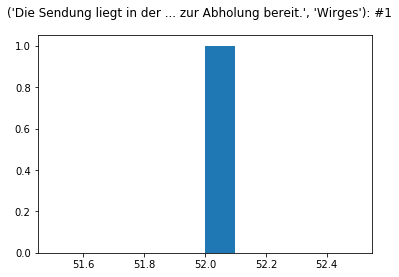

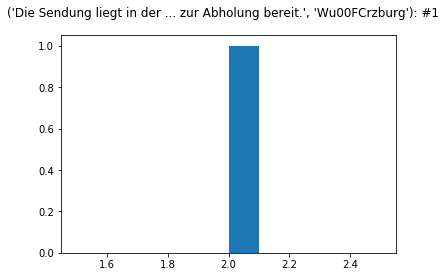

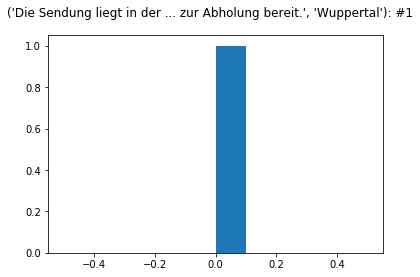

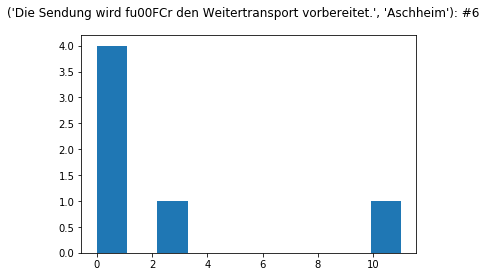

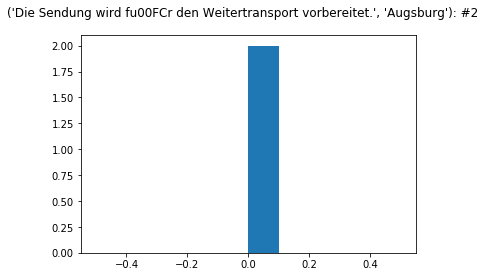

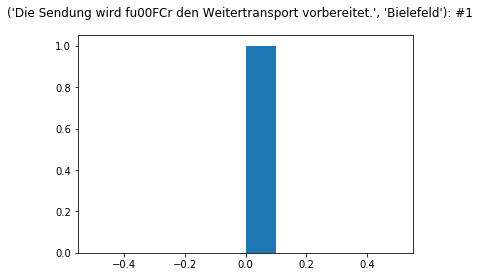

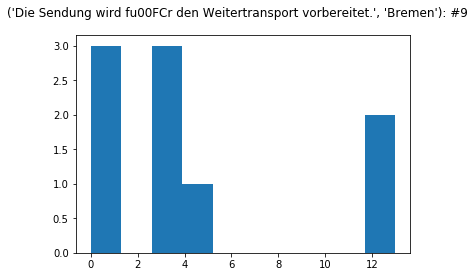

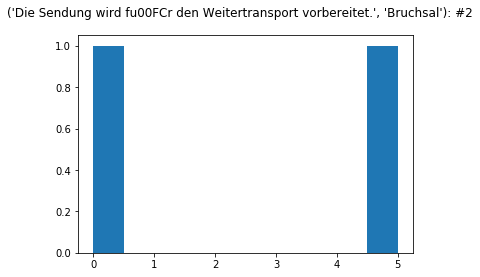

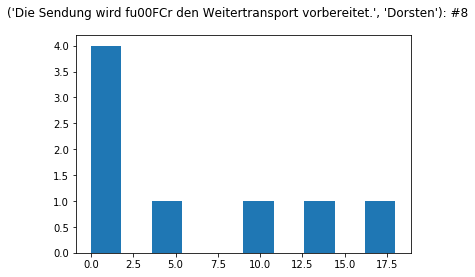

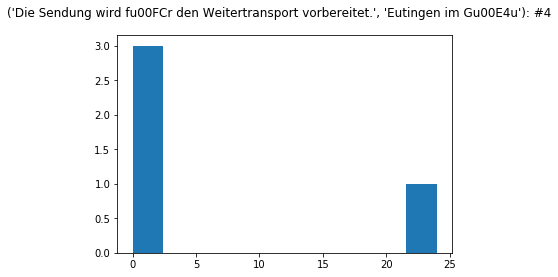

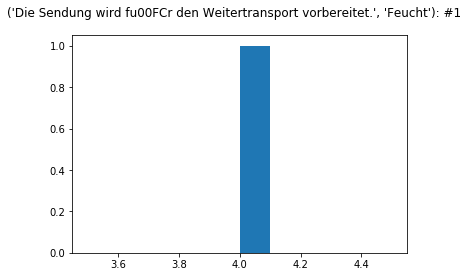

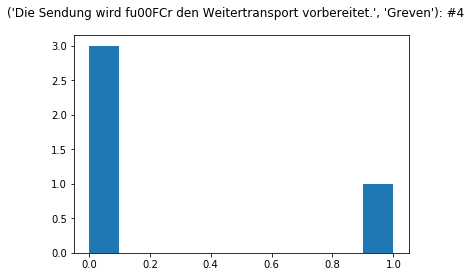

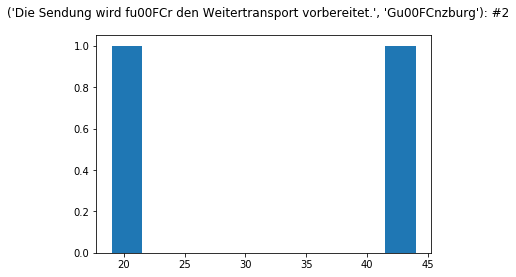

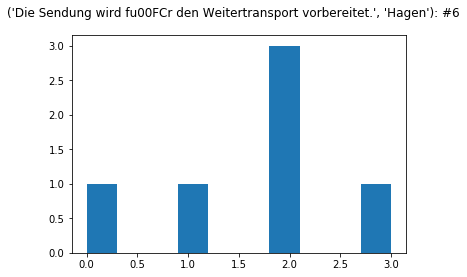

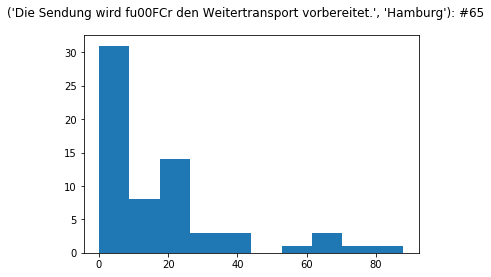

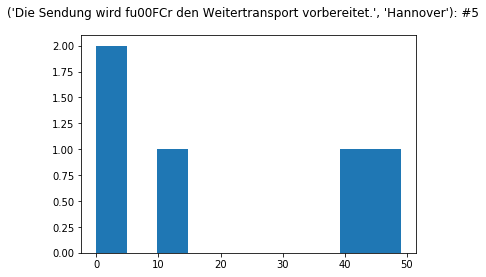

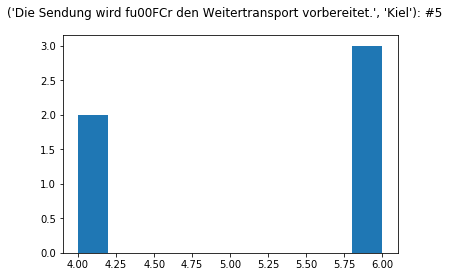

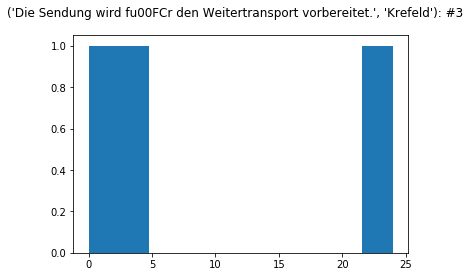

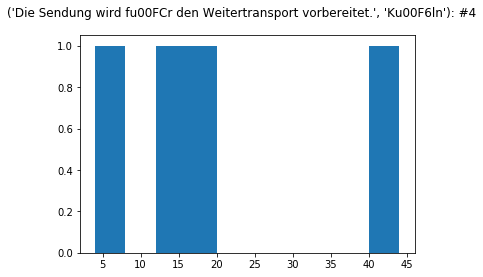

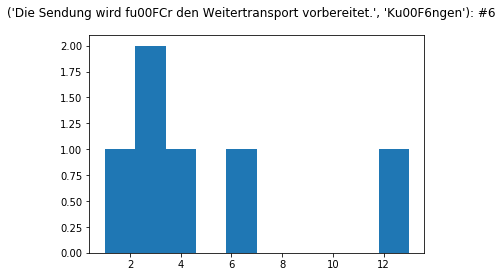

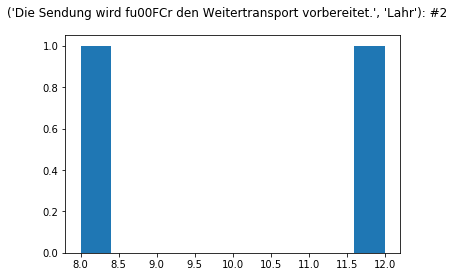

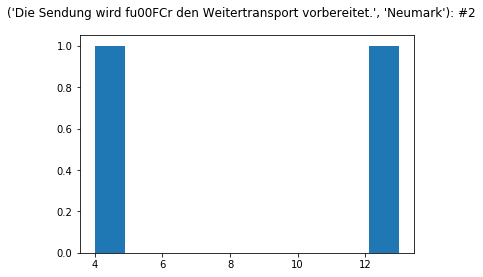

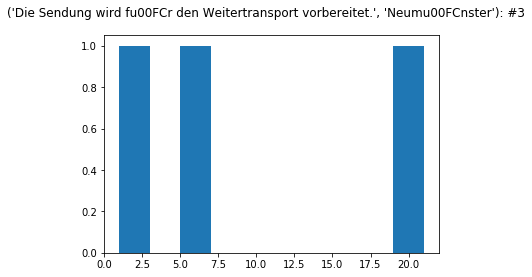

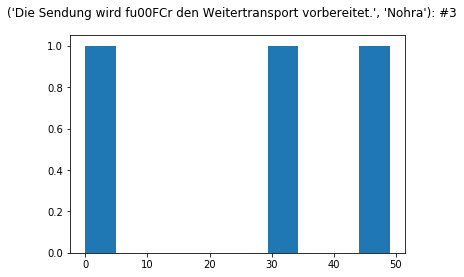

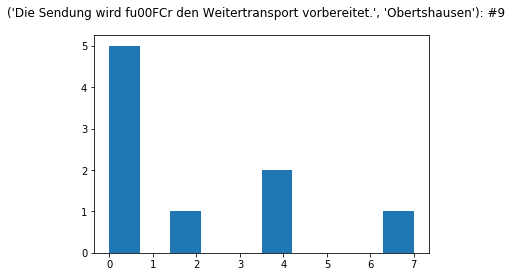

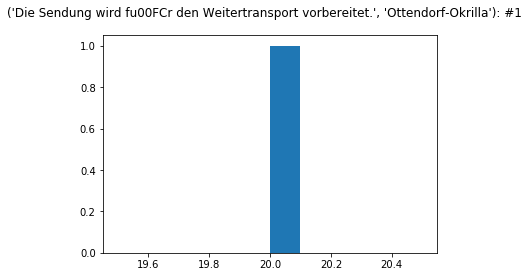

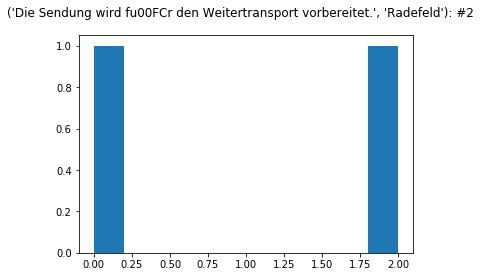

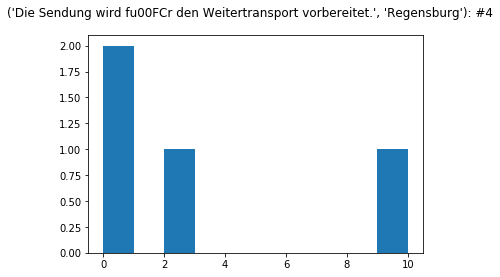

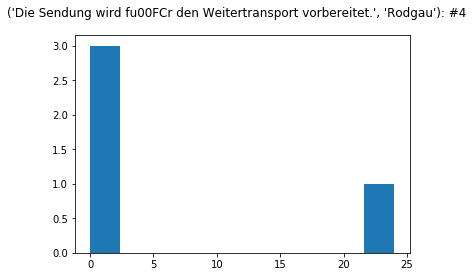

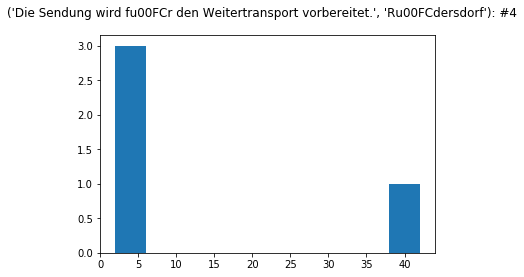

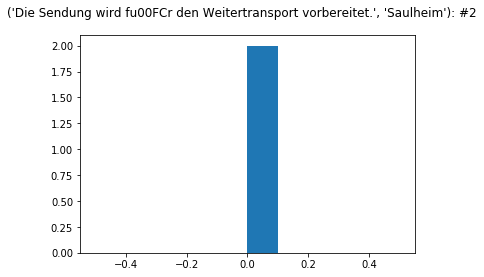

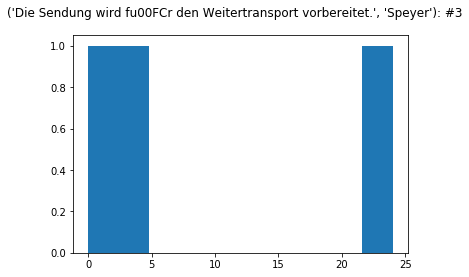

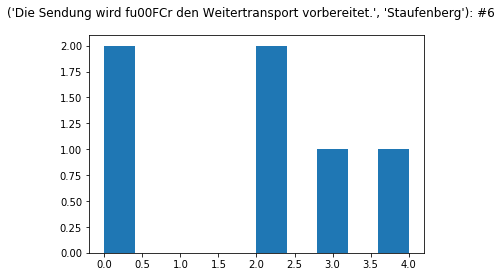

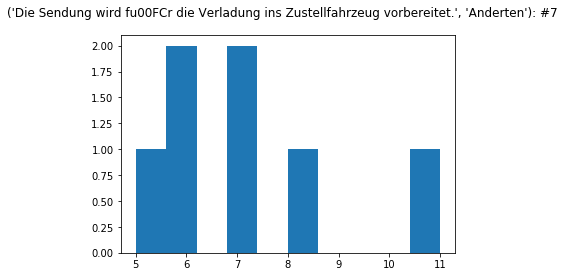

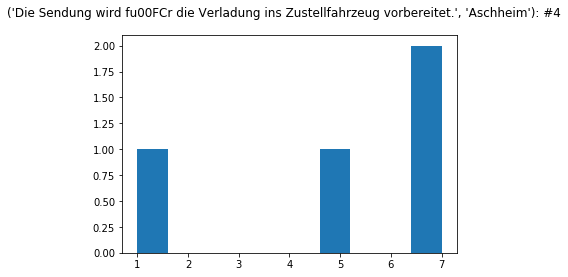

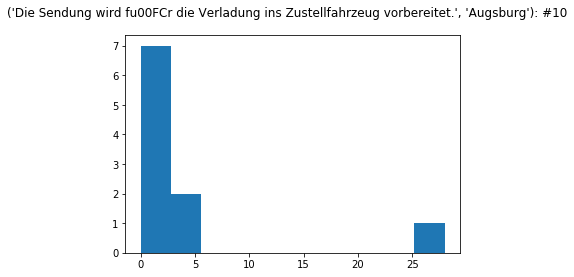

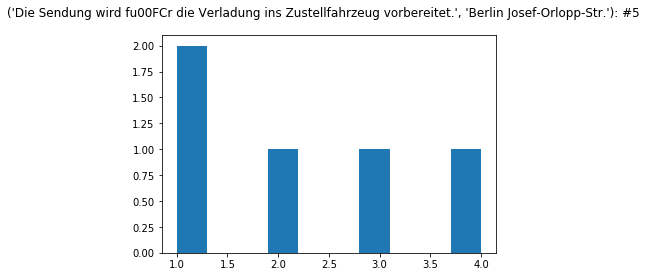

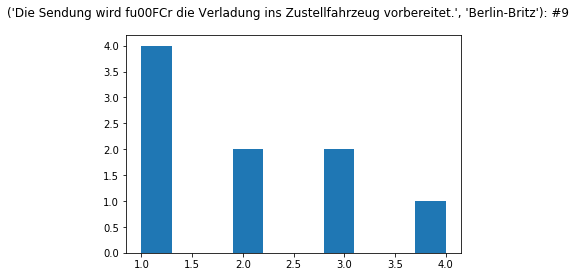

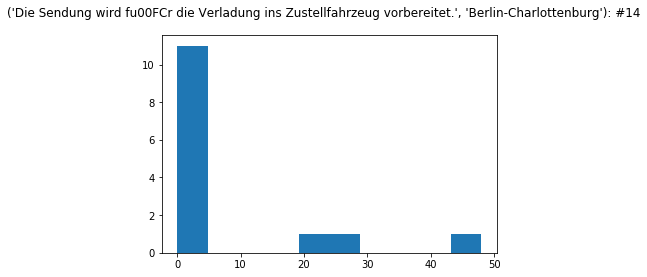

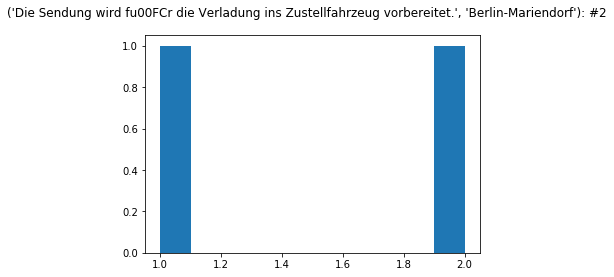

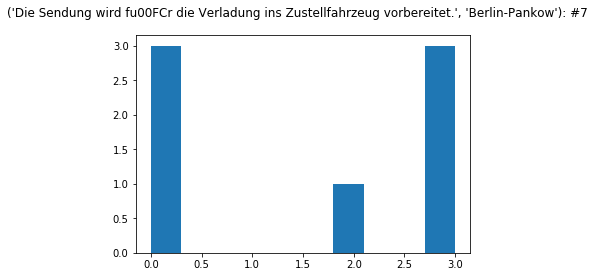

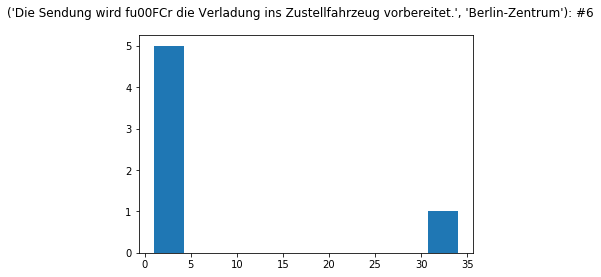

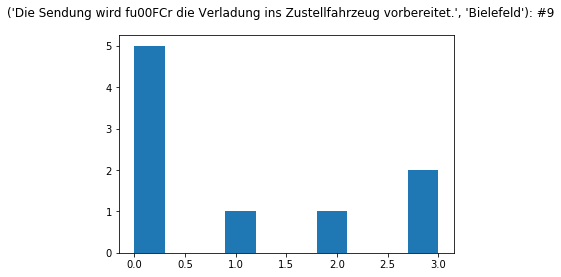

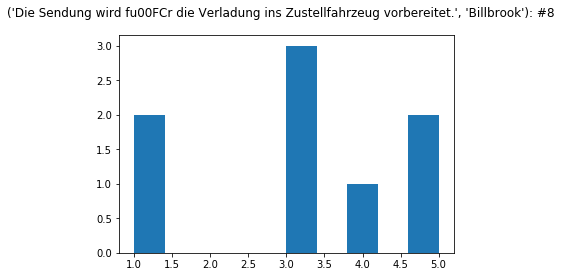

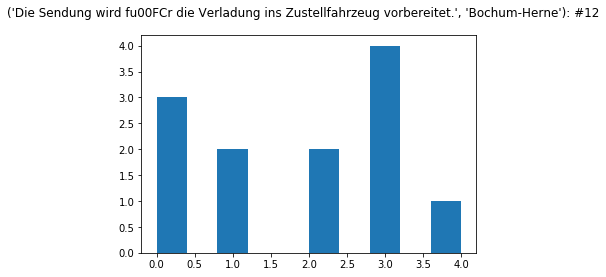

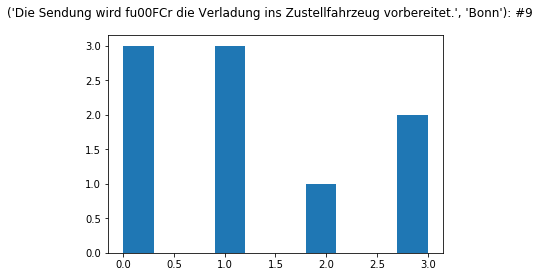

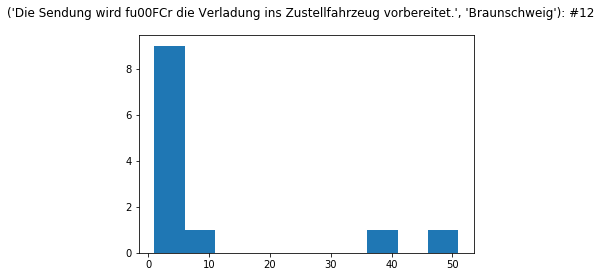

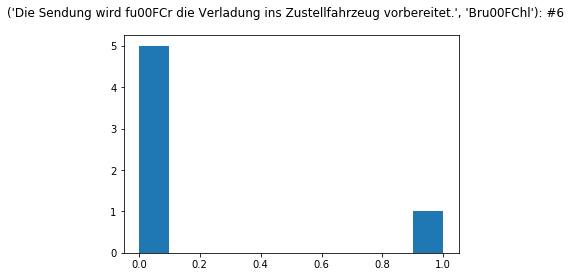

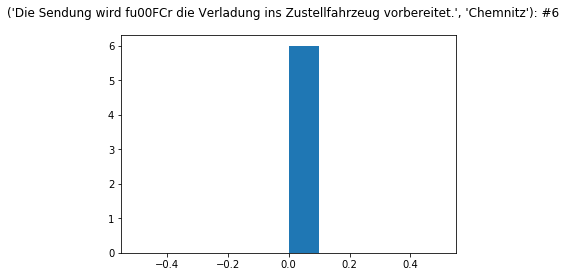

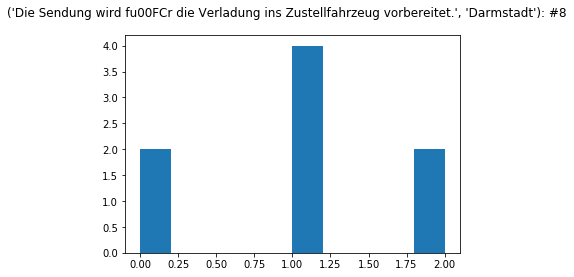

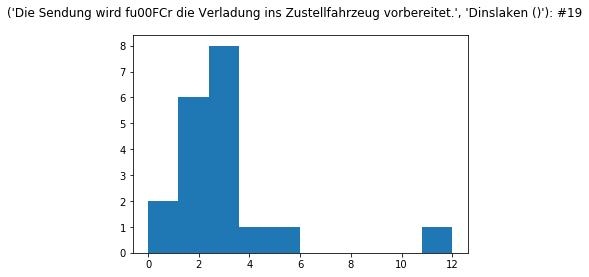

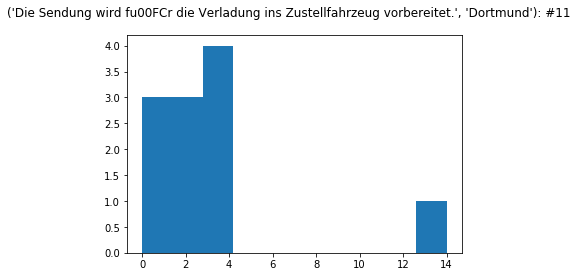

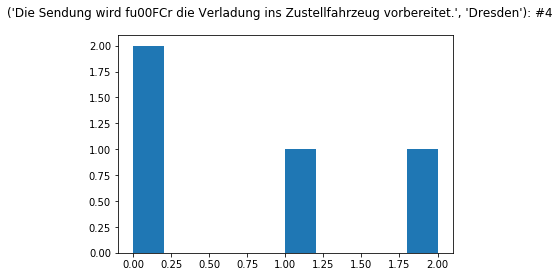

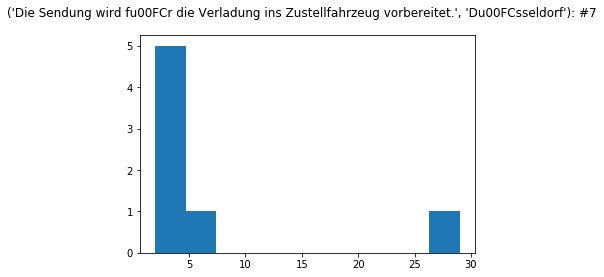

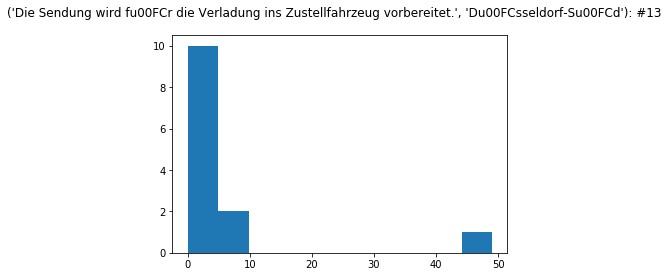

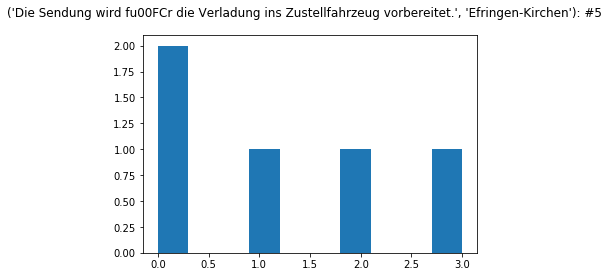

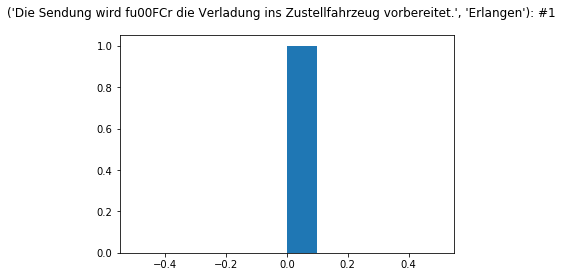

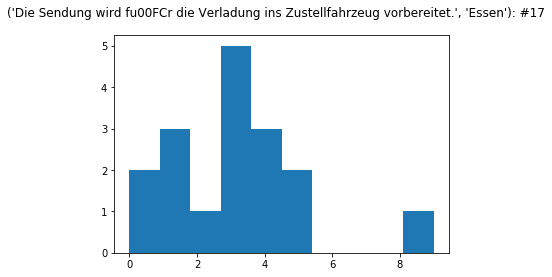

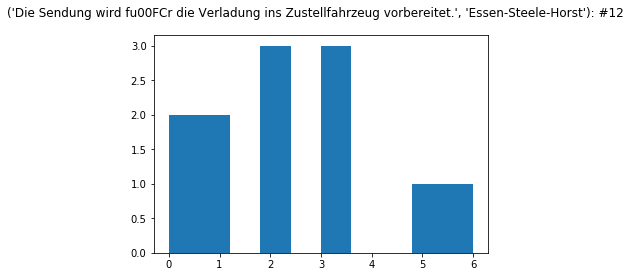

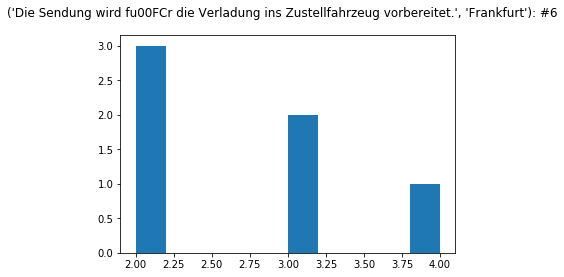

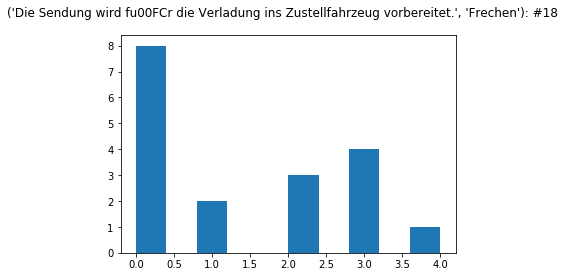

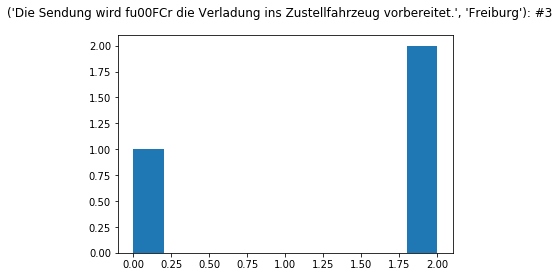

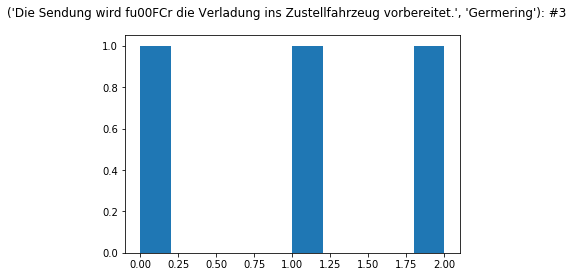

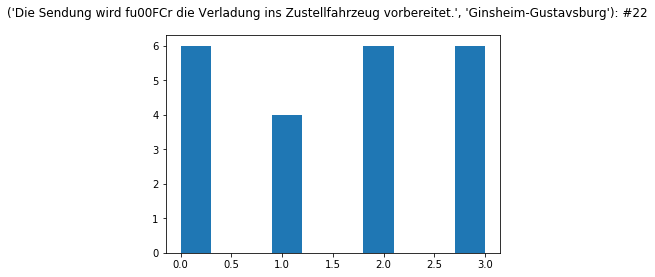

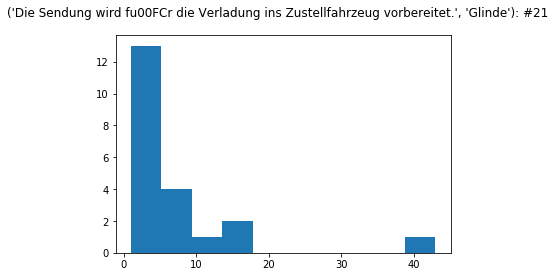

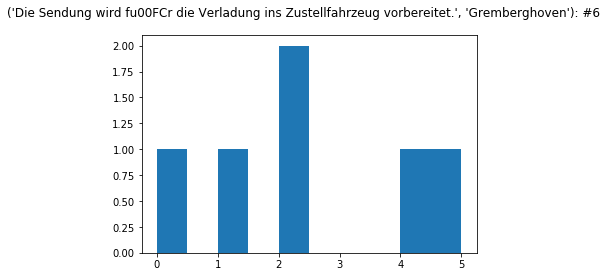

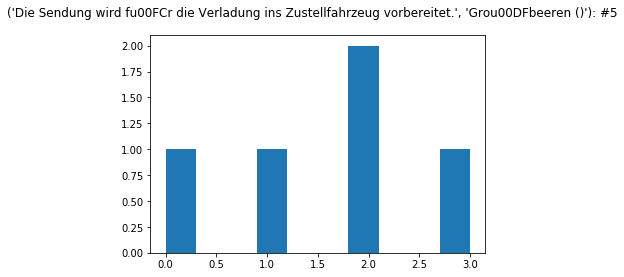

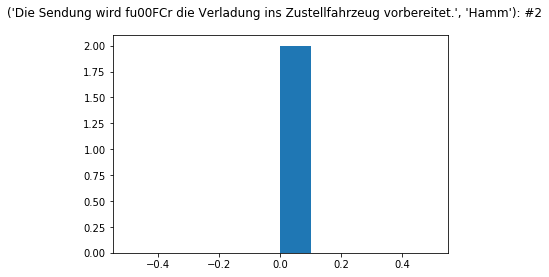

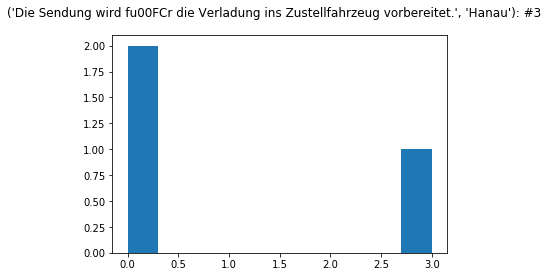

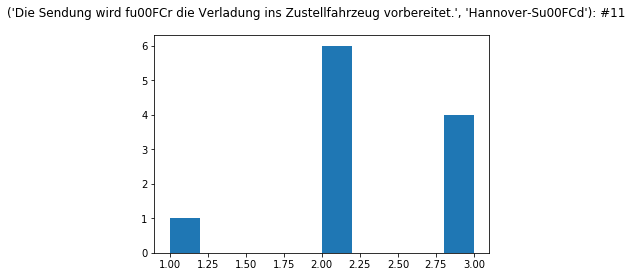

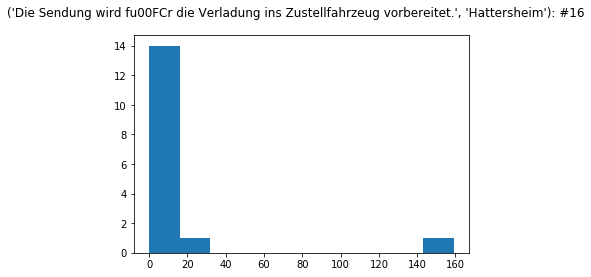

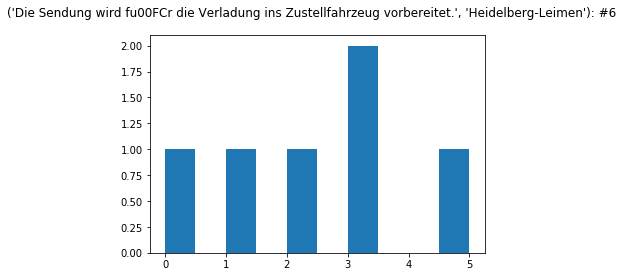

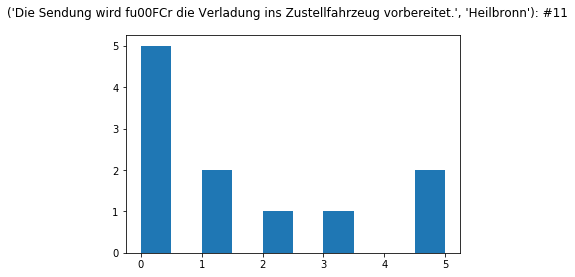

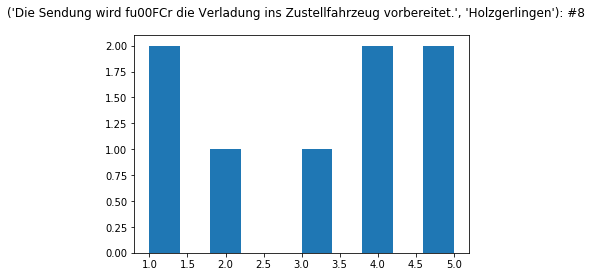

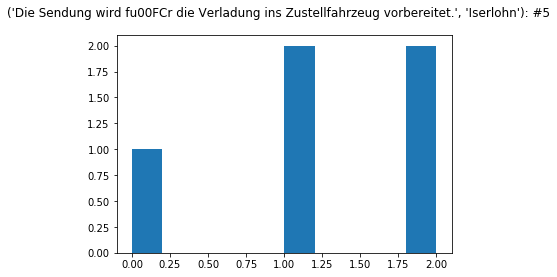

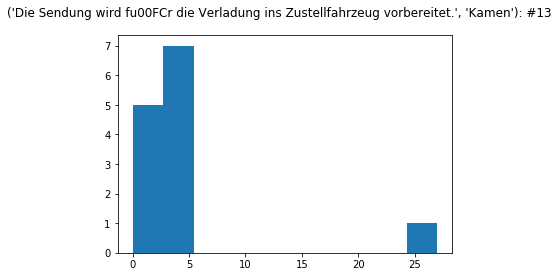

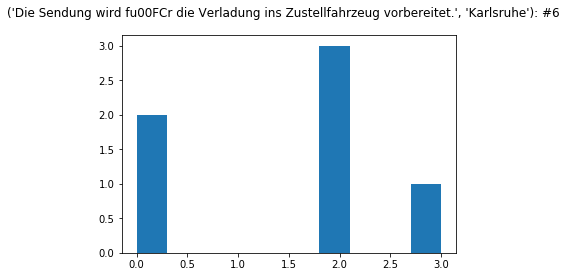

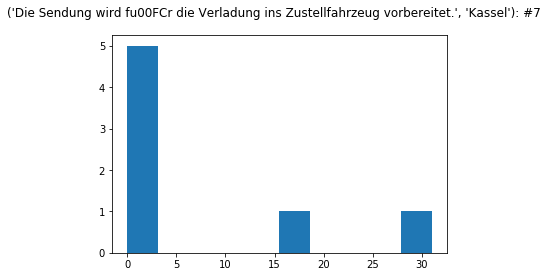

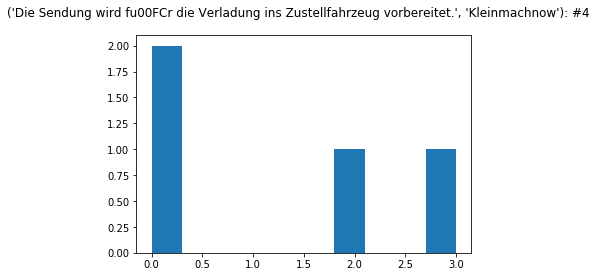

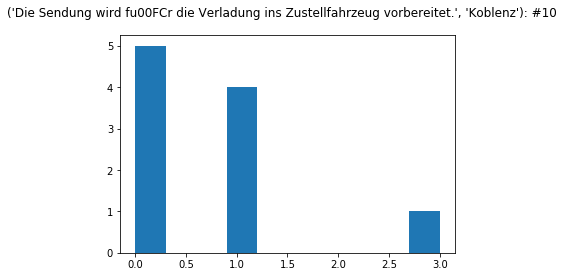

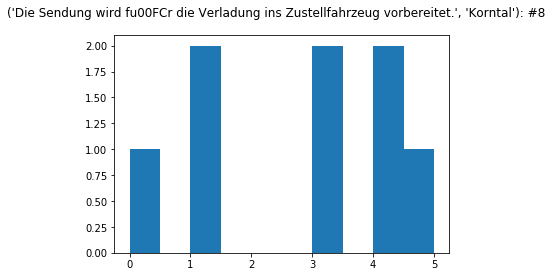

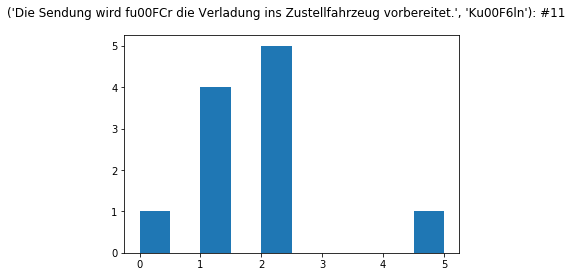

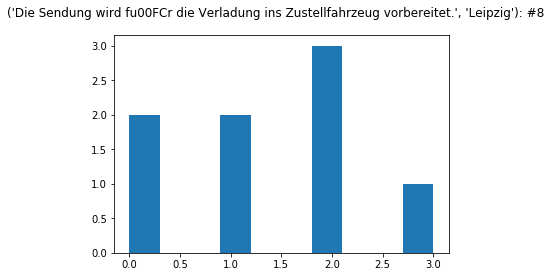

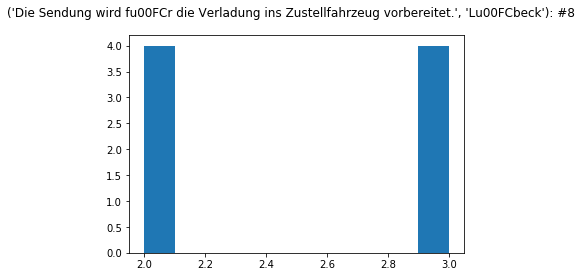

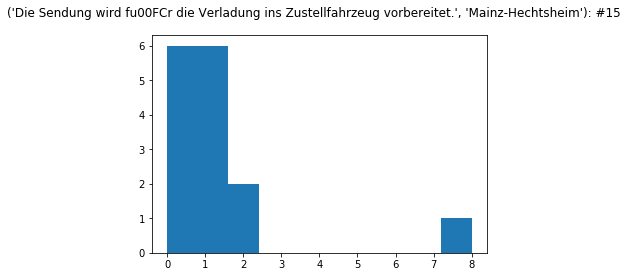

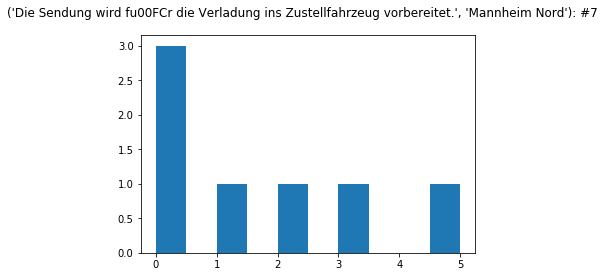

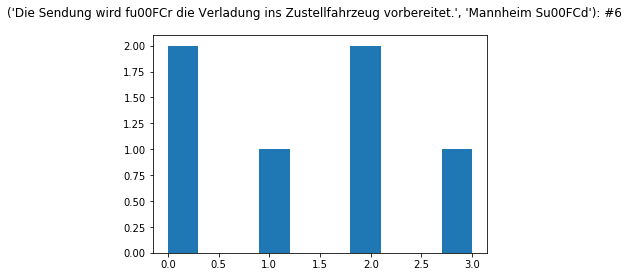

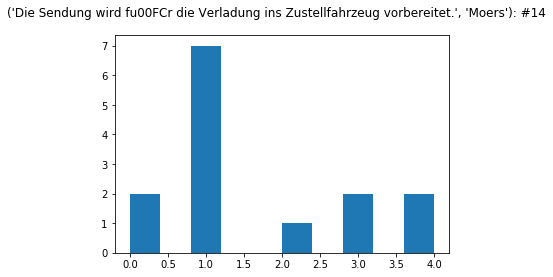

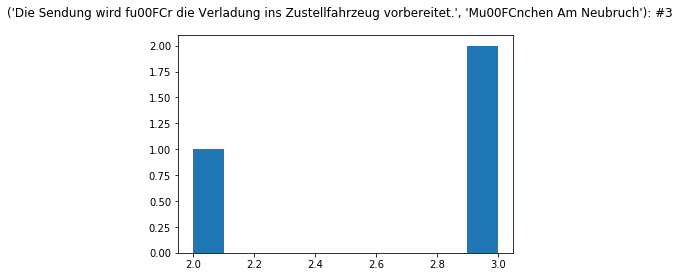

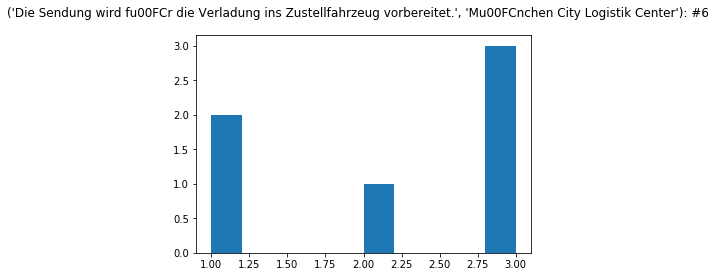

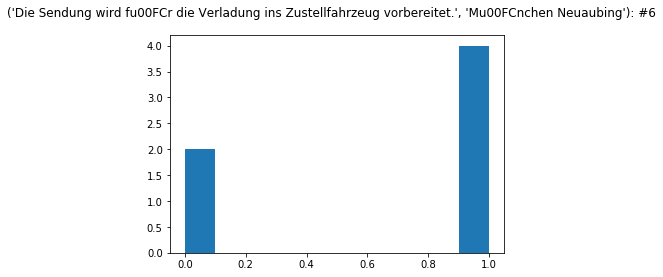

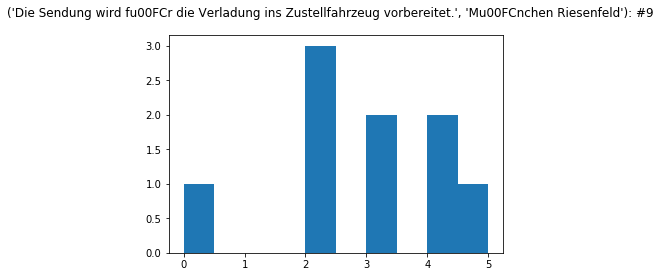

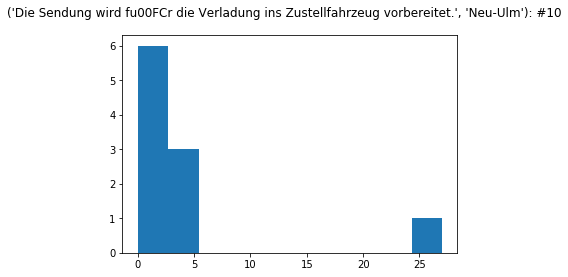

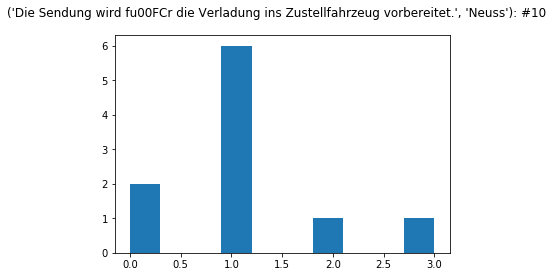

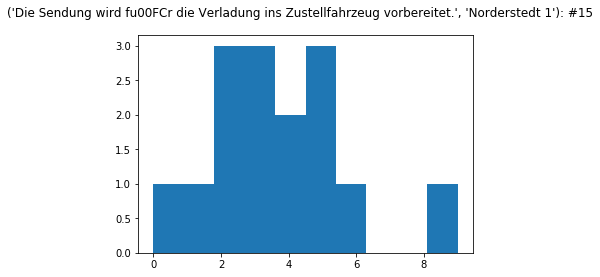

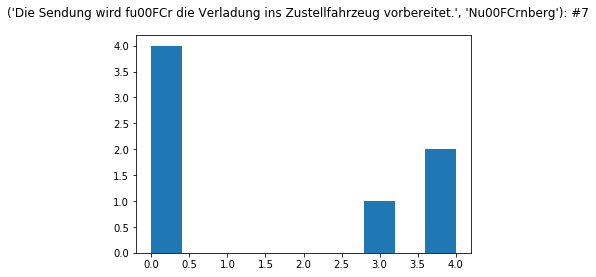

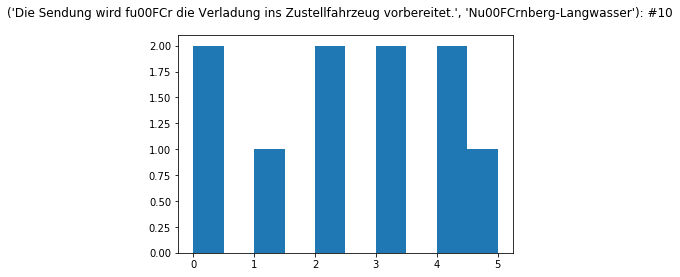

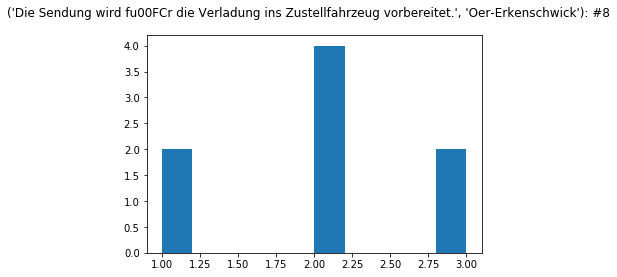

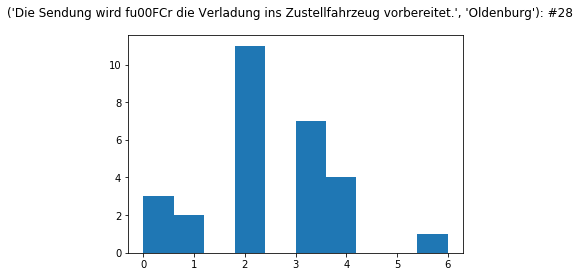

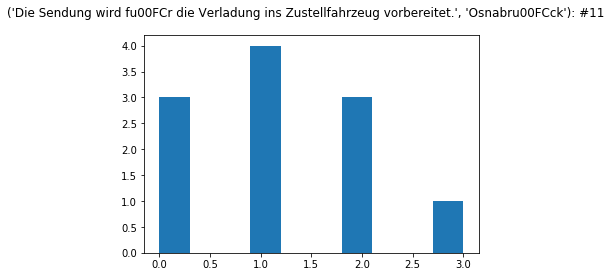

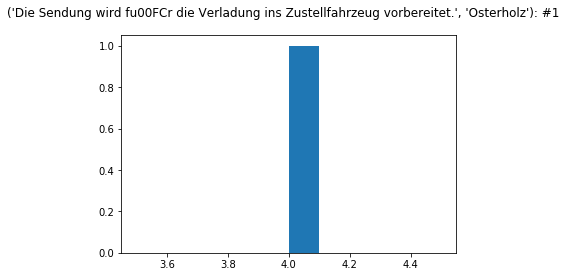

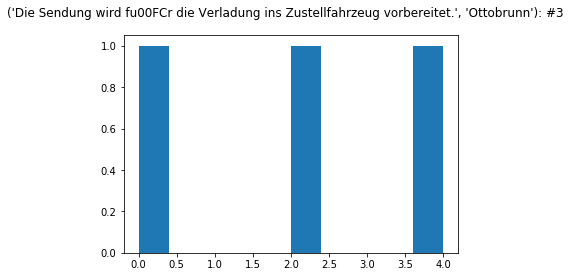

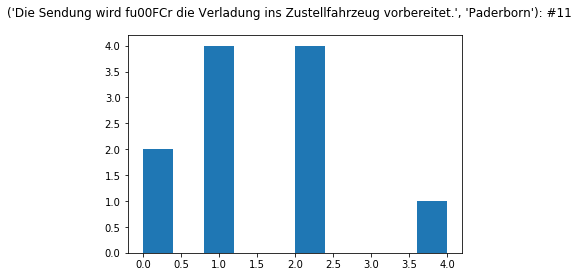

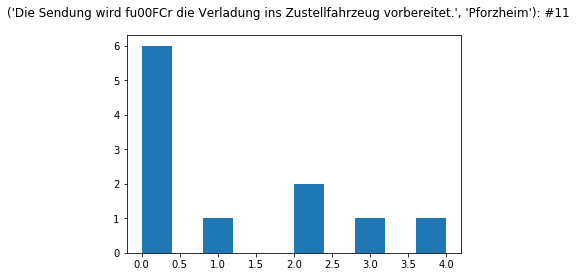

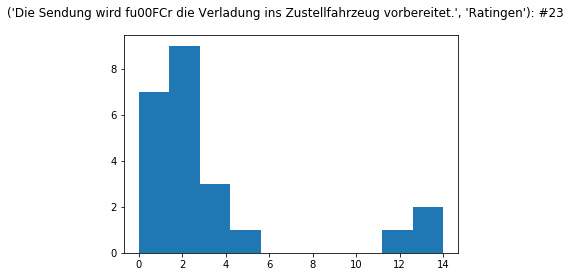

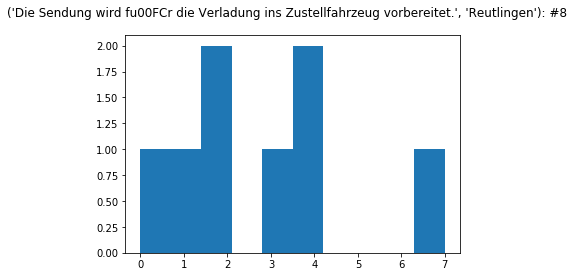

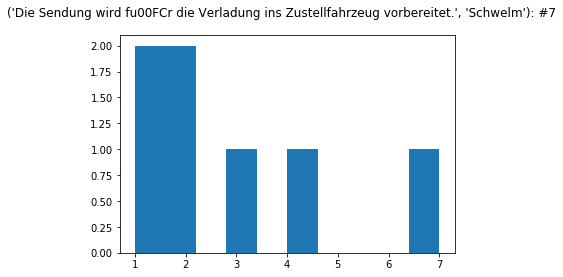

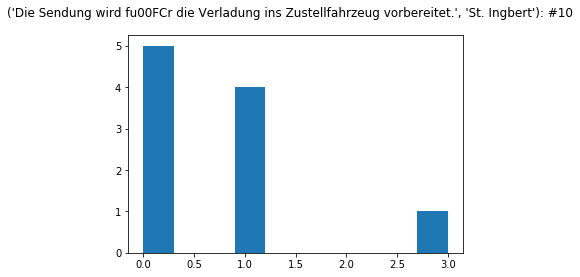

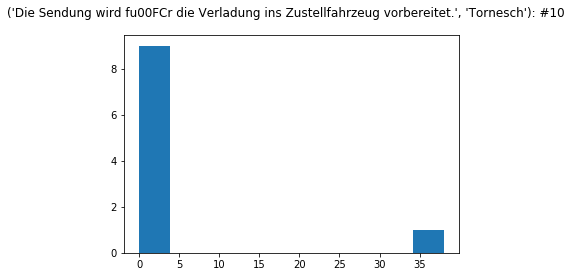

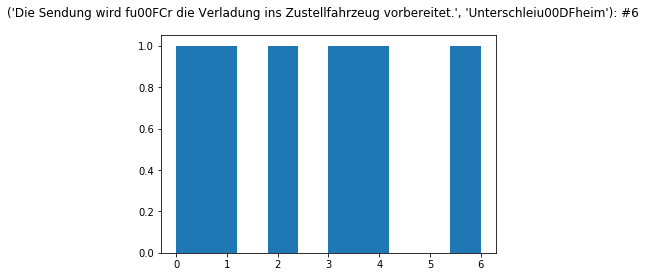

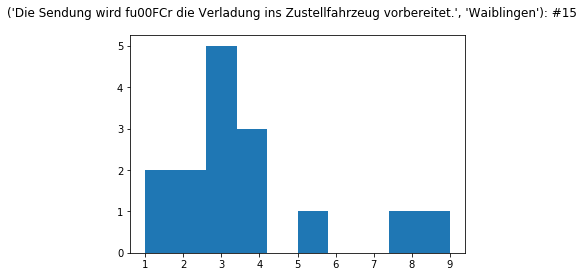

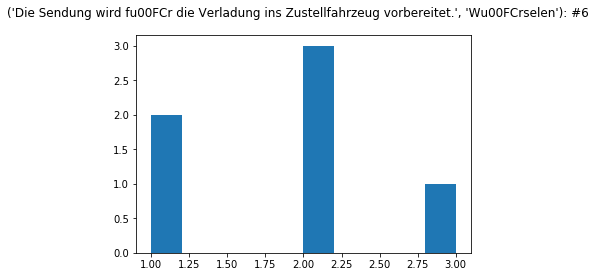

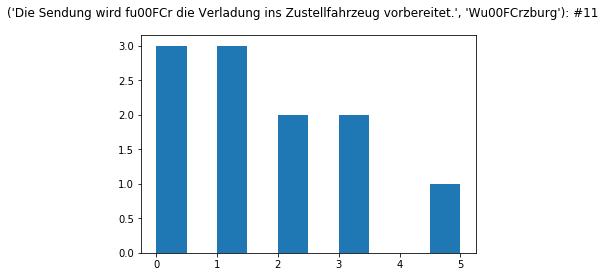

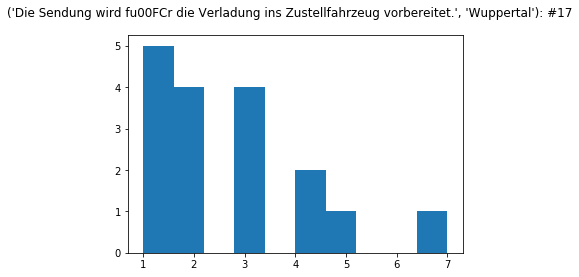

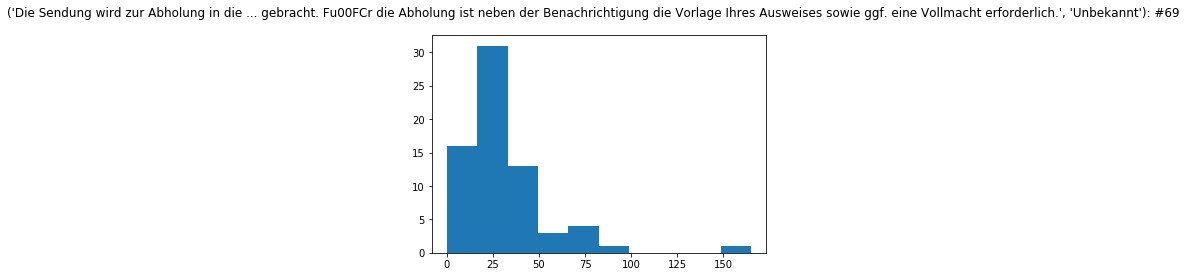

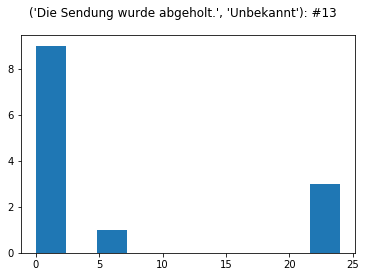

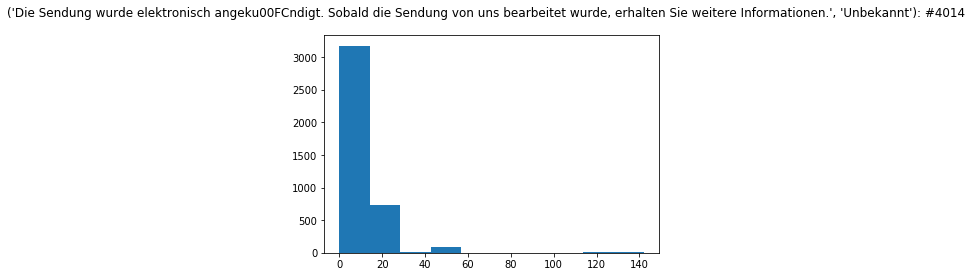

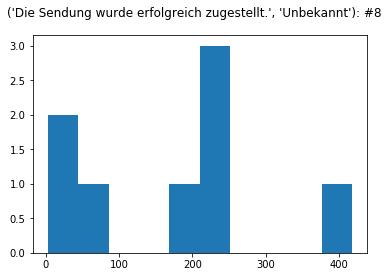

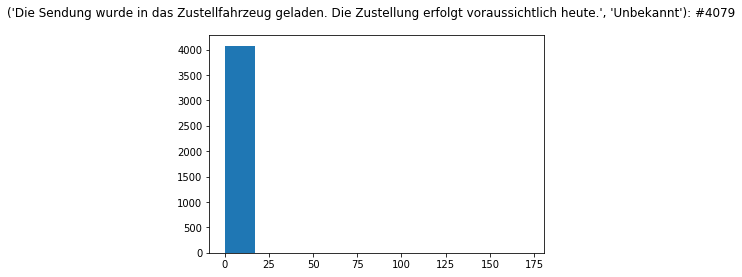

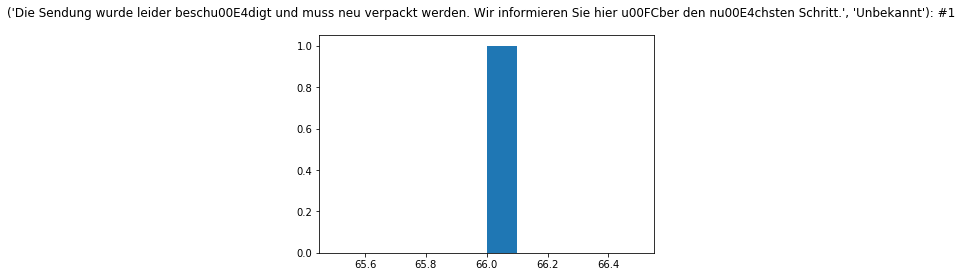

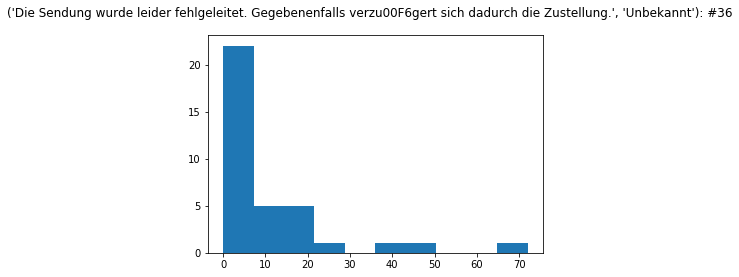

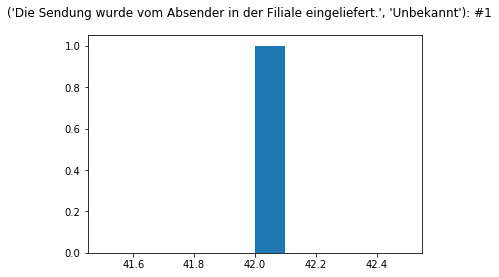

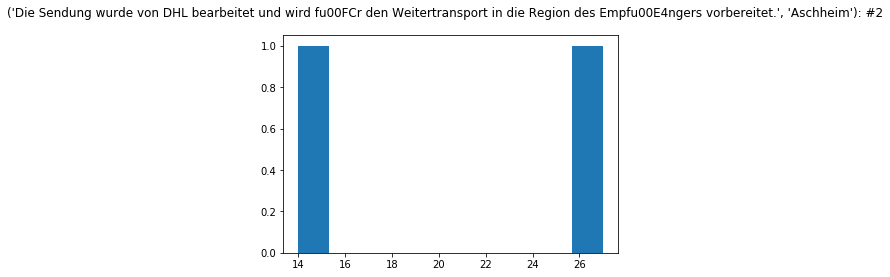

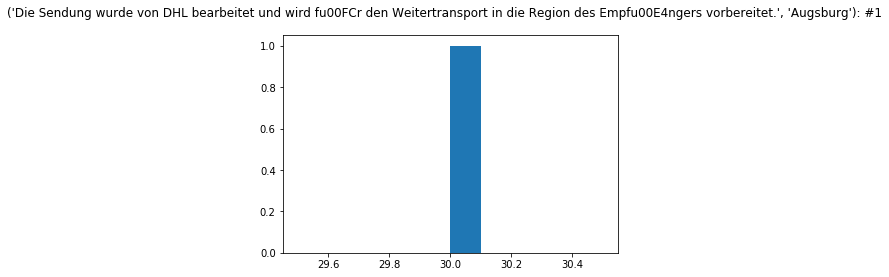

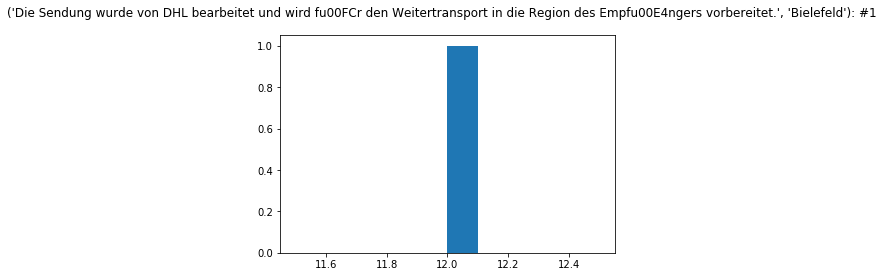

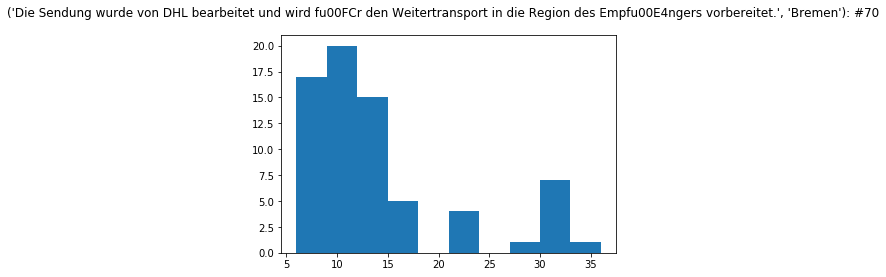

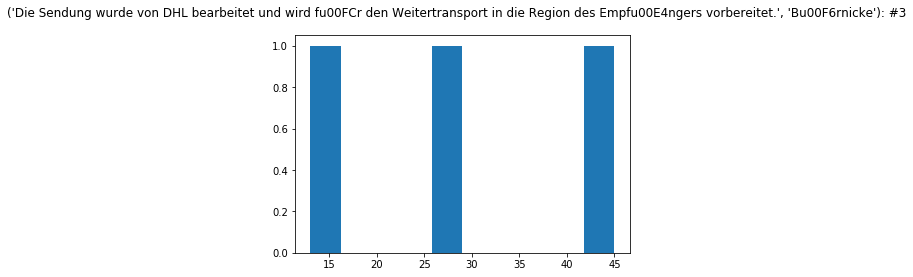

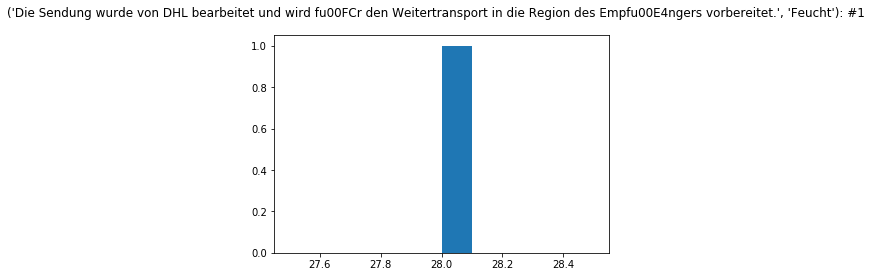

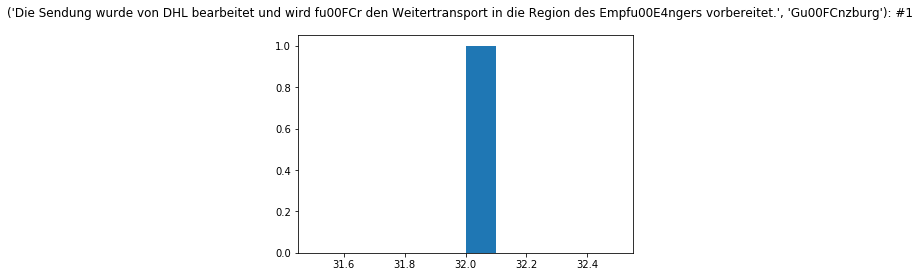

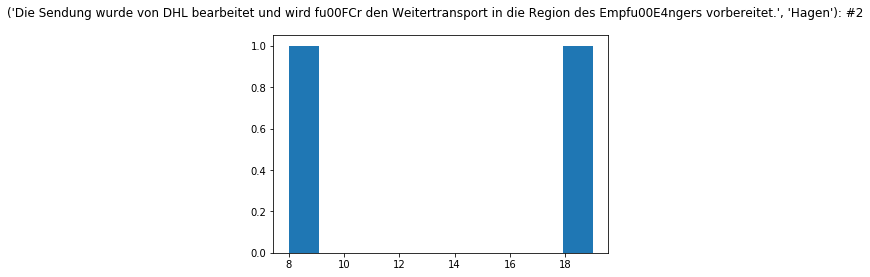

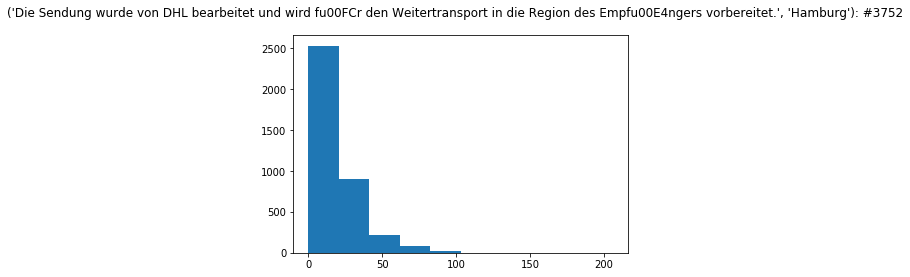

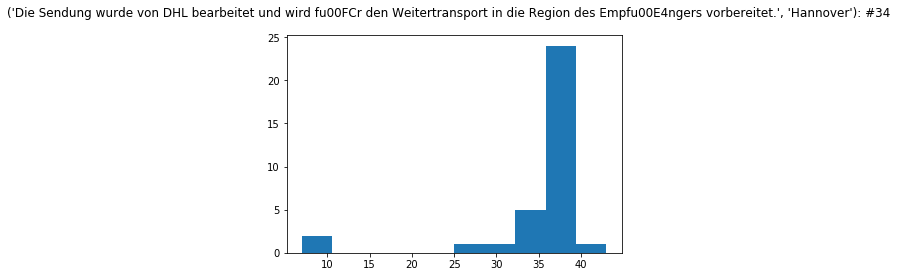

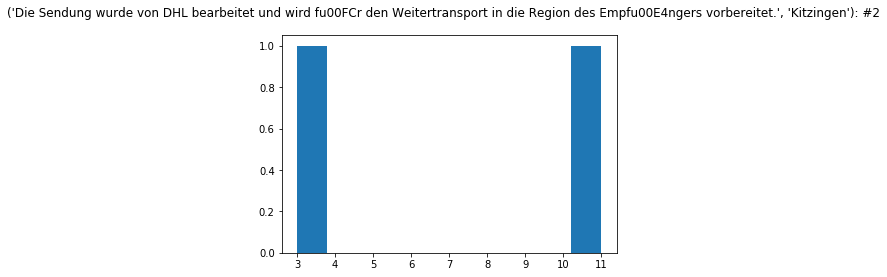

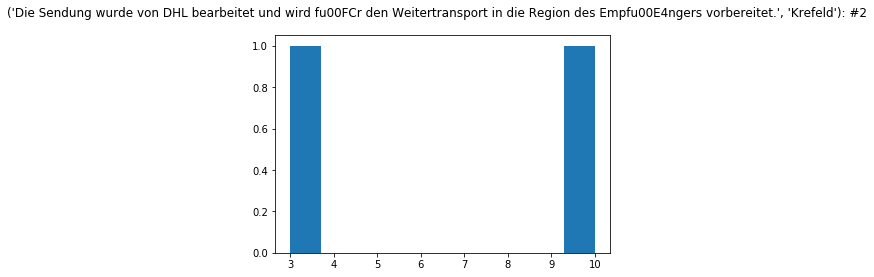

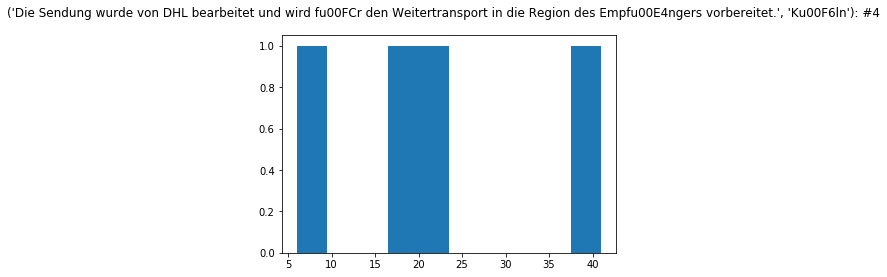

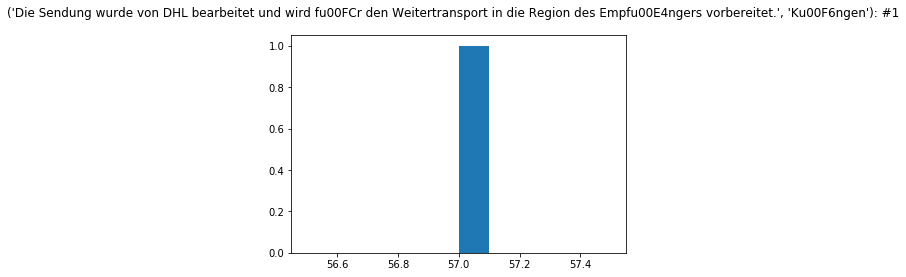

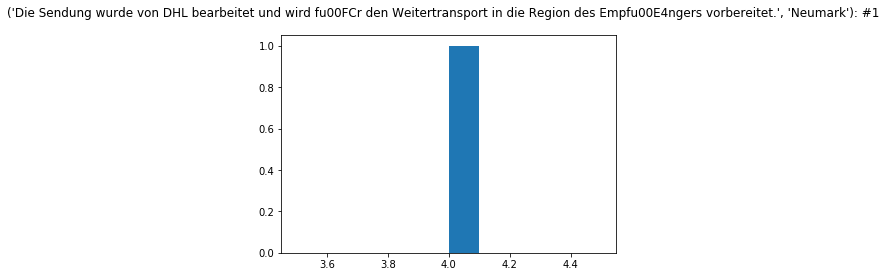

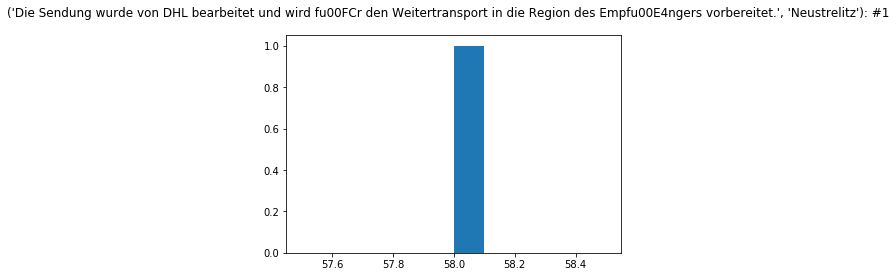

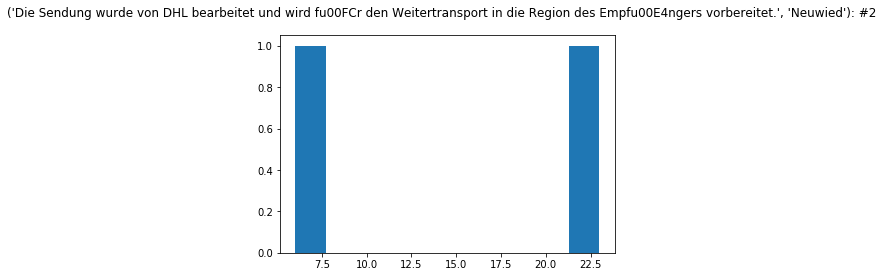

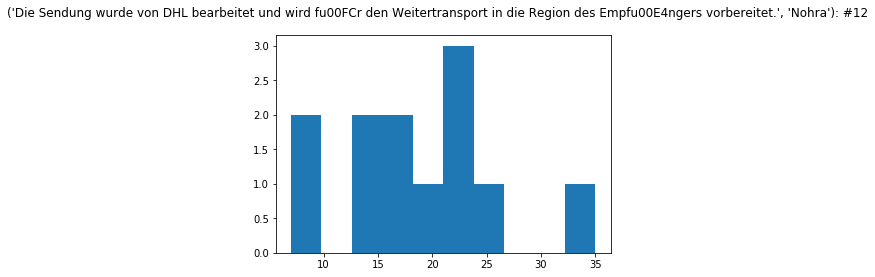

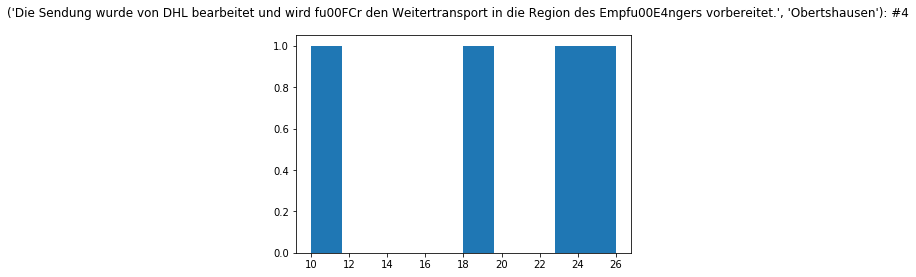

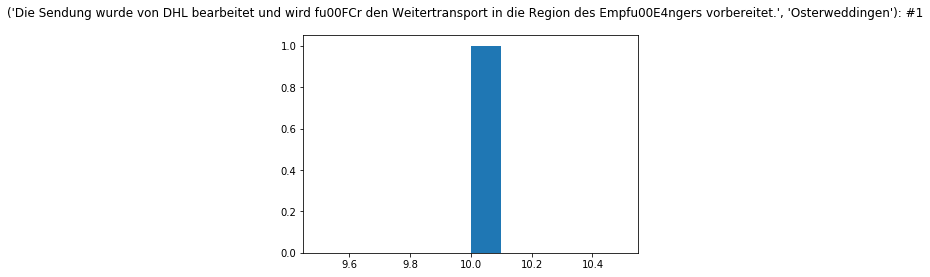

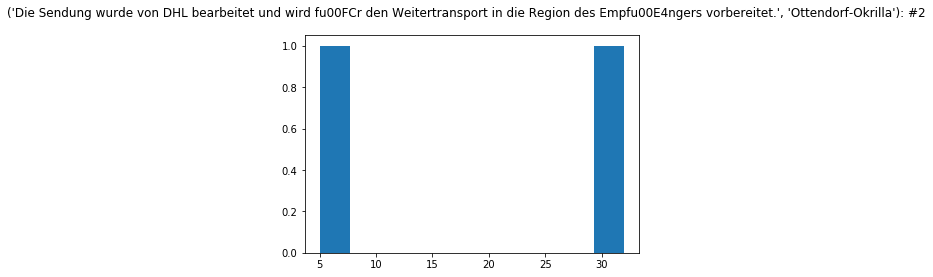

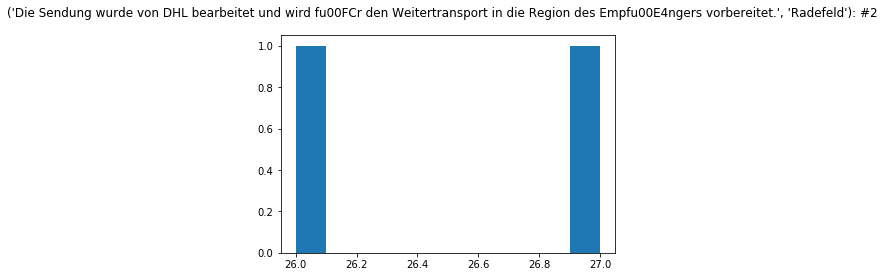

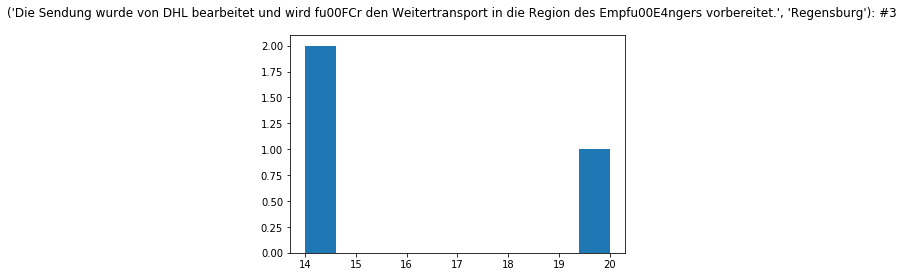

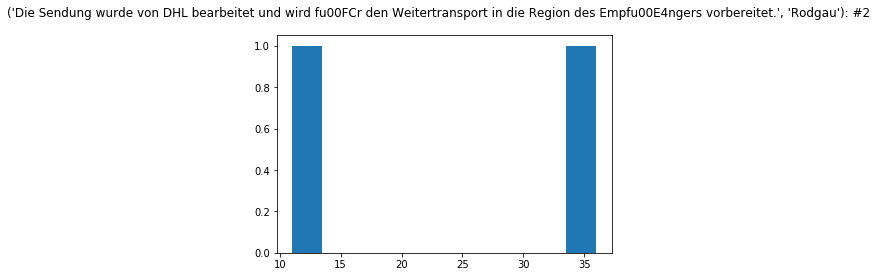

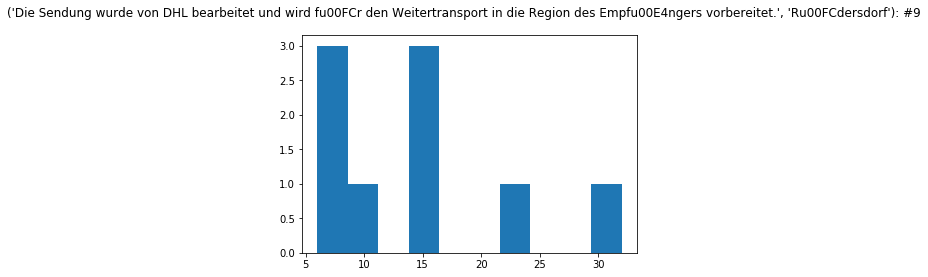

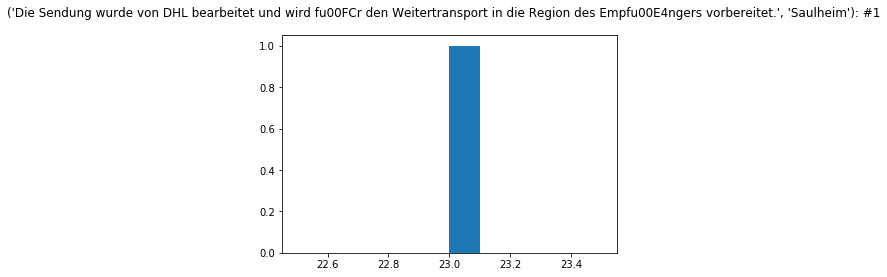

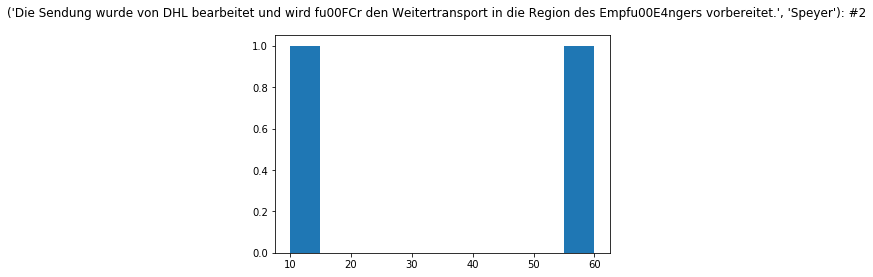

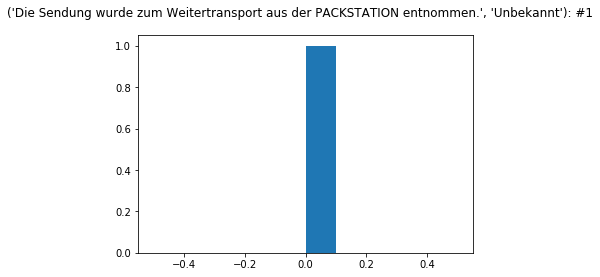

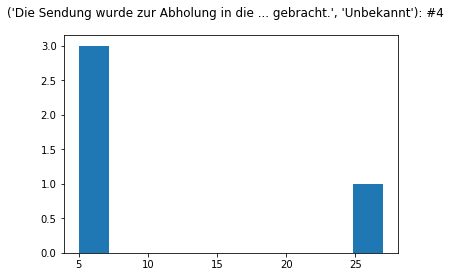

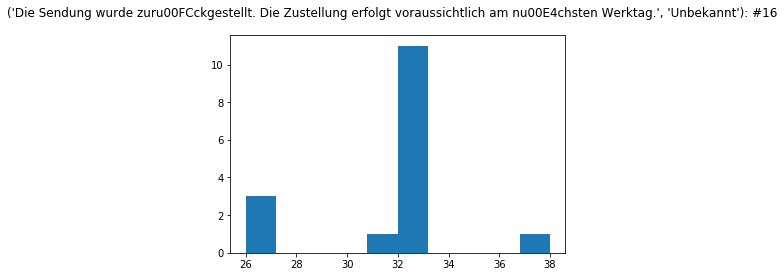

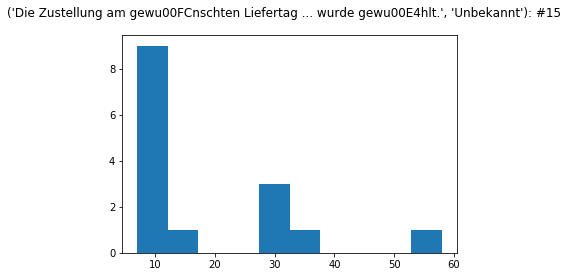

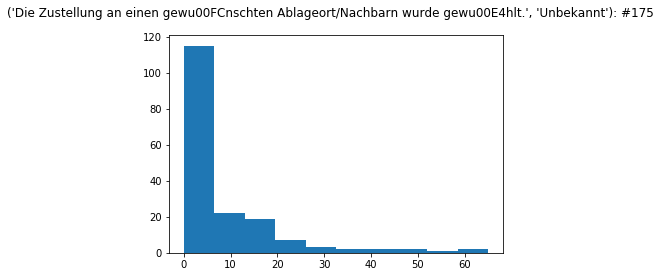

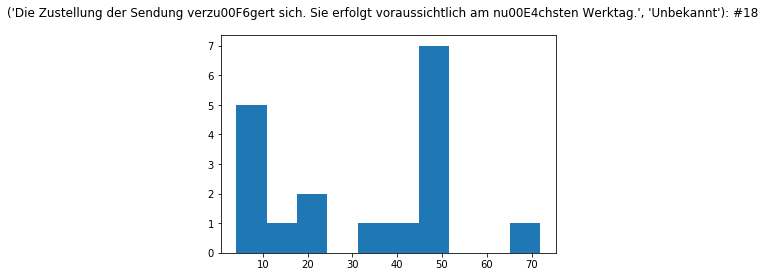

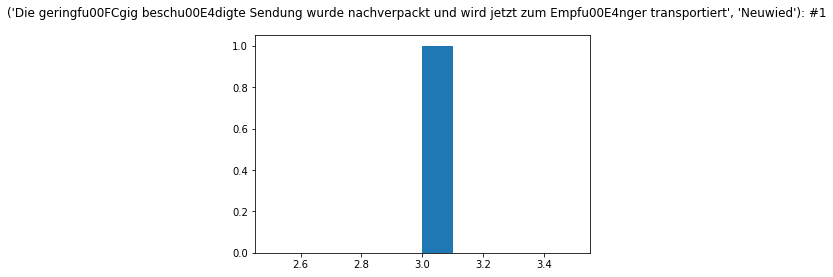

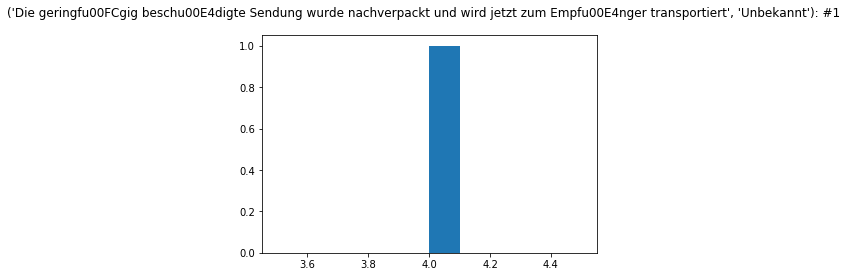

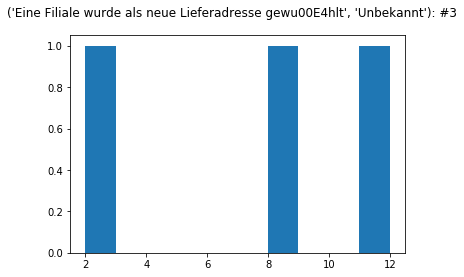

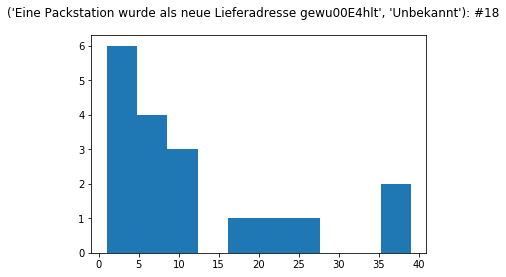

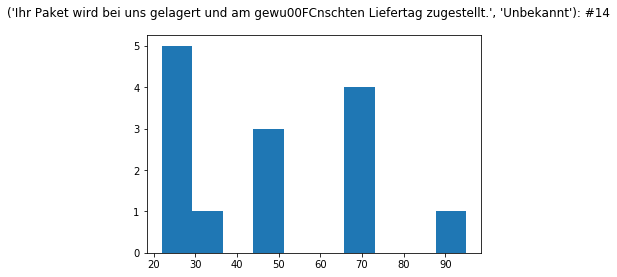

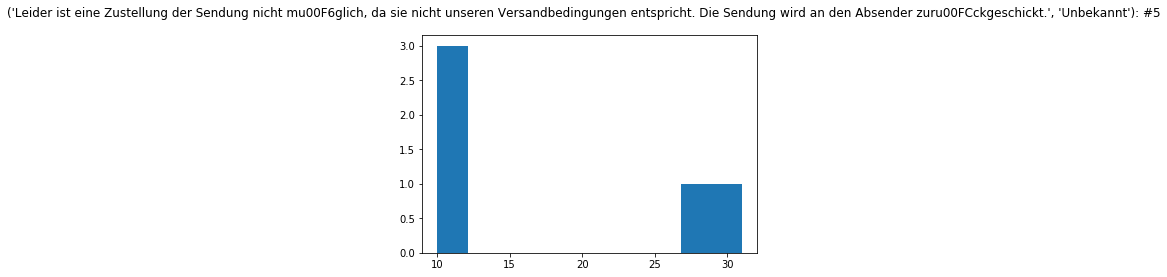

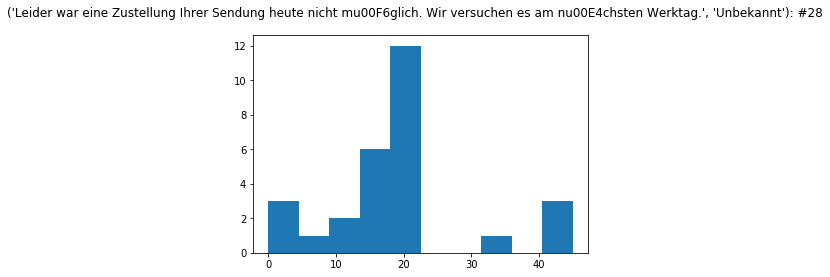

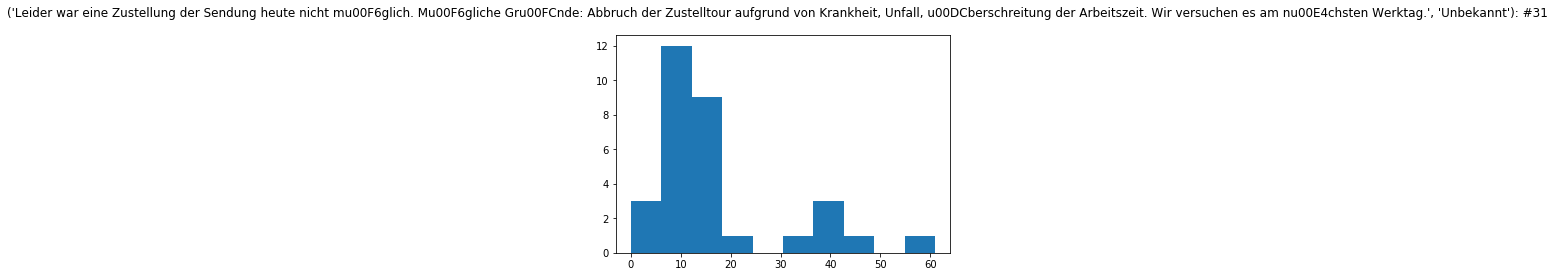

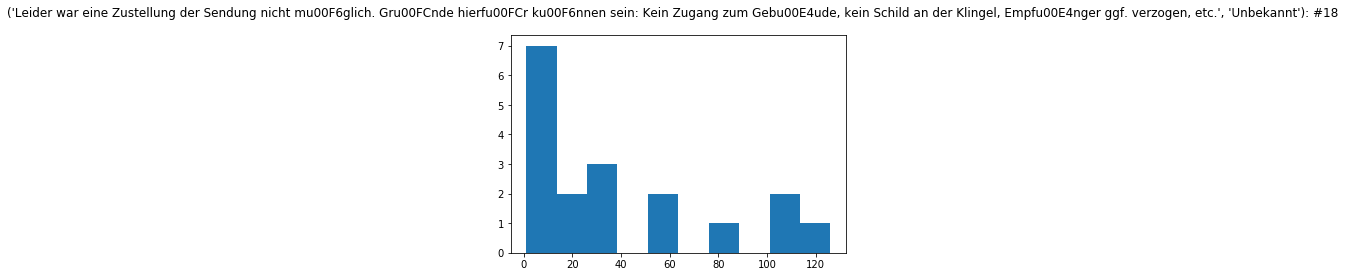

In [376]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


grouped = df_temp.groupby(["status", "ort"])

for name, group in grouped:
    fig = plt.figure()
    fig.suptitle(str(name) + ": #{}".format(len(group)))
    matplotlib.pyplot.hist(group.datum_diff_h)
    plt.show()
    
df.drop(columns=["datum_diff_h"], inplace=True)

In [377]:
df.head()

shipment_number                     datum  \
0  00340434188193325701 2019-10-08 14:42:00+00:00   
1  00340434188193325701 2019-10-08 18:19:00+00:00   
2  00340434188193325701 2019-10-09 02:44:00+00:00   
3  00340434188193325701 2019-10-09 07:46:00+00:00   
4  00340434188193325701 2019-10-09 10:35:00+00:00   

                                              status        ort  \
0  Die Sendung wurde elektronisch angeku00FCndigt...  Unbekannt   
1  Die Sendung wurde von DHL bearbeitet und wird ...    Hamburg   
2  Die Sendung ist in der Region des Empfu00E4nge...   Saulheim   
3  Die Sendung wurde in das Zustellfahrzeug gelad...  Unbekannt   
4          Die Sendung wurde erfolgreich zugestellt.  Unbekannt   

   is_final_event                                        status_next  \
0             0.0  Die Sendung wurde von DHL bearbeitet und wird ...   
1             0.0  Die Sendung ist in der Region des Empfu00E4nge...   
2             0.0  Die Sendung wurde in das Zustellfahrzeug gelad...   
3             0.0          Die Sendung wurde erfolgreich zugestellt.   
4             1.0                                    SuccessDelivery   

          ort_next                datum_next       datum_diff  
0          Hamburg 2019-10-08 18:19:00+00:00  0 days 03:37:00  
1         Saulheim 2019-10-09 02:44:00+00:00  0 days 08:25:00  
2        Unbekannt 2019-10-09 07:46:00+00:00  0 days 05:02:00  
3        Unbekannt 2019-10-09 10:35:00+00:00  0 days 02:49:00  
4  SuccessDelivery 2019-12-12 00:00:00+00:00 63 days 13:25:00